In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import RFE

Using TensorFlow backend.


In [25]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''
'r'
req_columns = ["timestamp","air1","furnace1","waterheater1","total"]

def plot_test(y_test,y_pred,start,end):
    #Plot of testing.
    plt.figure(figsize=(10,10))
    plt.plot(y_test[start:end],'r')
    plt.plot(y_pred[start+1:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_df(localdf):
    i=0
    flag=0
    newdf = []
    timestamp = []
    d = np.zeros((7,))
    newhr = []
    
    while(24*(i+1)<localdf.shape[0]):
        #print (np.shape(np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1)),np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1))
        d = np.sum(localdf.values[24*i:24*(i+1),1:],axis=0)
        newhr.append(localdf.values[24*i:24*(i+1),-1])
        timestamp.append(localdf.values[24*i,0])
        newdf.append(d.T)
        i += 1
    
    print ("End i: ",i)
    
    newdf = np.hstack((np.reshape(timestamp,(-1,1)),newdf))
    newsum = []
    
    #If the dataframe pertaining to the house-id : 1632 is passed, then do just the following.
    if(localdf.shape[1]>=8):
        print ("Passed the original DataFrame corresponding to the house id : 1632.")
        flag=1
        d = pd.DataFrame(newdf,columns = localdf.columns)  
    
    #If the dataframe passed does not pertain to that of the house-id : 1632.
    if (flag!=1):
        d = pd.DataFrame(newdf,columns=["timestamp","air1","furnace1","waterheater1"])
        d['total_load'] = d["air1"] + d["furnace1"] + d["waterheater1"]
    
    print (d.head())
    newdf = d.values
    
    print (newdf.shape)
    return newdf,newhr
  


def extra_trees(localdf,localdict,times,metric,num_cols,hour_day,full=True,stop=3):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            #The first column shouldn't be the 'timestamp'.
            if(i != 0):
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                print ("Inside extra trees : ",ndf.shape)
                if (full==True):
                    ndf = pd.DataFrame(ndf,columns = localdf.columns)
                else:
                    ndf = pd.DataFrame(ndf,columns = req_columns)
                
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                
                # To collate d1 to d7
                ndf = pd.concat([df.shift(l) for l in range(stop,-1,-1) ],axis=1)
                ndf.columns = [ "t-" + str(j) for j in range(stop,-1,-1) ]
                print ("mean :",ndf[ndf.columns[-1]].mean(),"max:",ndf[ndf.columns[-1]].max(),"min:",ndf[ndf.columns[-1]].min())
                ndf.rename(columns={'t-0':'t'}, inplace=True)
                
                #Adding new features.
                temp = pd.DataFrame()
                temp["dow"] = pd.to_datetime(ndf[ndf.columns[0]]).dt.dayofweek
                temp["month"] = pd.to_datetime(ndf[ndf.columns[0]]).dt.month
                    
                print ("Dimensions of temp : ",temp.shape)
                
                print ("\n\n Dimensions of ndf : ",ndf.shape)
                
                ndf = pd.concat([temp,ndf],axis=1)
                
                x = ndf.values[stop:,:-1]  #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[stop:,-1]
                
                ndf = ndf.iloc[stop:]
                print ("Shape of ndf after merging : ",ndf.shape)
                print (ndf.head())
                
                #'''
                #Addition of a new feature.
                
                #Incorporating the total load values of the previous four weeks corresponding to the same day.
                
                temp = pd.DataFrame()
                temp["prev_4_week-days"] = ndf["t"]
                k=0
                i=27
                while i < (ndf.shape[0]):
                    temp["prev_4_week-days"].values[i] = ndf["t"].values[i-6] + ndf["t"].values[i-13] + ndf["t"].values[i-20] + ndf["t"].values[i-27]
                    i += 1
                print ("Temp : ",temp.head())
                
                print ("Shape of ndf : ",ndf.shape)
                print ("Shape of temp : ",temp.shape)
                
                print ("ndf : ",ndf.head())
                print ("temp : ",temp.head())
                
                ndf = pd.concat([temp,ndf],axis=1)
                x = ndf.values[27:,:-1] #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[27:,-1]
                
                ndf = ndf.iloc[27:]
                print ("Shape of ndf after merging : ",ndf.shape)
                print (ndf.head())
                
                #print ("X : ",x)
                #'''
                
                #print ("\n The DataFrame to be passed to the model. \n",x.head())
                print (x.shape,y.shape)
                print (ndf.describe())
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                
                X_test = x[train_size:]
                y_test = y[train_size:]
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape)
                
                model=ExtraTreesRegressor(n_estimators=500,max_features=None,verbose=1)
                model.fit(X_train,y_train)
                y_pred = model.predict(X_test)
                
                importances = model.feature_importances_
                std = np.std([tree.feature_importances_ for tree in model.estimators_],
                             axis=0)
                indices = np.argsort(importances)[::-1]

                # Print the feature ranking
                print("Feature ranking according to the ETR : ")

                for f in range(x.shape[1]):
                    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

                '''
                Performing feature ranking.
                '''
                
                selector = RFE(model,step = 1)
                selector = selector.fit(x,y)
                print ("Ranking of the features : ",selector.ranking_,"\n\n\n")
                
                
                #The minimum value of y_pred should be '0', it can't go below that, that'd be illogical.
                y_pred[y_pred<0]=0
                
                r2 = r2_score(y_test,y_pred)
                mse = mean_squared_error(y_test,y_pred)
                mae = mean_absolute_error(y_test,y_pred)
                
                print ("R2 Score : ",r2)
                print ("RMSE : ",np.sqrt(mse))
                print ("MAE : ",mae)
                
                localdict["R2"] = r2
                localdict["RMSE"] = np.sqrt(mse)
                localdict["MAE"] = mae       
                
                #Visualize a plot of 'ytest' VS 'ypred'.
                plot_test(y_test,y_pred,0,50)
                
    return localdict,y_test,y_pred  

def nn_model(localdf,localdict,times,metric,num_cols,hour_day,full=True):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                print ("Inside nn : ",ndf.shape)
                
                if (full==True):
                    ndf = pd.DataFrame(ndf,columns = localdf.columns)
                else:
                    ndf = pd.DataFrame(ndf,columns = req_columns)
                
                print (ndf.head())
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                # To collate d1 to d7
                ndf = pd.concat([df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2),df.shift(1),df.shift(0)],axis=1)
                ndf.columns = ('t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                print ("mean :",ndf['t'].mean(),"max:",ndf['t'].max(),"min:",ndf['t'].min())
                
                x = ndf.values[7:,:-1] #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[7:,-1]
                
                print ("Input Dimensions : ",x.shape,y.shape)
                print (ndf.describe())
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                    
                X_test = x[train_size:]
                y_test = y[train_size:]
                
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape,)
                
                model = Sequential()
                model.add(Dense(7,input_dim=7,kernel_initializer='normal', activation='relu'))
                #Output Layer.
                model.add(Dense(1,kernel_initializer='normal'))
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=750,verbose=1)
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1,batch_size=X_test.shape[0])
                y_pred = model.predict(X_test,batch_size=X_test.shape[0])
                
                y_pred[y_pred<0]=0
                
                r2 = r2_score(y_test[:-1],y_pred[1:])
                mse = mean_squared_error(y_test[:-1],y_pred[1:])
                mae = mean_absolute_error(y_test[:-1],y_pred[1:])
                
                print ("R2 Score : ",r2)
                print ("RMSE : ",np.sqrt(mse))
                print ("MAE : ",mae)
                
                localdict["R2"] = r2
                localdict["RMSE"] = np.sqrt(mse)
                localdict["MAE"] = mae       
                
                #Visualize a plot of 'ytest' VS 'ypred'.
                plot_test(y_test,y_pred,0,50)
                del model
                
    return localdict,y_test,y_pred  

In [2]:
df= pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
df_new=df

In [3]:
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        print ('Empty Column')
        pos.append(i)
    else:
        print ('All fine')
        

All fine
All fine
All fine
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column


In [4]:
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

In [5]:
for i in range(3,len(df.columns)):
    print (df.columns[i], np.sum(np.isnan(df.iloc[:,i].values)))

air1 1
air2 1
air3 18
bathroom1 18
clotheswasher1 0
dishwasher1 0
disposal1 0
drye1 40833
dryg1 162
furnace1 18
furnace2 0
garage1 18
garage2 162
grid 1
kitchenapp1 0
kitchenapp2 0
lights_plugs1 18
lights_plugs2 18
lights_plugs3 40851
microwave1 0
outsidelights_plugs1 1
outsidelights_plugs2 1
range1 40851
refrigerator1 7942
waterheater1 18


In [6]:
nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range (len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b


In [7]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                      0
localhour                   0
use                         1
air1                        1
air2                        1
air3                       18
bathroom1                  18
clotheswasher1              0
dishwasher1                 0
disposal1                   0
drye1                   40833
dryg1                     162
furnace1                   18
furnace2                    0
garage1                    18
garage2                   162
grid                        1
kitchenapp1                 0
kitchenapp2                 0
lights_plugs1              18
lights_plugs2              18
lights_plugs3           40851
microwave1                  0
outsidelights_plugs1        1
outsidelights_plugs2        1
range1                  40851
refrigerator1            7942
waterheater1               18
dtype: int64

In [8]:
#Dropping the columns : (1) drye1 (2) lights_plugs3 (3)range1 
df.drop(df.columns[[10,21,25]],inplace=True,axis=1)

In [9]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                     0
localhour                  0
use                        1
air1                       1
air2                       1
air3                      18
bathroom1                 18
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                    162
furnace1                  18
furnace2                   0
garage1                   18
garage2                  162
grid                       1
kitchenapp1                0
kitchenapp2                0
lights_plugs1             18
lights_plugs2             18
microwave1                 0
outsidelights_plugs1       1
outsidelights_plugs2       1
refrigerator1           7942
waterheater1              18
dtype: int64

In [10]:
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]
print (df_thermal.shape)

(40995, 7)


In [11]:
df_thermal.head()

localhour  air1  air2  air3  furnace1  furnace2  waterheater1
0  2013-03-15 01:00:00-05   0.0   0.0   0.0  0.049567       0.0           0.0
1  2013-03-15 02:00:00-05   0.0   0.0   0.0  0.048283       0.0           0.0
2  2013-03-15 03:00:00-05   0.0   0.0   0.0  0.089833       0.0           0.0
3  2013-03-15 04:00:00-05   0.0   0.0   0.0  0.047067       0.0           0.0
4  2013-03-15 05:00:00-05   0.0   0.0   0.0  0.046250       0.0           0.0

In [12]:
df_thermal.isnull().sum()

localhour        0
air1             1
air2             1
air3            18
furnace1        18
furnace2         0
waterheater1    18
dtype: int64

In [13]:
df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)

In [14]:
df_thermal.isnull().sum()

localhour       0
air1            1
air2            1
air3            0
furnace1        0
furnace2        0
waterheater1    0
dtype: int64

In [15]:
print( df_thermal.iloc[34491:34494])
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2
print(df_thermal.iloc[34316-24*7+1],df_thermal.iloc[34316+24*7+1])

                    localhour air1         air2 air3 furnace1 furnace2  \
34491  2017-02-27 10:00:00-06    0  6.66667e-05    0    0.005    0.005   
34492  2017-02-27 11:00:00-06  NaN          NaN    0    0.005    0.005   
34493  2017-02-27 12:00:00-06    0            0    0    0.005    0.005   

      waterheater1  
34491            0  
34492            0  
34493            0  
localhour       2017-02-13 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34149, dtype: object localhour       2017-02-27 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34485, dtype: object


In [16]:
#Make it vectorized
day_hour = np.empty([df_thermal.shape[0],1],dtype="int")
for i in range(df_thermal.shape[0]):
    day_hour[i] = df_thermal.values[i][0][11:13]

In [17]:
day_hour = pd.DataFrame(day_hour)
day_hour.columns = ["Hour of the Day"]

In [18]:
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [19]:
df_thermal.head()

localhour air1 air2 air3    furnace1   furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      0.0059       0.01            0   
1  2013-03-23 09:00:00-05    0    0    0  0.00491667       0.01            0   
2  2013-03-23 10:00:00-05    0    0    0      0.0059  0.0762833     0.181567   
3  2013-03-23 11:00:00-05    0    0    0      0.0059  0.0760333      1.32477   
4  2013-03-23 12:00:00-05    0    0    0       0.006       0.01            0   

  total_thermal_load  
0             0.0159  
1          0.0149167  
2            0.26375  
3             1.4067  
4              0.016

In [20]:
df_new_thermal = pd.DataFrame(df_thermal,columns=df_thermal.columns)

In [21]:
#Converting 'kwHr' into 'Watt Hour'.
df_new_thermal = df_thermal.copy()
df_new_thermal.iloc[:,[1,2,3,4,5,6,7]] = df_new_thermal.iloc[:,[1,2,3,4,5,6,7]].mul(1000)

In [22]:
#Performing Sanity Check.
df_thermal.head()

localhour air1 air2 air3    furnace1   furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      0.0059       0.01            0   
1  2013-03-23 09:00:00-05    0    0    0  0.00491667       0.01            0   
2  2013-03-23 10:00:00-05    0    0    0      0.0059  0.0762833     0.181567   
3  2013-03-23 11:00:00-05    0    0    0      0.0059  0.0760333      1.32477   
4  2013-03-23 12:00:00-05    0    0    0       0.006       0.01            0   

  total_thermal_load  
0             0.0159  
1          0.0149167  
2            0.26375  
3             1.4067  
4              0.016

In [23]:
#Performing Sanity Check.
df_new_thermal.head()

localhour air1 air2 air3 furnace1 furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      5.9       10            0   
1  2013-03-23 09:00:00-05    0    0    0  4.91667       10            0   
2  2013-03-23 10:00:00-05    0    0    0      5.9  76.2833      181.567   
3  2013-03-23 11:00:00-05    0    0    0      5.9  76.0333      1324.77   
4  2013-03-23 12:00:00-05    0    0    0        6       10            0   

  total_thermal_load  
0               15.9  
1            14.9167  
2             263.75  
3             1406.7  
4                 16

In [26]:
new_df1,newhr = create_df(df_new_thermal)
new_df1 = pd.DataFrame(new_df1,columns = df_new_thermal.columns)
newhr = np.array(newhr)
newhr.shape

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)


(1700, 24)

In [27]:
new_df1.to_csv("",sep=",",encoding="utf-8")

pandas.core.frame.DataFrame

In [26]:
newhr

array([[15.9, 14.916666666666666, 263.74999999999994, ..., 16.0,
        15.916666666666666, 527.7166666666666],
       [117.4, 156.63333333333333, 137.25, ..., 1450.3666666666666,
        1942.8833333333332, 1048.2666666666667],
       [2774.5333333333333, 1729.2333333333333, 255.8833333333333, ...,
        2815.016666666667, 2872.4999999999995, 1612.6000000000001],
       ..., 
       [10.166666666666668, 10.083333333333332, 9.983333333333334, ...,
        10.0, 10.0, 10.166666666666668],
       [10.0, 423.5333333333333, 10.0, ..., 10.0, 10.0, 10.200000000000001],
       [10.0, 10.249999999999998, 10.0, ..., 10.0, 10.0, 10.216666666666665]], dtype=object)

In [27]:
#Sanity Check.
new_df1.head()

#Extracting only the 'air1', 'furnace1' and 'waterheater1' features.
new_df1 = new_df1[["localhour","air1","furnace1","waterheater1"]]
new_df1["total_thermal_load"] = new_df1["air1"] + new_df1["furnace1"] + new_df1["waterheater1"]
new_df1.head()

localhour      air1 furnace1 waterheater1 total_thermal_load
0  2013-03-23 08:00:00-05         0  142.417      2567.92            2710.33
1  2013-03-24 08:00:00-05         0  4182.12      1473.55            5655.67
2  2013-03-25 08:00:00-05      0.15  10421.1      5991.67            16412.9
3  2013-03-26 08:00:00-05         0  5657.58      1437.45            7095.03
4  2013-03-27 08:00:00-05  0.133333     3477      4167.75            7644.88


Year :  2013

Month :  Jan
Number of days present :  0

Year :  2013

Month :  Feb
Number of days present :  0

Year :  2013

Month :  Mar
Number of days present :  9

Year :  2013

Month :  Apr
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-04-01 00:00:00-05   734.083         0    0  140.933      240   
1  2013-04-02 00:00:00-05   44.9833         0    0  140.217  239.983   
2  2013-04-03 00:00:00-05  0.116667  0.366667    0  11264.6    502.9   
3  2013-04-04 00:00:00-05   51.8167  0.966667    0  11336.9  306.883   
4  2013-04-05 00:00:00-05   1.38333       6.4    0  9808.42  1721.98   

  waterheater1 total_thermal_load  
0      1972.73            3087.75  
1       2567.4            2992.58  
2      3294.93            15062.9  
3      4334.93            16031.5  
4      2726.75            14264.9  
(29, 8)
Inside extra 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


8289.41666667 max: 17856.433333333334 min: 1802.6833333333334
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  3087.75
1  NaN    NaN      NaN      NaN  3087.75  2992.58
2  NaN    NaN      NaN  3087.75  2992.58  15062.9
3  3.0    1.0  3087.75  2992.58  15062.9  16031.5
4  3.0    1.0  2992.58  15062.9  16031.5  14264.9
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 2 (0.507872)
2. feature 4 (0.315368)
3. feature 3 (0.176760)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 1 2] 



R2 Score :  -0.0325087493454
RMSE :  4069.85340017
MAE :  3540.39587083


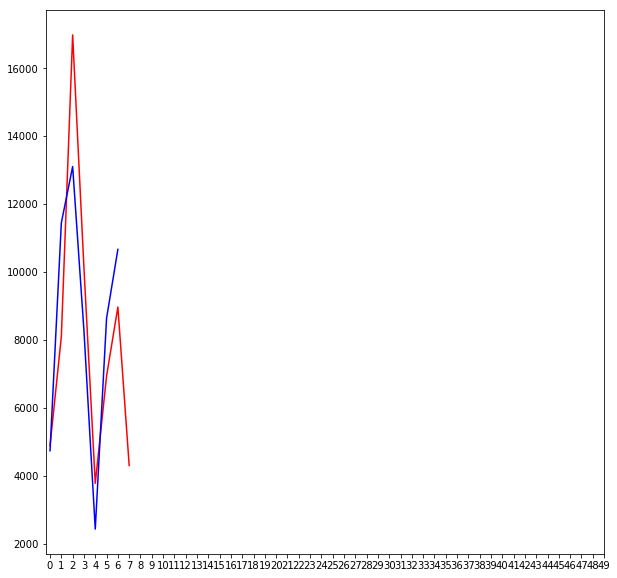


Time Taken :  2.772820234298706

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  May
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-05-01 00:00:00-05   4667.78     625.3  226.367  194.267  408.333   
1  2013-05-02 00:00:00-05     915.2   4.51667        0   7427.6  239.883   
2  2013-05-03 00:00:00-05      0.95   6.76667        0  15493.4  239.967   
3  2013-05-04 00:00:00-05  0.833333   5.08333        0  10306.8  239.817   
4  2013-05-05 00:00:00-05       2.1  0.616667        0  141.733    241.1   

  waterheater1 total_thermal_load  
0      1701.17            7823.22  
1      3220.48            11807.7  
2      3285.23            19026.3  
3      2470.52            13023.1  
4      2916.25             3301.8  
(30, 8)
Inside extra trees :  (30, 8)
mean : 53

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


min: 1153.35
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  7823.22
1  NaN    NaN      NaN      NaN  7823.22  11807.7
2  NaN    NaN      NaN  7823.22  11807.7  19026.3
3  3.0    1.0  7823.22  11807.7  19026.3  13023.1
4  3.0    1.0  11807.7  19026.3  13023.1   3301.8
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.583669)
2. feature 3 (0.220973)
3. feature 2 (0.195359)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -1.34121404346
RMSE :  2065.0790019
MAE :  1780.11904074


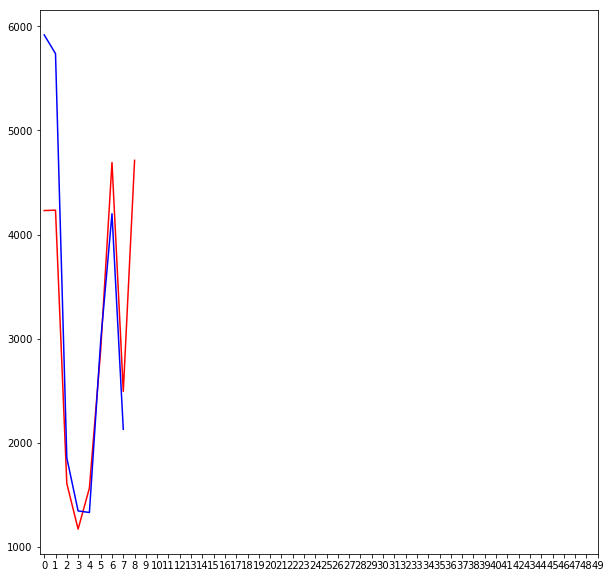


Time Taken :  2.646622657775879

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Jun
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-06-01 00:00:00-05  14860.9  7197.73        0  139.167  1886.43   
1  2013-06-02 00:00:00-05  10501.9   1398.9        0   140.25   588.55   
2  2013-06-03 00:00:00-05  9228.38  1434.92        0  142.133  561.867   
3  2013-06-04 00:00:00-05  9737.83  3919.98        0   140.75  1083.98   
4  2013-06-05 00:00:00-05  11935.6  3197.18  4852.67  1113.93  947.017   

  waterheater1 total_thermal_load  
0      824.567            24908.8  
1      824.483              13454  
2        381.4            11748.7  
3      805.717            15688.3  
4      390.633            22437.1  
(29, 8)
Inside extra trees :  (29, 8)
mean : 25278.7362069 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


47711.43333333332 min: 6763.6
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  24908.8
1  NaN    NaN      NaN      NaN  24908.8    13454
2  NaN    NaN      NaN  24908.8    13454  11748.7
3  3.0    1.0  24908.8    13454  11748.7  15688.3
4  3.0    1.0    13454  11748.7  15688.3  22437.1
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.557331)
2. feature 2 (0.255980)
3. feature 3 (0.186689)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.909414381565
RMSE :  9838.91881813
MAE :  7913.76506667


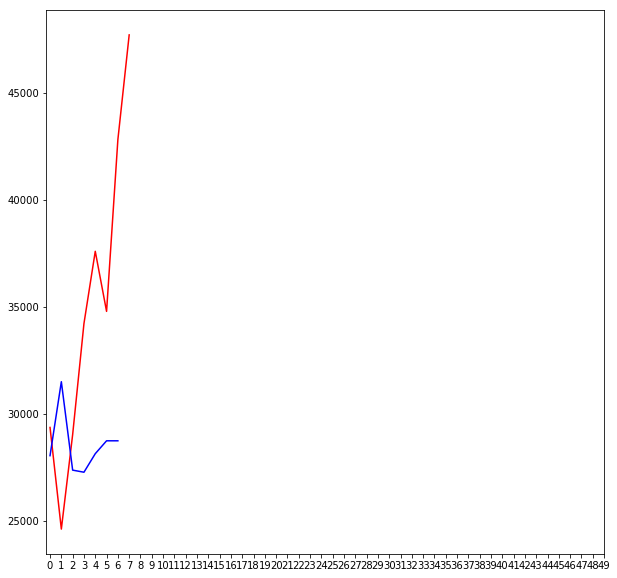


Time Taken :  2.737117052078247

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Jul
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-07-01 00:00:00-05  12486.5  1596.67  2518.13  698.233    606.9   
1  2013-07-02 00:00:00-05  8757.78  3544.17  2778.17  728.667  1042.97   
2  2013-07-03 00:00:00-05  12945.8  5899.05  3797.28  921.233  1516.53   
3  2013-07-04 00:00:00-05  11987.9  3764.02  3045.07  777.283  1071.73   
4  2013-07-05 00:00:00-05  15418.1  2617.47  5276.68  1172.25  766.267   

  waterheater1 total_thermal_load  
0        806.4            18712.8  
1       796.25              17648  
2        408.2            25488.1  
3        809.6            21455.6  
4      420.667            25671.5  
(30, 8)
Inside extra trees :  (30, 8)
mean : 26704.8905556 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Feature ranking according to the ETR : 
1. feature 4 (0.470864)
2. feature 3 (0.323886)
3. feature 2 (0.205250)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.711146833111
RMSE :  6819.27374718
MAE :  4474.68410741


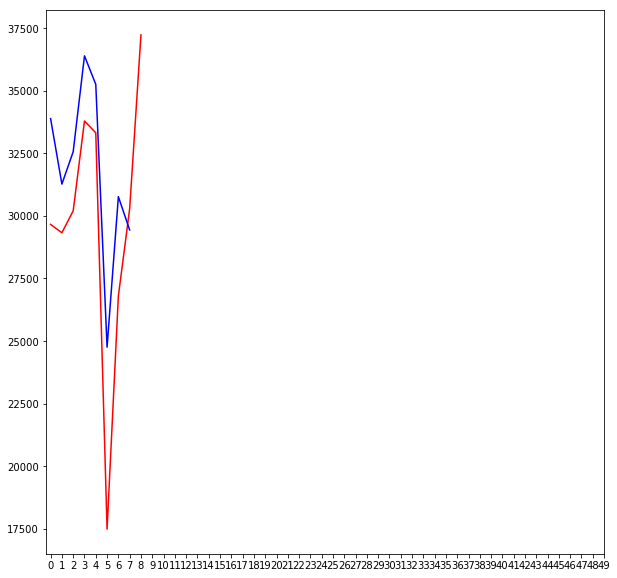


Time Taken :  2.868302345275879

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Aug
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-08-01 00:00:00-05  19886.2   8133.7    20300  4093.68  1904.92   
1  2013-08-02 00:00:00-05  19476.3  8091.87    11555  2492.72  1918.58   
2  2013-08-03 00:00:00-05  20167.2  4237.57  7008.13  1501.42  1087.03   
3  2013-08-04 00:00:00-05  21725.2   8559.2  7058.15  1547.78  2059.77   
4  2013-08-05 00:00:00-05  14793.1     0.45  7479.22  1580.63    212.8   

  waterheater1 total_thermal_load  
0      1604.32            55922.8  
1      773.717            44308.2  
2       416.65              34418  
3        430.2            41380.3  
4      815.983            24882.2  
(30, 8)
Inside extra trees :  (30, 8)
mean : 34447.8838889 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  55922.8
1  NaN    NaN      NaN      NaN  55922.8  44308.2
2  NaN    NaN      NaN  55922.8  44308.2    34418
3  3.0    1.0  55922.8  44308.2    34418  41380.3
4  3.0    1.0  44308.2    34418  41380.3  24882.2
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.563522)
2. feature 4 (0.334227)
3. feature 2 (0.102251)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.0990502165397
RMSE :  10624.9989954
MAE :  9053.32756667


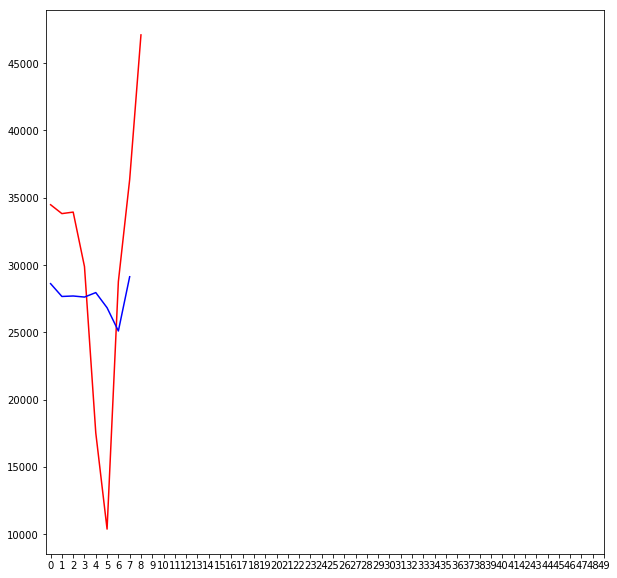


Time Taken :  2.661832332611084

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Sept
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-09-01 00:00:00-05  19606.4  5055.07   7030.2  1427.33  1373.57   
1  2013-09-02 00:00:00-05  19400.6  7528.98  7350.53  1487.53  1930.13   
2  2013-09-03 00:00:00-05  18425.4  5701.52  7298.77  1465.57  1505.25   
3  2013-09-04 00:00:00-05  19122.3   5652.8  6442.38   1352.9  1559.27   
4  2013-09-05 00:00:00-05  13706.9  5408.08   5630.1  1183.02  1499.38   

  waterheater1 total_thermal_load  
0      825.583            35318.2  
1      423.017            38120.8  
2      832.083            35228.6  
3      407.733            34537.4  
4      804.833            28232.3  
(29, 8)
Inside extra trees :  (29, 8)
mean : 21475.8264368

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  35318.2
1  NaN    NaN      NaN      NaN  35318.2  38120.8
2  NaN    NaN      NaN  35318.2  38120.8  35228.6
3  3.0    1.0  35318.2  38120.8  35228.6  34537.4
4  3.0    1.0  38120.8  35228.6  34537.4  28232.3
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.588609)
2. feature 3 (0.242010)
3. feature 2 (0.169381)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.304431688929
RMSE :  6467.14152785
MAE :  5140.0460625


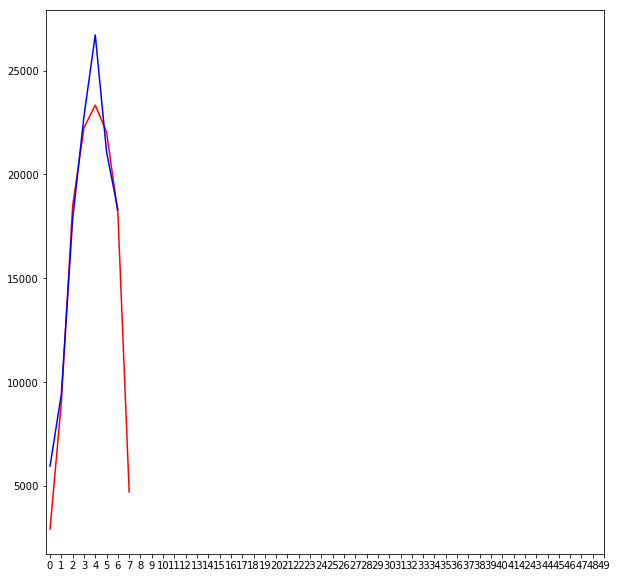


Time Taken :  2.6380491256713867

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2 air3 furnace1 furnace2  \
0  2013-10-01 00:00:00-05    10790  1760.07    0  119.417   674.25   
1  2013-10-02 00:00:00-05  9973.63  2143.07    0    119.1  751.883   
2  2013-10-03 00:00:00-05  11358.4  5824.18    0   117.25  1681.02   
3  2013-10-04 00:00:00-05  11841.2  4299.12    0   117.95  1284.53   
4  2013-10-05 00:00:00-05  5842.32   415.55    0  119.867  331.883   

  waterheater1 total_thermal_load  
0      770.317              14114  
1      780.867            13768.5  
2      389.333            19370.2  
3      764.817            18307.6  
4      1154.92            7864.53  
(30, 8)
Inside extra trees :  (30, 8)
mean :

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 6298.435 max: 20710.433333333334 min: 1103.9166666666667
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    14114
1  NaN    NaN      NaN      NaN    14114  13768.5
2  NaN    NaN      NaN    14114  13768.5  19370.2
3  3.0    1.0    14114  13768.5  19370.2  18307.6
4  3.0    1.0  13768.5  19370.2  18307.6  7864.53
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.760021)
2. feature 2 (0.125808)
3. feature 3 (0.114171)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -14.0441051193
RMSE :  6256.37086135
MAE :  3294.75214444


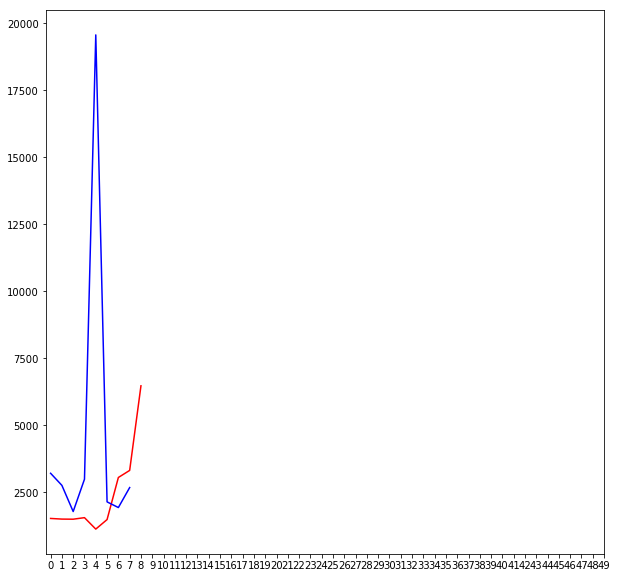


Time Taken :  2.7503817081451416

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-11-01 00:00:00-05         0       0.1      1.7  120.283   226.95   
1  2013-11-02 00:00:00-05  0.133333  0.383333     1.65    120.6  232.117   
2  2013-11-03 00:00:00-05         0  0.383333  1.78333    120.3  226.517   
3  2013-11-03 23:00:00-06   1.16667       1.8  2.28333  119.983  227.783   
4  2013-11-04 23:00:00-06      0.05  0.166667      1.1  119.917  227.767   

  waterheater1 total_thermal_load  
0      1167.22            1516.25  
1      1150.97            1505.85  
2      1163.63            1512.62  
3      1539.28             1892.3  
4      796.233            1145.23  
(30, 8)
Inside extra trees :  (30, 8)
mean : 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1516.25
1  NaN    NaN      NaN      NaN  1516.25  1505.85
2  NaN    NaN      NaN  1516.25  1505.85  1512.62
3  3.0    1.0  1516.25  1505.85  1512.62   1892.3
4  3.0    1.0  1505.85  1512.62   1892.3  1145.23
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.423066)
2. feature 2 (0.386429)
3. feature 3 (0.190506)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.40648309414
RMSE :  21681.4127542
MAE :  18248.9246704


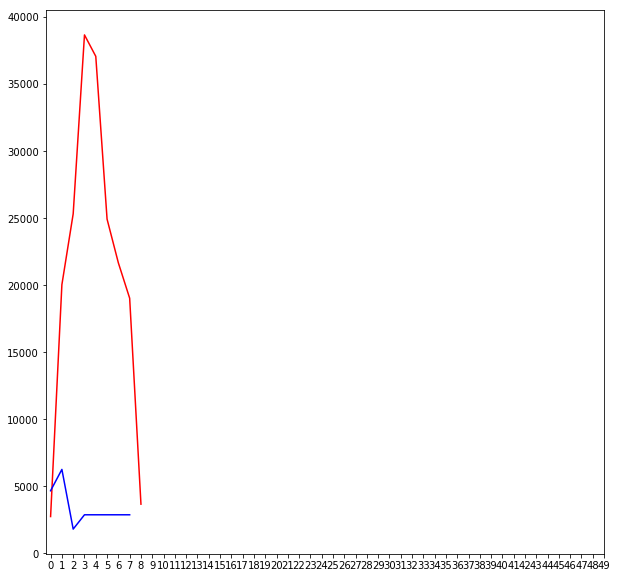


Time Taken :  2.8374345302581787

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-12-01 00:00:00-06      0.05      0.15  2.06667  120.583  1104.47   
1  2013-12-02 00:00:00-06      0.15  0.866667     1.85  120.233    557.9   
2  2013-12-03 00:00:00-06       0.2  0.933333  1.76667    120.3  700.683   
3  2013-12-04 00:00:00-06  0.816667   1.21667      1.8    119.9  230.583   
4  2013-12-05 00:00:00-06      0.35   1.76667     2.85   1435.9   1967.6   

  waterheater1 total_thermal_load  
0      1185.88             2413.2  
1      1189.35            1870.35  
2      1104.93            1928.82  
3      1245.28             1599.6  
4      1559.55            4968.02  
(30, 8)
Inside extra trees :  (30, 8)
mean : 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


69397.58333333334 min: 1582.6833333333332
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   2413.2
1  NaN    NaN      NaN      NaN   2413.2  1870.35
2  NaN    NaN      NaN   2413.2  1870.35  1928.82
3  3.0    1.0   2413.2  1870.35  1928.82   1599.6
4  3.0    1.0  1870.35  1928.82   1599.6  4968.02
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.660005)
2. feature 3 (0.189796)
3. feature 2 (0.150200)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.54786796575
RMSE :  11472.0672044
MAE :  7564.28218889


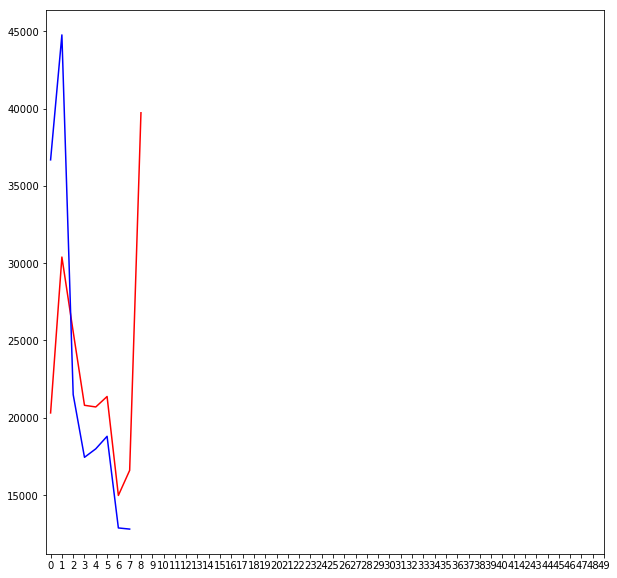


Time Taken :  2.6961705684661865

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jan
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2014-01-01 00:00:00-06       0.9  10.7667  2.93333  12877.4  3907.43   
1  2014-01-02 00:00:00-06         0      9.4     2.95  12162.9  3850.58   
2  2014-01-03 00:00:00-06  0.216667    14.85  3.41667    18437   4833.9   
3  2014-01-04 00:00:00-06      0.45  8.06667  2.01667  10145.4  3127.08   
4  2014-01-05 00:00:00-06  0.233333  5.58333     3.65  6450.97  3322.77   

  waterheater1 total_thermal_load  
0      1532.08            18331.5  
1       1542.8            17568.6  
2      1839.45            25128.8  
3       1125.5            14408.5  
4      1888.48            11671.7  
(30, 8)
Inside extra trees :  (30, 8)
mean : 19813.6

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


59076.34999999999 min: 2273.5333333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  18331.5
1  NaN    NaN      NaN      NaN  18331.5  17568.6
2  NaN    NaN      NaN  18331.5  17568.6  25128.8
3  3.0    1.0  18331.5  17568.6  25128.8  14408.5
4  3.0    1.0  17568.6  25128.8  14408.5  11671.7
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.461730)
2. feature 2 (0.317162)
3. feature 3 (0.221108)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.989005038206
RMSE :  19345.7123775
MAE :  15475.916737


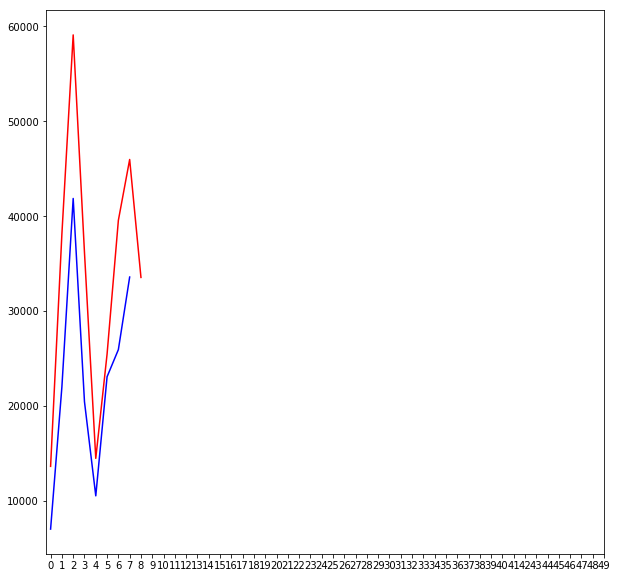


Time Taken :  2.8346683979034424

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Feb
Number of days present :  28
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-02-01 00:00:00-06      0.25  0.666667        5      121  119.733   
1  2014-02-02 00:00:00-06  0.366667     23.25  4.61667  28613.4   2015.5   
2  2014-02-03 00:00:00-06      0.35     35.45  6.96667    46265  3395.58   
3  2014-02-04 00:00:00-06  0.166667     18.65  8.08333  24992.2   1976.6   
4  2014-02-05 00:00:00-06       0.2   23.6667      5.7  30143.6  2707.78   

  waterheater1 total_thermal_load  
0      3690.98            3937.63  
1      2334.43            32991.6  
2      4186.53            53889.9  
3      3924.87            30920.6  
4      3151.55            36032.5  
(27, 8)
Inside extra trees :  (27, 8)
mean : 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  3937.63
1  NaN    NaN      NaN      NaN  3937.63  32991.6
2  NaN    NaN      NaN  3937.63  32991.6  53889.9
3  3.0    1.0  3937.63  32991.6  53889.9  30920.6
4  3.0    1.0  32991.6  53889.9  30920.6  36032.5
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.552281)
2. feature 3 (0.273424)
3. feature 2 (0.174295)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.247502786088
RMSE :  12701.0067371
MAE :  5841.7506


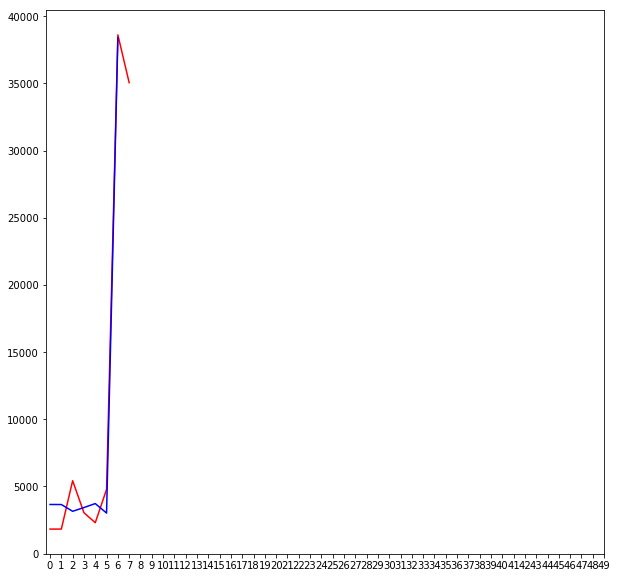


Time Taken :  2.7968902587890625

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Mar
Number of days present :  31
From the loop :  (743, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2014-03-01 00:00:00-06      0.15     3.85  7.61667  2959.43  565.383   
1  2014-03-02 00:00:00-06      0.05  10.9833  6.41667    12841  1079.72   
2  2014-03-03 00:00:00-06      0.05     36.5  8.63333  51449.6  2732.72   
3  2014-03-04 00:00:00-06         0    29.75  5.88333  38064.5  3116.27   
4  2014-03-05 00:00:00-06  0.383333    22.95  4.58333  31133.9   2331.7   

  waterheater1 total_thermal_load  
0      4640.92            8177.35  
1      3575.13            17513.3  
2      4463.68            58691.2  
3       3351.7            44568.1  
4      2352.88            35846.4  
(30, 8)
Inside extra trees :  (30, 8)
mean : 12627.1

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 58691.18333333334 min: 1859.5333333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8177.35
1  NaN    NaN      NaN      NaN  8177.35  17513.3
2  NaN    NaN      NaN  8177.35  17513.3  58691.2
3  3.0    1.0  8177.35  17513.3  58691.2  44568.1
4  3.0    1.0  17513.3  58691.2  44568.1  35846.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.738612)
2. feature 3 (0.149566)
3. feature 2 (0.111822)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.398052987907
RMSE :  4569.10759541
MAE :  3942.76512963


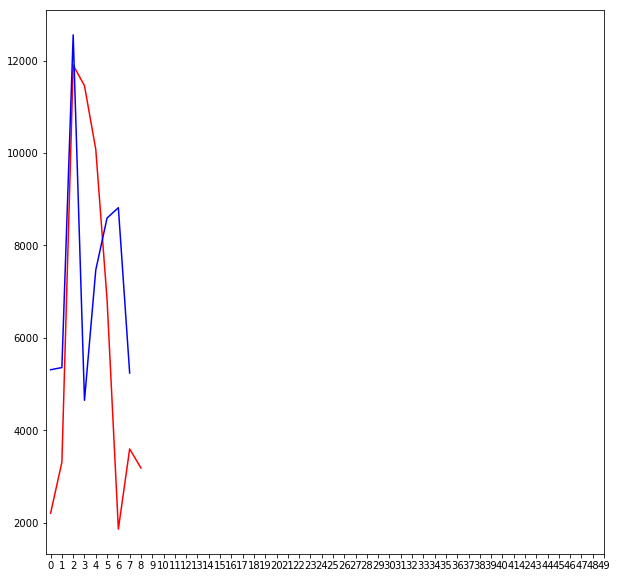


Time Taken :  2.8091282844543457

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Apr
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2014-04-01 00:00:00-05   2910.8       0.4  839.417  294.767    118.5   
1  2014-04-02 00:00:00-05  2256.83  0.966667   2510.5  722.867    118.9   
2  2014-04-03 00:00:00-05  3759.17  0.516667  1890.38  544.833   118.45   
3  2014-04-04 00:00:00-05      0.4      0.85     3.25    120.5  119.917   
4  2014-04-05 00:00:00-05     0.65   2.73333  3.36667   2282.2   120.25   

  waterheater1 total_thermal_load  
0       1884.7            6048.58  
1      3685.63             9295.7  
2      2096.37            8409.72  
3      1973.88             2218.8  
4      2158.65            4567.85  
(29, 8)
Inside extra trees :  (29, 8)
mean : 5383.96

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 21262.666666666668 min: 1005.0333333333332
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  6048.58
1  NaN    NaN      NaN      NaN  6048.58   9295.7
2  NaN    NaN      NaN  6048.58   9295.7  8409.72
3  3.0    1.0  6048.58   9295.7  8409.72   2218.8
4  3.0    1.0   9295.7  8409.72   2218.8  4567.85
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 3 (0.403864)
2. feature 4 (0.336628)
3. feature 2 (0.259509)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 1 2] 



R2 Score :  -0.536678233622
RMSE :  3307.37640322
MAE :  2708.12690417


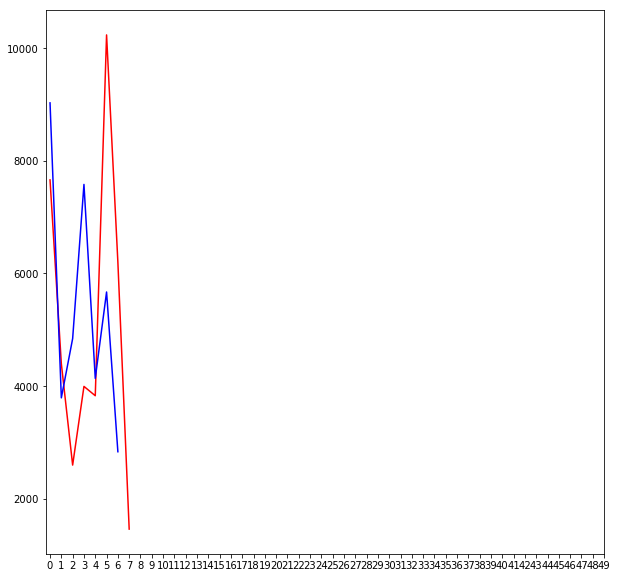


Time Taken :  2.8082826137542725

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  May
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2014-05-01 00:00:00-05        0      0.45  2.01667  120.067  120.017   
1  2014-05-02 00:00:00-05      0.3  0.316667  1.21667  121.167  119.933   
2  2014-05-03 00:00:00-05      0.3  0.816667   601.05  250.983  119.967   
3  2014-05-04 00:00:00-05      0.1   1.21667  1918.03    508.8  120.083   
4  2014-05-05 00:00:00-05  1232.22      0.65   2145.2  583.467  119.433   

  waterheater1 total_thermal_load  
0      1163.35             1405.9  
1      791.183            1034.12  
2       771.85            1744.97  
3      2694.58            5242.82  
4      1358.83             5439.8  
(30, 8)
Inside extra trees :  (30, 8)
mean : 4246.78

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   1405.9
1  NaN    NaN      NaN      NaN   1405.9  1034.12
2  NaN    NaN      NaN   1405.9  1034.12  1744.97
3  3.0    1.0   1405.9  1034.12  1744.97  5242.82
4  3.0    1.0  1034.12  1744.97  5242.82   5439.8
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.409515)
2. feature 3 (0.356121)
3. feature 2 (0.234364)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.600803529381
RMSE :  3396.11863228
MAE :  2615.27114444


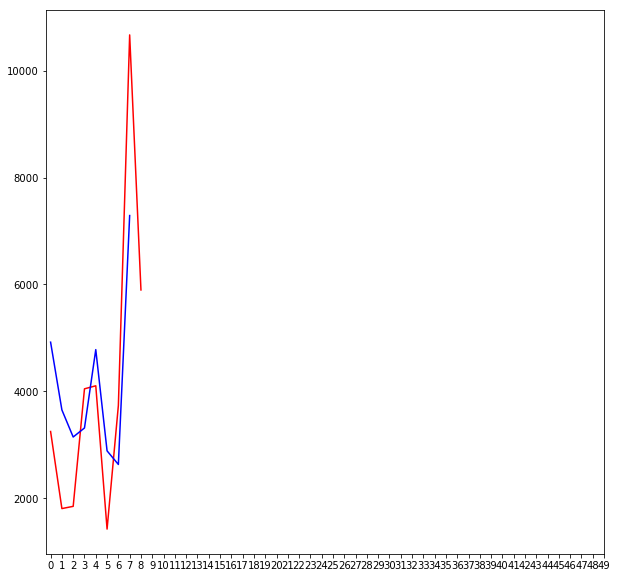


Time Taken :  2.8597962856292725

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jun
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2014-06-01 00:00:00-05  3983.83         0  2875.67  714.733    118.1   
1  2014-06-02 00:00:00-05  4874.05         0  3267.03  785.067  117.867   
2  2014-06-03 00:00:00-05  7592.33         0   3557.4  851.783  116.633   
3  2014-06-04 00:00:00-05  6617.25      0.05  2961.42  730.467    117.1   
4  2014-06-05 00:00:00-05  10438.2  0.566667  2857.37  711.483  115.167   

  waterheater1 total_thermal_load  
0       428.75            8121.08  
1       880.75            9924.77  
2      420.383            12538.5  
3      863.433            11289.7  
4      858.133            14980.9  
(29, 8)
Inside extra trees :  (29, 8)
mean : 16116.9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8121.08
1  NaN    NaN      NaN      NaN  8121.08  9924.77
2  NaN    NaN      NaN  8121.08  9924.77  12538.5
3  3.0    1.0  8121.08  9924.77  12538.5  11289.7
4  3.0    1.0  9924.77  12538.5  11289.7  14980.9
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 3 (0.372223)
2. feature 4 (0.330457)
3. feature 2 (0.297320)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.0540650887087
RMSE :  3960.21166861
MAE :  3033.71438333


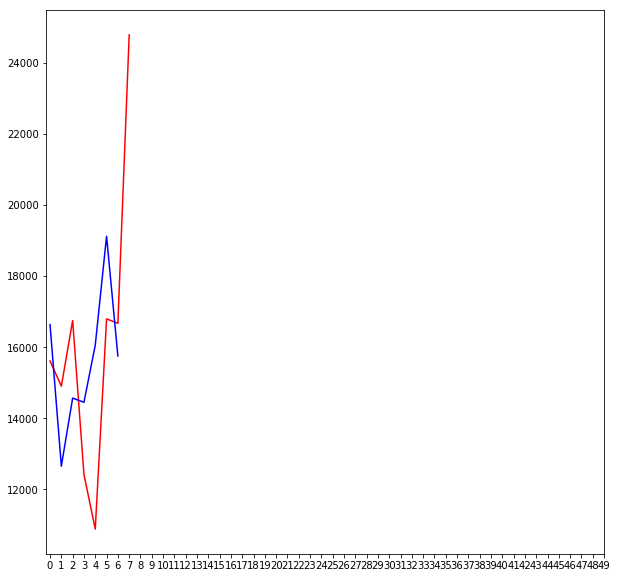


Time Taken :  2.9735424518585205

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jul
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2014-07-01 00:00:00-05  10687.9  4926.65  4846.73  1070.13  719.133   
1  2014-07-02 00:00:00-05  10852.8  2392.25  5346.08  1164.17  415.533   
2  2014-07-03 00:00:00-05  13410.9   4717.7   4246.4    967.1      764   
3  2014-07-04 00:00:00-05  9509.88  1224.73  2938.42  720.533  292.033   
4  2014-07-05 00:00:00-05   9876.3  2598.12   3204.6    772.7  475.933   

  waterheater1 total_thermal_load  
0        419.7            22670.2  
1      418.683            20589.5  
2      836.383            24942.5  
3       832.05            15517.6  
4       413.45            17341.1  
(30, 8)
Inside extra trees :  (30, 8)
mean : 24198.0583333

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 15517.649999999998
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  22670.2
1  NaN    NaN      NaN      NaN  22670.2  20589.5
2  NaN    NaN      NaN  22670.2  20589.5  24942.5
3  3.0    1.0  22670.2  20589.5  24942.5  15517.6
4  3.0    1.0  20589.5  24942.5  15517.6  17341.1
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.517021)
2. feature 2 (0.257250)
3. feature 3 (0.225729)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.46197283583
RMSE :  7240.92071603
MAE :  6436.02118519


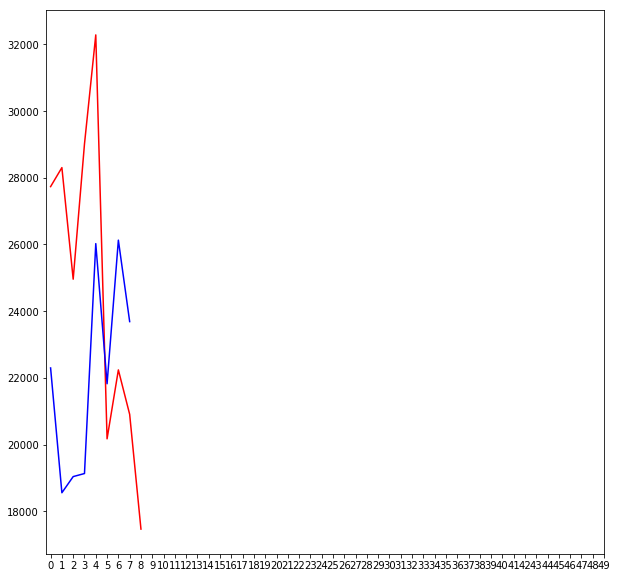


Time Taken :  2.7370104789733887

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Aug
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2014-08-01 00:00:00-05   6081.5        0  3861.18   915.15   117.35   
1  2014-08-02 00:00:00-05  3207.57        0  2052.97  551.833  118.617   
2  2014-08-03 00:00:00-05   5866.1        0  3895.45    894.6  117.433   
3  2014-08-04 00:00:00-05  8449.67   443.95  4855.18  1091.28  172.133   
4  2014-08-05 00:00:00-05  10451.2  1439.68  6236.28   1307.2  281.517   

  waterheater1 total_thermal_load  
0       432.15            11407.3  
1      875.583            6806.57  
2       853.85            11627.4  
3        419.2            15431.4  
4      412.283            20128.2  
(30, 8)
Inside extra trees :  (30, 8)
mean : 27579.6272222

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  11407.3
1  NaN    NaN      NaN      NaN  11407.3  6806.57
2  NaN    NaN      NaN  11407.3  6806.57  11627.4
3  3.0    1.0  11407.3  6806.57  11627.4  15431.4
4  3.0    1.0  6806.57  11627.4  15431.4  20128.2
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.391063)
2. feature 2 (0.329820)
3. feature 3 (0.279118)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.47115131221
RMSE :  6245.05690987
MAE :  5579.53959259


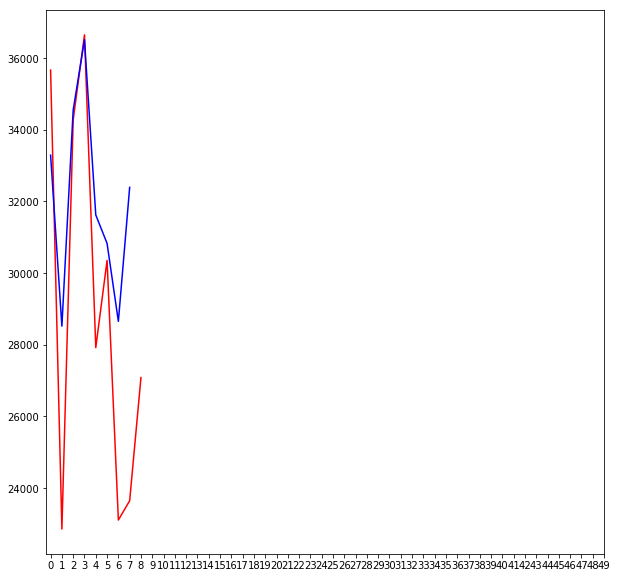


Time Taken :  2.809194326400757

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Sept
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2014-09-01 00:00:00-05    17460  3787.47  4949.05  1057.95   568.65   
1  2014-09-02 00:00:00-05  12889.8  4035.83   4489.4  991.367  629.917   
2  2014-09-03 00:00:00-05  14762.4  4278.88  4527.88   986.85  637.967   
3  2014-09-04 00:00:00-05  10091.1  3896.87  2055.85  552.467  650.483   
4  2014-09-05 00:00:00-05    10735  4435.48   3968.7    884.3    695.1   

  waterheater1 total_thermal_load  
0        769.2            28592.3  
1      390.117            23426.5  
2       807.05            26001.1  
3        783.1            18029.9  
4      407.233            21125.8  
(29, 8)
Inside extra trees :  (29, 8)
mean : 14107.5724138

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  28592.3
1  NaN    NaN      NaN      NaN  28592.3  23426.5
2  NaN    NaN      NaN  28592.3  23426.5  26001.1
3  3.0    1.0  28592.3  23426.5  26001.1  18029.9
4  3.0    1.0  23426.5  26001.1  18029.9  21125.8
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.517276)
2. feature 3 (0.316575)
3. feature 2 (0.166149)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.5981223788
RMSE :  6612.45861131
MAE :  5911.9165375


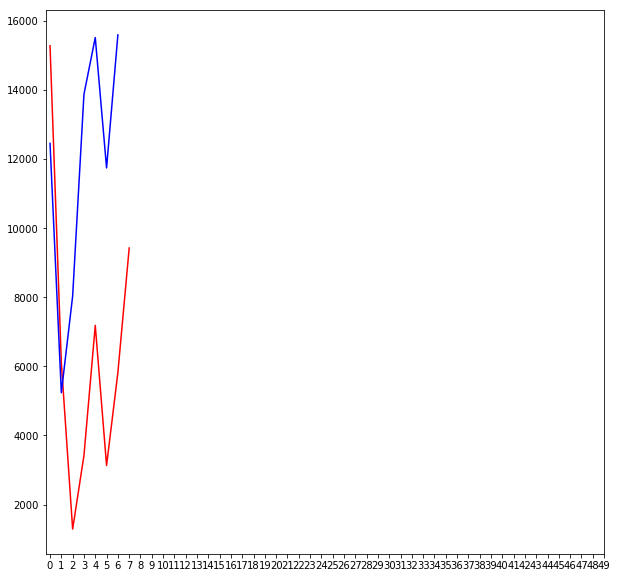


Time Taken :  2.757580280303955

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2014-10-01 00:00:00-05    10179.1    2929.4  2869.75  687.683   500.25   
1  2014-10-02 00:00:00-05    9471.15   1819.18  3039.27    720.2    348.4   
2  2014-10-03 00:00:00-05    1723.65       1.7   984.35    331.5  119.133   
3  2014-10-04 00:00:00-05  0.0666667  0.633333      1.6   120.25  119.983   
4  2014-10-05 00:00:00-05    2226.82       0.4  164.017  155.617  118.867   

  waterheater1 total_thermal_load  
0        822.6            17988.8  
1      805.383            16203.6  
2      814.117            3974.45  
3      1148.08            1390.62  
4        800.2            3465.92  
(30, 8)
Inside extra trees :  (30, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 5551.96444444 max: 20793.0 min: 1024.1499999999999
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  17988.8
1  NaN    NaN      NaN      NaN  17988.8  16203.6
2  NaN    NaN      NaN  17988.8  16203.6  3974.45
3  3.0    1.0  17988.8  16203.6  3974.45  1390.62
4  3.0    1.0  16203.6  3974.45  1390.62  3465.92
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.705126)
2. feature 3 (0.170572)
3. feature 2 (0.124302)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -10.3731385972
RMSE :  1411.38870382
MAE :  1110.09164444


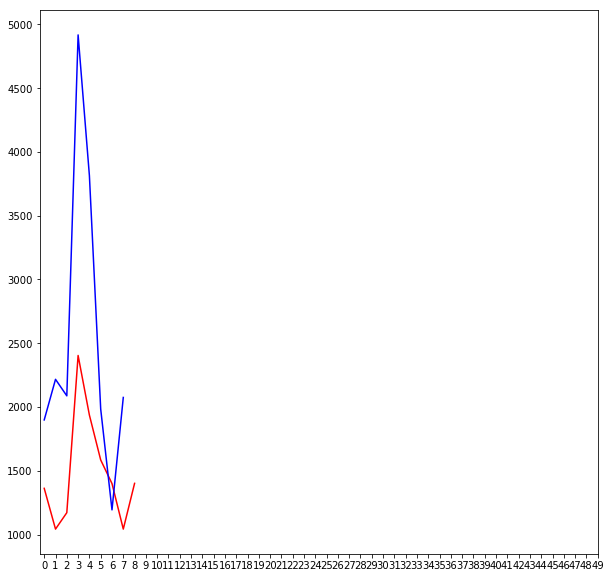


Time Taken :  2.9484004974365234

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1       air2     air3 furnace1 furnace2  \
0  2014-11-01 00:00:00-05  0.25    1.06667  2.43333  120.283    120.1   
1  2014-11-02 00:00:00-05  0.05  0.0666667  1.83333   120.25  120.033   
2  2014-11-02 23:00:00-06  0.05        0.8  1.88333  120.183  120.067   
3  2014-11-03 23:00:00-06     0   0.333333  1.93333  120.267  119.783   
4  2014-11-04 23:00:00-06  0.05   0.216667      2.2   120.05  119.917   

  waterheater1 total_thermal_load  
0      1550.65            1794.78  
1      1161.33            1403.57  
2      1182.82             1425.8  
3      1193.95            1436.27  
4       1152.8            1395.23  
(30, 8)
Inside extra trees :  (30, 8)
mean : 2346.94 max: 5366.9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.728333)
2. feature 3 (0.141756)
3. feature 2 (0.129910)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.57565282882
RMSE :  1233.74280508
MAE :  985.869388889


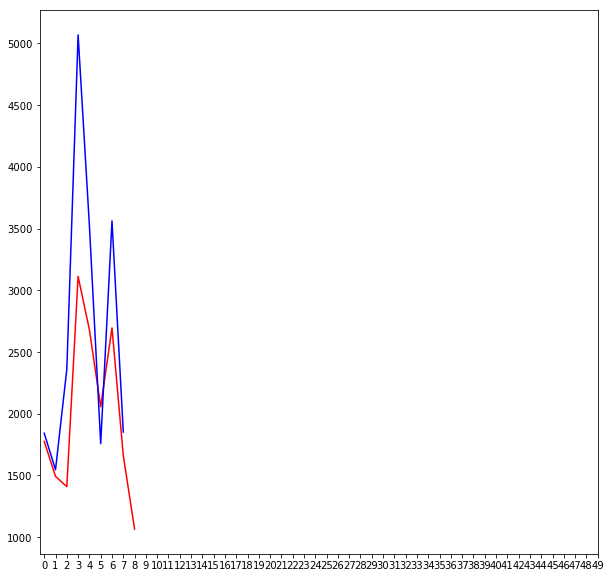


Time Taken :  2.8857438564300537

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-12-01 00:00:00-06       0.1      0.35  2.93333  120.467    209.7   
1  2014-12-02 00:00:00-06       0.1  0.133333  2.93333  120.067   2386.1   
2  2014-12-03 00:00:00-06  0.166667  0.433333  2.81667   120.35  1193.77   
3  2014-12-04 00:00:00-06       0.2  0.966667  2.13333   120.05  441.417   
4  2014-12-05 00:00:00-06         0  0.933333     1.85    120.2  119.917   

  waterheater1 total_thermal_load  
0      1594.93            1928.48  
1      1507.77             4017.1  
2      1504.82            2822.35  
3      1150.23               1715  
4      1169.23            1412.13  
(30, 8)
Inside extra trees :  (30, 8)
mean : 4

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 1412.133333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1928.48
1  NaN    NaN      NaN      NaN  1928.48   4017.1
2  NaN    NaN      NaN  1928.48   4017.1  2822.35
3  3.0    1.0  1928.48   4017.1  2822.35     1715
4  3.0    1.0   4017.1  2822.35     1715  1412.13
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.390322)
2. feature 2 (0.331965)
3. feature 3 (0.277714)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.57637622428
RMSE :  8359.39100214
MAE :  6773.98384815


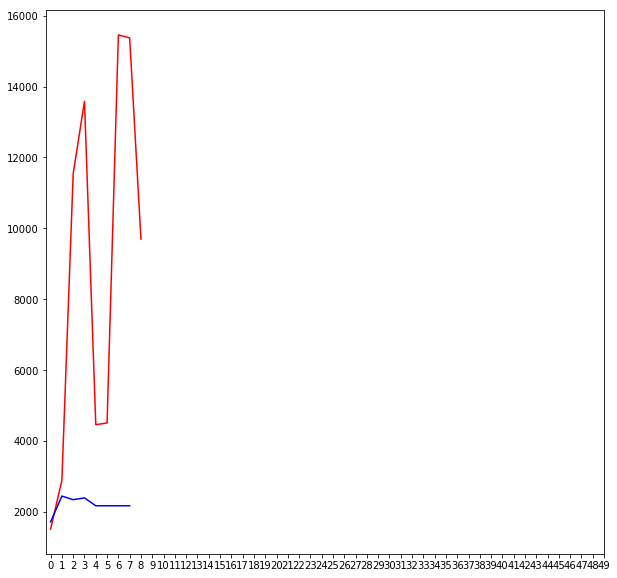


Time Taken :  2.858315944671631

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jan
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2015-01-01 00:00:00-06   1.01667  16.4833  3.48333    21111  2662.07   
1  2015-01-02 00:00:00-06      1.05    13.85  3.71667  16804.8  2458.08   
2  2015-01-03 00:00:00-06      2.05  9.68333  2.76667  6917.13  1998.75   
3  2015-01-04 00:00:00-06      0.45  3.03333  2.96667   2069.4  2204.18   
4  2015-01-05 00:00:00-06  0.616667  7.28333  3.66667  8587.27  2797.42   

  waterheater1 total_thermal_load  
0      1917.93              25712  
1      1905.55            21187.1  
2      1548.45            10478.8  
3      1558.43            5838.47  
4      1917.92            13314.2  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11170.39

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


1614.15
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    25712
1  NaN    NaN      NaN      NaN    25712  21187.1
2  NaN    NaN      NaN    25712  21187.1  10478.8
3  3.0    1.0    25712  21187.1  10478.8  5838.47
4  3.0    1.0  21187.1  10478.8  5838.47  13314.2
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.463184)
2. feature 2 (0.312346)
3. feature 3 (0.224469)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.906565506858
RMSE :  6898.72289222
MAE :  5110.26894074


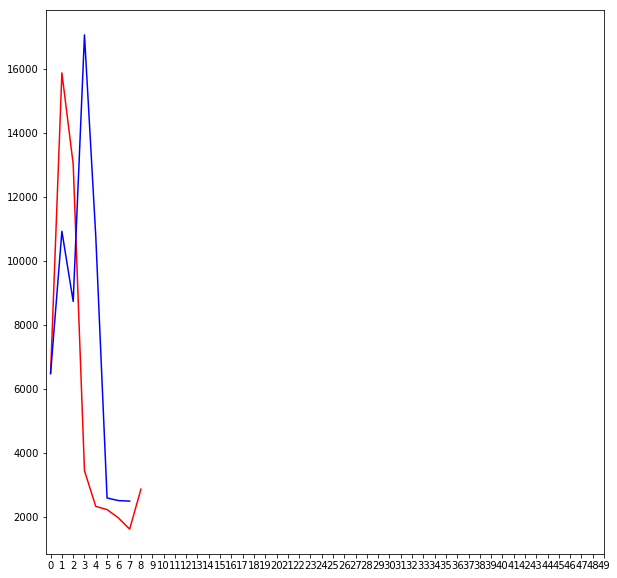


Time Taken :  2.79074764251709

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Feb
Number of days present :  28
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2015-02-01 00:00:00-06  0.133333  0.233333  3.08333    120.6  462.517   
1  2015-02-02 00:00:00-06       0.1       0.7  2.98333  120.233  1915.02   
2  2015-02-03 00:00:00-06      0.65   8.06667  3.66667  9321.18  3043.98   
3  2015-02-04 00:00:00-06       0.1   3.96667  2.96667  4765.37  2035.25   
4  2015-02-05 00:00:00-06      0.25   5.48333  3.11667  6045.45  2460.47   

  waterheater1 total_thermal_load  
0      1572.37            2158.93  
1      1534.98            3574.02  
2      1891.32            14268.9  
3      1508.55             8316.2  
4      1541.18            10055.9  
(27, 8)
Inside extra trees :  (27, 8)
mean : 718

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1234.9499999999998
Dimensions of temp :  (27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2158.93
1  NaN    NaN      NaN      NaN  2158.93  3574.02
2  NaN    NaN      NaN  2158.93  3574.02  14268.9
3  3.0    1.0  2158.93  3574.02  14268.9   8316.2
4  3.0    1.0  3574.02  14268.9   8316.2  10055.9
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.600369)
2. feature 2 (0.249212)
3. feature 3 (0.150419)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.621566201274
RMSE :  12284.6892631
MAE :  8905.18148333


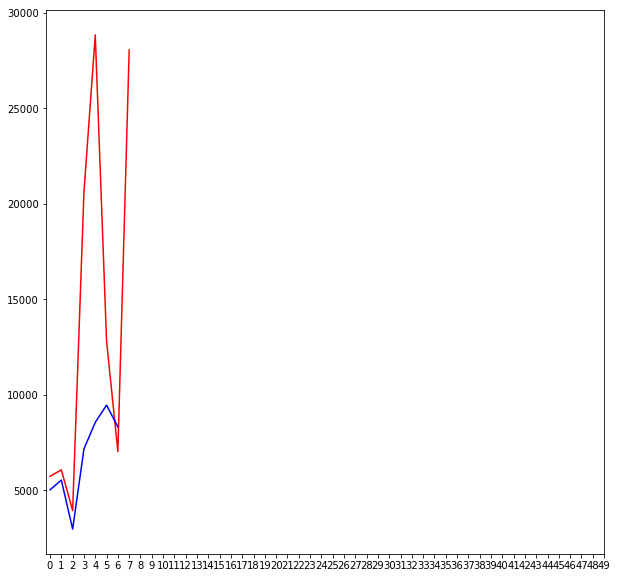


Time Taken :  2.7274997234344482

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Mar
Number of days present :  31
From the loop :  (743, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2015-03-01 00:00:00-06       0.2  19.7167  3.66667  26153.7  3546.62   
1  2015-03-02 00:00:00-06   8.63333     25.3  2.96667    20358  2336.23   
2  2015-03-03 00:00:00-06  0.816667     8.25  2.88333  10148.9  2258.57   
3  2015-03-04 00:00:00-06  0.733333      1.7  3.03333  194.367  708.133   
4  2015-03-05 00:00:00-06       2.4  17.1167      3.5  17613.6     3038   

  waterheater1 total_thermal_load  
0      1862.93            31586.8  
1      1492.12            24223.3  
2       1515.1            13934.5  
3      1551.75            2459.72  
4      1874.95            22549.6  
(30, 8)
Inside extra trees :  (30, 8)
mean : 6641.36

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  31586.8
1  NaN    NaN      NaN      NaN  31586.8  24223.3
2  NaN    NaN      NaN  31586.8  24223.3  13934.5
3  3.0    1.0  31586.8  24223.3  13934.5  2459.72
4  3.0    1.0  24223.3  13934.5  2459.72  22549.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.407160)
2. feature 2 (0.343559)
3. feature 3 (0.249281)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.802750983342
RMSE :  435.937359979
MAE :  372.793759259


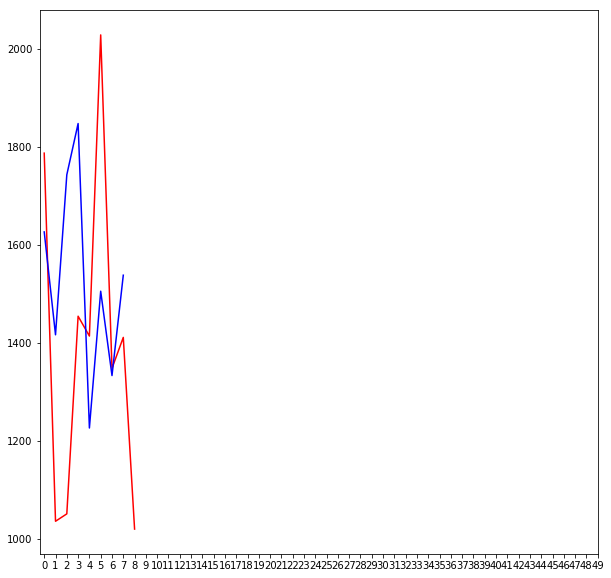


Time Taken :  2.636547088623047

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Apr
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2015-04-01 00:00:00-05       0.1       0.4      1.1  120.167   119.95   
1  2015-04-02 00:00:00-05         0      0.35  2.23333   121.25    119.9   
2  2015-04-03 00:00:00-05         0      0.75    902.3   330.85    119.8   
3  2015-04-04 00:00:00-05         0  0.366667  2.43333   122.55  119.917   
4  2015-04-05 00:00:00-05  0.116667  0.516667  5.18333  120.833  119.967   

  waterheater1 total_thermal_load  
0      751.283                993  
1      1439.85            1683.58  
2      3076.48            4430.18  
3      1454.62            1699.88  
4      3242.03            3488.65  
(29, 8)
Inside extra trees :  (29, 8)
mean : 50

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN      993
1  NaN    NaN      NaN      NaN      993  1683.58
2  NaN    NaN      NaN      993  1683.58  4430.18
3  3.0    1.0      993  1683.58  4430.18  1699.88
4  3.0    1.0  1683.58  4430.18  1699.88  3488.65
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.446027)
2. feature 3 (0.316106)
3. feature 2 (0.237867)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.216648451416
RMSE :  4113.98225407
MAE :  3153.8465875


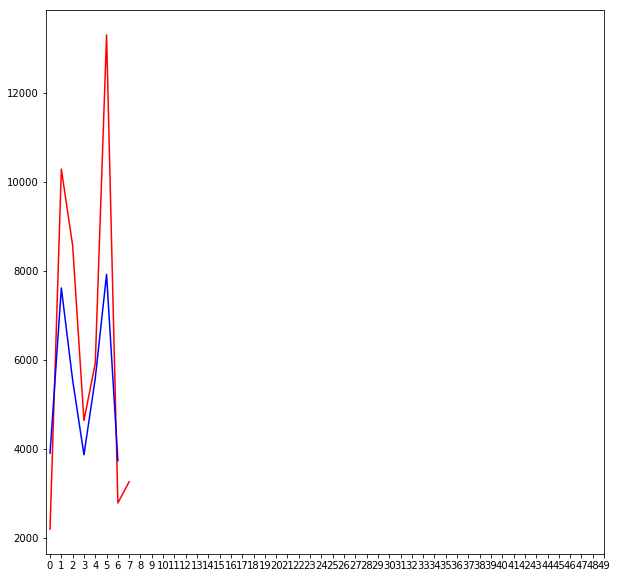


Time Taken :  2.649665594100952

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  May
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2   air3 furnace1 furnace2  \
0  2015-05-01 00:00:00-05     0.05       0.6    1.1  119.867  119.533   
1  2015-05-02 00:00:00-05        0      0.35   1.85  120.267  118.967   
2  2015-05-03 00:00:00-05     0.15  0.233333    1.2  120.067    119.8   
3  2015-05-04 00:00:00-05  961.667   969.383  444.9    216.7  268.383   
4  2015-05-05 00:00:00-05  1412.62  0.433333   1.15  120.183  119.033   

  waterheater1 total_thermal_load  
0      779.817            1020.97  
1      1257.63            1499.07  
2          815            1056.45  
3          800            3661.03  
4      834.417            2487.83  
(30, 8)
Inside extra trees :  (30, 8)
mean : 4926.55833333 max: 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


21377.033333333333 min: 1020.9666666666665
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1020.97
1  NaN    NaN      NaN      NaN  1020.97  1499.07
2  NaN    NaN      NaN  1020.97  1499.07  1056.45
3  3.0    1.0  1020.97  1499.07  1056.45  3661.03
4  3.0    1.0  1499.07  1056.45  3661.03  2487.83
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.435335)
2. feature 3 (0.290823)
3. feature 2 (0.273842)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.719472034088
RMSE :  1443.52719948
MAE :  1095.39917407


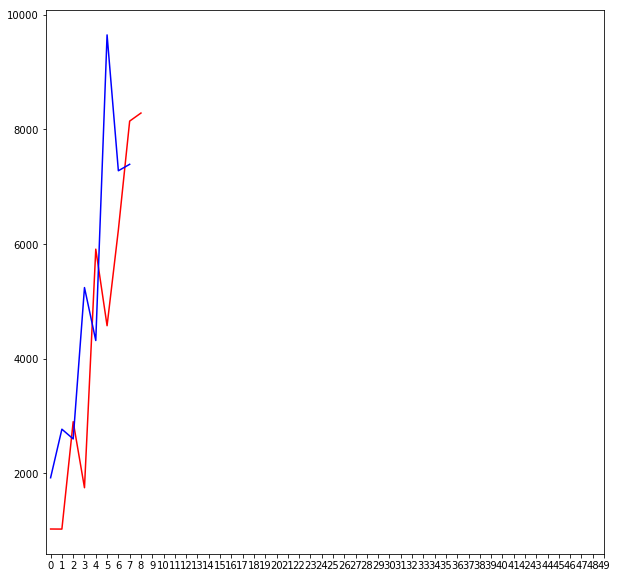


Time Taken :  2.65077805519104

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jun
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-06-01 00:00:00-05  6133.78  0.483333  2950.23  734.133  116.433   
1  2015-06-02 00:00:00-05  7137.08   1650.92  1667.75  460.383  330.933   
2  2015-06-03 00:00:00-05  8606.52   3706.65   2556.2  637.517   588.65   
3  2015-06-04 00:00:00-05  10387.9   1.51667  2607.62    643.1    114.6   
4  2015-06-05 00:00:00-05  9246.83       1.1  2750.23  675.667  114.483   

  waterheater1 total_thermal_load  
0      822.833            10757.9  
1       416.75            11663.8  
2      866.317            16961.8  
3      424.183            14178.9  
4      862.317            13650.6  
(29, 8)
Inside extra trees :  (29, 8)
mean : 14517.414

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  10757.9
1  NaN    NaN      NaN      NaN  10757.9  11663.8
2  NaN    NaN      NaN  10757.9  11663.8  16961.8
3  3.0    1.0  10757.9  11663.8  16961.8  14178.9
4  3.0    1.0  11663.8  16961.8  14178.9  13650.6
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.492480)
2. feature 3 (0.338255)
3. feature 2 (0.169265)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.814269017676
RMSE :  4593.28987436
MAE :  3657.15656667


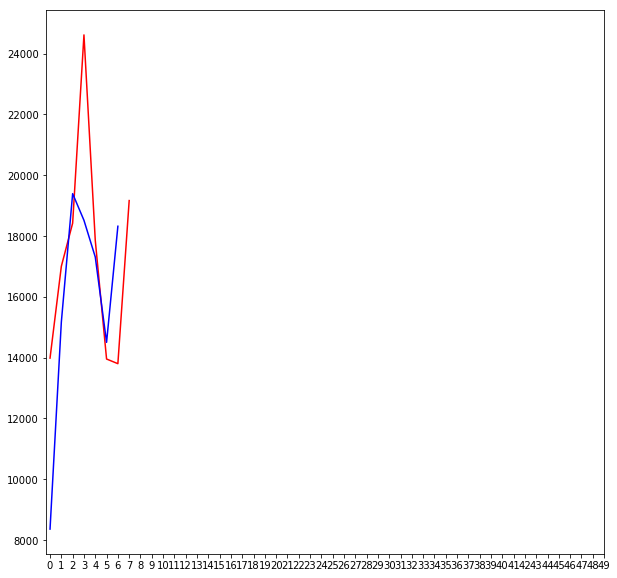


Time Taken :  2.7087502479553223

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jul
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-07-01 00:00:00-05  6639.68  2254.02  837.583  300.067  423.367   
1  2015-07-02 00:00:00-05  9214.35  1729.68  1780.57  478.967  331.933   
2  2015-07-03 00:00:00-05  12335.9  2386.75  3273.03   767.05   406.75   
3  2015-07-04 00:00:00-05  11860.1   6455.2  3008.02  725.333   917.45   
4  2015-07-05 00:00:00-05    10766  3267.92  2605.88   642.45    524.5   

  waterheater1 total_thermal_load  
0      838.683            11293.4  
1      842.483              14378  
2      854.533              20024  
3        439.6            23405.7  
4      849.317            18656.1  


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(30, 8)
Inside extra trees :  (30, 8)
mean : 22092.0172222 max: 29562.566666666666 min: 11293.4
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  11293.4
1  NaN    NaN      NaN      NaN  11293.4    14378
2  NaN    NaN      NaN  11293.4    14378    20024
3  3.0    1.0  11293.4    14378    20024  23405.7
4  3.0    1.0    14378    20024  23405.7  18656.1
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.598654)
2. feature 3 (0.210729)
3. feature 2 (0.190617)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.00788768678029
RMSE :  3254.30796201
MAE :  1492.21896667


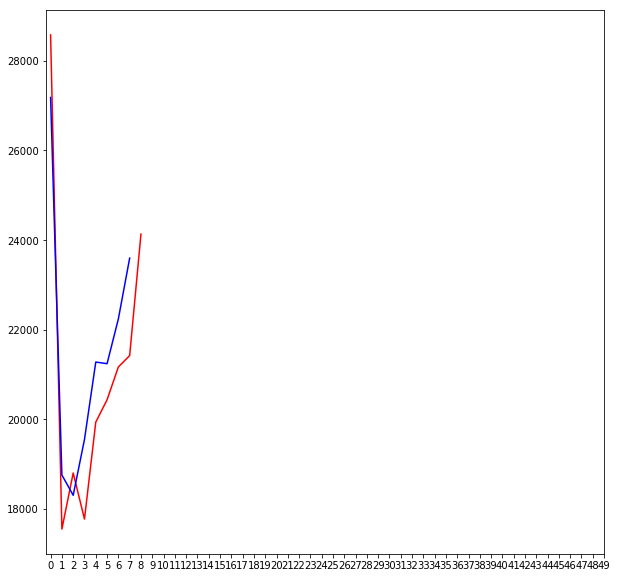


Time Taken :  2.7807440757751465

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Aug
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-08-01 00:00:00-05  10967.3  1916.28   5504.2     1160  332.267   
1  2015-08-02 00:00:00-05  10886.9  1937.55  5554.92  1151.42   330.85   
2  2015-08-03 00:00:00-05  17054.4   5883.9  5787.32  1196.93  786.017   
3  2015-08-04 00:00:00-05  19105.5  9159.17  6086.43  1269.37  1166.67   
4  2015-08-05 00:00:00-05  16533.2  8468.45  6594.83  1358.08  1081.58   

  waterheater1 total_thermal_load  
0      817.183            20697.2  
1      427.233            20288.9  
2       423.95            31132.5  
3      836.867            37624.1  
4       411.25            34447.4  
(30, 8)
Inside extra trees :  (30, 8)
mean : 34477.8211111

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  20697.2
1  NaN    NaN      NaN      NaN  20697.2  20288.9
2  NaN    NaN      NaN  20697.2  20288.9  31132.5
3  3.0    1.0  20697.2  20288.9  31132.5  37624.1
4  3.0    1.0  20288.9  31132.5  37624.1  34447.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.727002)
2. feature 3 (0.159395)
3. feature 2 (0.113603)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.303237663547
RMSE :  8721.69852125
MAE :  7337.61387407


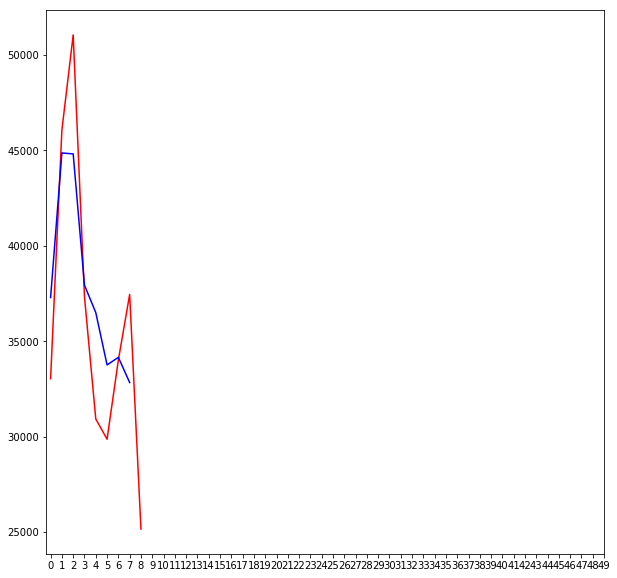


Time Taken :  2.661212205886841

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Sept
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-09-01 00:00:00-05  9293.63  4910.67  7532.17  1461.57    713.4   
1  2015-09-02 00:00:00-05  11353.4  2708.77   8614.2  1703.22  439.083   
2  2015-09-03 00:00:00-05  9465.08  3162.97  7725.18  1489.87      504   
3  2015-09-04 00:00:00-05  14975.6  3316.03  13684.3  2576.38  491.217   
4  2015-09-05 00:00:00-05  14635.9  3935.85  10911.7  2110.48  584.817   

  waterheater1 total_thermal_load  
0      2149.87            26061.3  
1       1422.9            26241.6  
2      1744.33            24091.4  
3      1358.55            36402.1  
4      1291.83            33470.6  
(29, 8)
Inside extra trees :  (29, 8)
mean : 24885.6304598

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 37211.81666666666 min: 12047.599999999999
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  26061.3
1  NaN    NaN      NaN      NaN  26061.3  26241.6
2  NaN    NaN      NaN  26061.3  26241.6  24091.4
3  3.0    1.0  26061.3  26241.6  24091.4  36402.1
4  3.0    1.0  26241.6  24091.4  36402.1  33470.6
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.549558)
2. feature 3 (0.291858)
3. feature 2 (0.158584)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.316162087594
RMSE :  4437.45482313
MAE :  2867.46954583


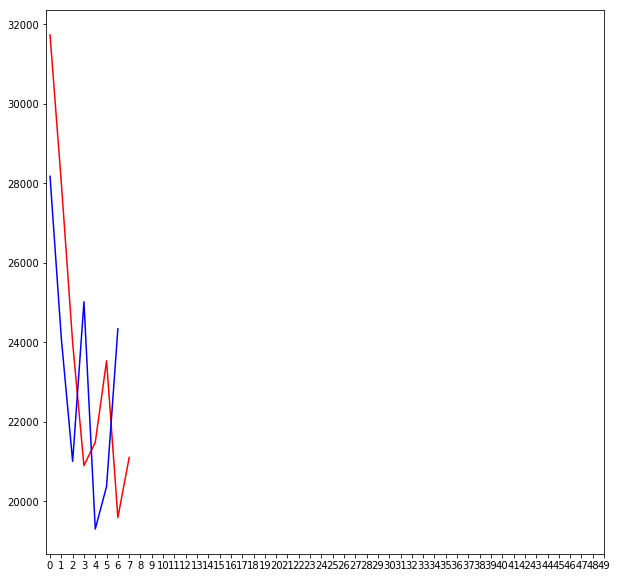


Time Taken :  2.6977779865264893

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-10-01 00:00:00-05  8420.45   5661.58  6985.62  1377.83  822.467   
1  2015-10-02 00:00:00-05  4500.18   347.933  6011.55  1373.43    168.5   
2  2015-10-03 00:00:00-05        0   12.4333  2282.32    584.8  121.767   
3  2015-10-04 00:00:00-05      0.1   1.31667  3296.93  765.367    119.7   
4  2015-10-05 00:00:00-05        0  0.683333  5969.47   1407.8  119.933   

  waterheater1 total_thermal_load  
0      1805.08              25073  
1      1358.78            13760.4  
2      2167.67            5168.98  
3      2380.57            6563.98  
4      3001.07            10498.9  
(30, 8)
Inside extra trees :  (30, 8)
mean : 12424.1

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished





 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    25073
1  NaN    NaN      NaN      NaN    25073  13760.4
2  NaN    NaN      NaN    25073  13760.4  5168.98
3  3.0    1.0    25073  13760.4  5168.98  6563.98
4  3.0    1.0  13760.4  5168.98  6563.98  10498.9
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.588238)
2. feature 2 (0.236093)
3. feature 3 (0.175669)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.764818825743
RMSE :  6118.62538995
MAE :  5408.4699963


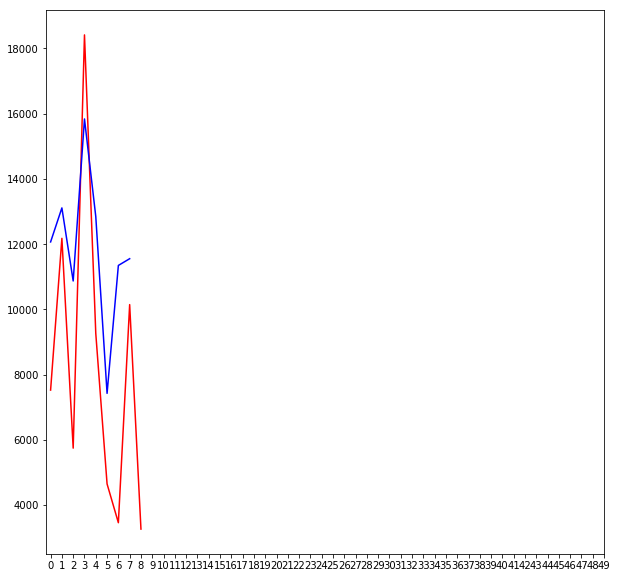


Time Taken :  2.668779134750366

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-11-01 00:00:00-05        0      0.5  3.71667  123.133  120.033   
1  2015-11-01 23:00:00-06      0.1     1.15  5.56667  122.833  120.067   
2  2015-11-02 23:00:00-06     0.15  2.33333  1189.98  364.067   119.85   
3  2015-11-03 23:00:00-06      0.2  1.08333  3.81667  126.817  120.233   
4  2015-11-04 23:00:00-06  2459.43  1.33333  3458.92    786.9    158.6   

  waterheater1 total_thermal_load  
0      2281.35            2528.73  
1      3584.72            3834.43  
2      2680.37            4356.75  
3       2618.3            2870.45  
4         3021            9886.18  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11675.1177778 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


61609.80000000001 min: 2261.1333333333328
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2528.73
1  NaN    NaN      NaN      NaN  2528.73  3834.43
2  NaN    NaN      NaN  2528.73  3834.43  4356.75
3  3.0    1.0  2528.73  3834.43  4356.75  2870.45
4  3.0    1.0  3834.43  4356.75  2870.45  9886.18
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.417172)
2. feature 2 (0.310290)
3. feature 3 (0.272538)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.840671909979
RMSE :  25393.5912753
MAE :  19043.9119963


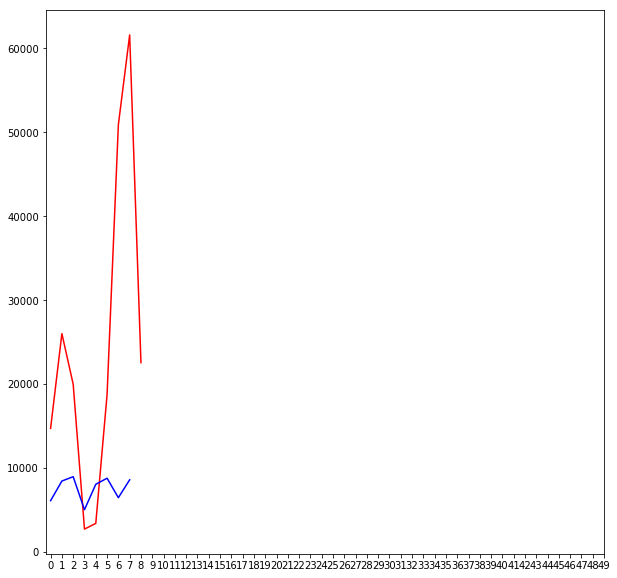


Time Taken :  2.744957447052002

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2015-12-01 00:00:00-06   0.3  23.1167  7.31667  29806.6  1065.98   
1  2015-12-02 00:00:00-06  0.95     16.2     5.75  17846.9   874.45   
2  2015-12-03 00:00:00-06   0.3    14.45  8.06667  17980.5  1692.07   
3  2015-12-04 00:00:00-06   0.2  17.4167  5.41667  21984.9  1618.07   
4  2015-12-05 00:00:00-06   0.2  21.8167      4.7  29337.2  1620.57   

  waterheater1 total_thermal_load  
0      3701.85            34605.1  
1       3650.2            22394.4  
2      4261.63              23957  
3      3066.93              26693  
4      2553.37            33537.9  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11657.5905556 max: 34605.1166666

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  34605.1
1  NaN    NaN      NaN      NaN  34605.1  22394.4
2  NaN    NaN      NaN  34605.1  22394.4    23957
3  3.0    1.0  34605.1  22394.4    23957    26693
4  3.0    1.0  22394.4    23957    26693  33537.9
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.690602)
2. feature 3 (0.171607)
3. feature 2 (0.137791)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.24445654981
RMSE :  6981.02616946
MAE :  3276.75744074


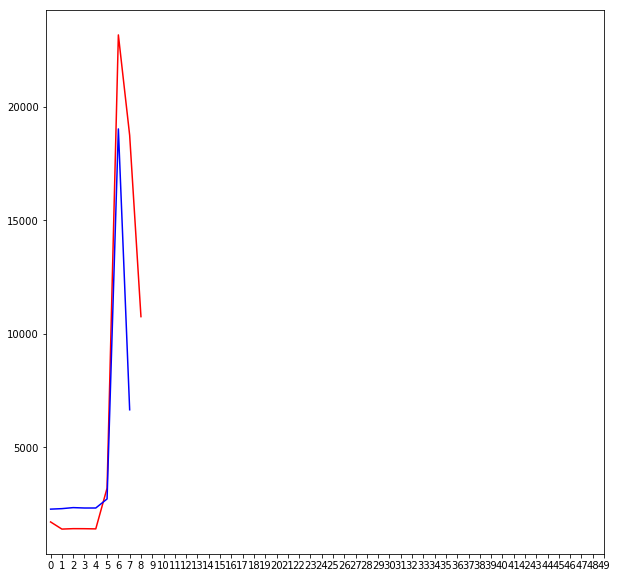


Time Taken :  2.647423505783081

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jan
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2016-01-01 00:00:00-06  0.55     12.4  3.63333  14143.2  1609.17   
1  2016-01-02 00:00:00-06   0.4  23.8667  9.23333  32048.8  2086.37   
2  2016-01-03 00:00:00-06     0    11.45      2.1  14914.6   1991.4   
3  2016-01-04 00:00:00-06   0.7  1.21667      3.5  120.317  1946.18   
4  2016-01-05 00:00:00-06  0.35      8.1  3.81667  9226.62   1975.6   

  waterheater1 total_thermal_load  
0      1918.58            17687.5  
1      4809.82            38978.4  
2      1286.83            18206.3  
3      2177.35            4249.27  
4       2148.1            13362.6  
(30, 8)
Inside extra trees :  (30, 8)
mean : 18101.9138889

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 38978.433333333334 min: 1626.1166666666666
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  17687.5
1  NaN    NaN      NaN      NaN  17687.5  38978.4
2  NaN    NaN      NaN  17687.5  38978.4  18206.3
3  3.0    1.0  17687.5  38978.4  18206.3  4249.27
4  3.0    1.0  38978.4  18206.3  4249.27  13362.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.406295)
2. feature 4 (0.373259)
3. feature 3 (0.220446)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.756255214121
RMSE :  12263.289641
MAE :  10645.5501259


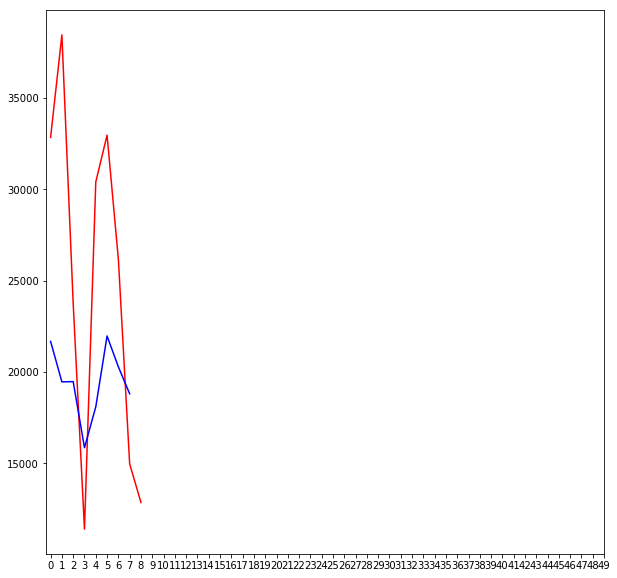


Time Taken :  2.641840934753418

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Feb
Number of days present :  29
From the loop :  (696, 8)
End i:  28
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-02-01 00:00:00-06     0.15      4.5  1668.17  521.333  150.333   
1  2016-02-02 00:00:00-06  1.68333  3.28333  9.51667  123.467    362.9   
2  2016-02-03 00:00:00-06     1.25  12.2833  8.98333  13983.4  1307.28   
3  2016-02-04 00:00:00-06      1.3  17.9833  10.7167    22460  1192.97   
4  2016-02-05 00:00:00-06     0.35  17.0167  6.81667  22816.1     2026   

  waterheater1 total_thermal_load  
0      4350.98            6695.47  
1       5300.6            5801.45  
2      4840.42            20153.6  
3      6090.05              29773  
4      4062.53            28928.9  
(28, 8)
Inside extra trees :  (28, 8)
mean : 11851.1559524 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1420.183333333333
Dimensions of temp :  (28, 2)


 Dimensions of ndf :  (28, 4)
Shape of ndf after merging :  (28, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  6695.47
1  NaN    NaN      NaN      NaN  6695.47  5801.45
2  NaN    NaN      NaN  6695.47  5801.45  20153.6
3  3.0    1.0  6695.47  5801.45  20153.6    29773
4  3.0    1.0  5801.45  20153.6    29773  28928.9
(25, 5) (25,)
        dow  month
count  25.0   25.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (17, 5) (8, 5) (17,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.720711)
2. feature 3 (0.173992)
3. feature 2 (0.105296)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.397386497708
RMSE :  5126.55634947
MAE :  2745.02936667


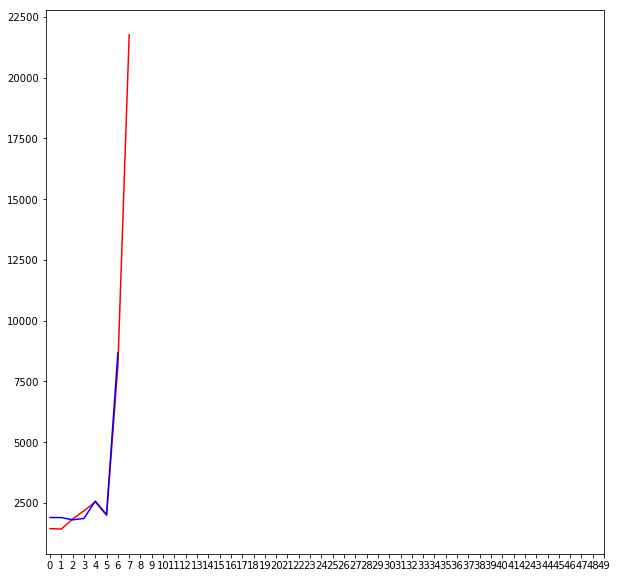


Time Taken :  2.671377182006836

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Mar
Number of days present :  31
From the loop :  (743, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2016-03-01 00:00:00-06  0.183333  2.51667  2902.65  774.883      120   
1  2016-03-02 00:00:00-06   1.03333  6.53333  1708.68  2630.95    120.3   
2  2016-03-03 00:00:00-06         0  1.88333  2225.97  621.133   119.95   
3  2016-03-04 00:00:00-06         0  3.51667    980.1  2575.15   119.95   
4  2016-03-05 00:00:00-06       0.1  2.76667  4274.43  4081.62  120.017   

  waterheater1 total_thermal_load  
0      7708.28            11508.5  
1      9264.02            13731.5  
2      5712.33            8681.27  
3       3116.3            6795.02  
4      6945.45            15424.4  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11239.15

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  11508.5
1  NaN    NaN      NaN      NaN  11508.5  13731.5
2  NaN    NaN      NaN  11508.5  13731.5  8681.27
3  3.0    1.0  11508.5  13731.5  8681.27  6795.02
4  3.0    1.0  13731.5  8681.27  6795.02  15424.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.412505)
2. feature 2 (0.304394)
3. feature 3 (0.283100)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.94678486212
RMSE :  10621.2087303
MAE :  8302.40558148


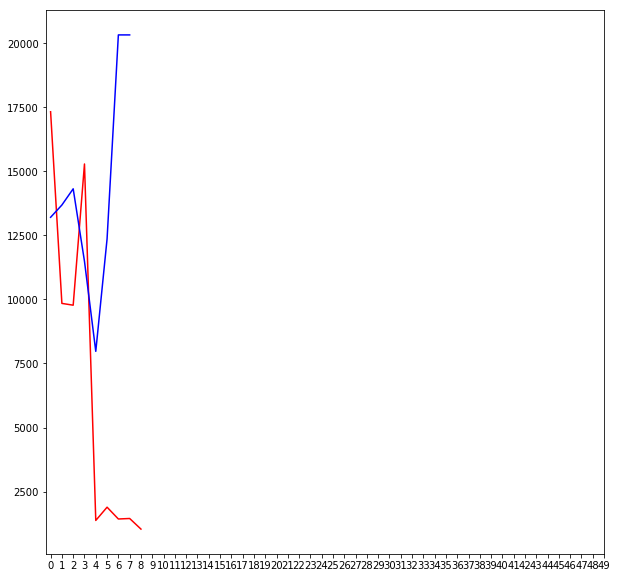


Time Taken :  2.7505078315734863

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Apr
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2016-04-01 00:00:00-05       0.3  0.783333  2.48333    125.9   120.15   
1  2016-04-02 00:00:00-05       0.5   1.18333  1.68333  126.233  909.867   
2  2016-04-03 00:00:00-05  0.333333   2.48333      1.3  123.817   119.85   
3  2016-04-04 00:00:00-05      0.15   1.23333  1421.08    448.2  119.867   
4  2016-04-05 00:00:00-05       0.1   4.26667  1272.32   3372.2  120.217   

  waterheater1 total_thermal_load  
0      1556.53            1806.15  
1      1079.72            2119.18  
2      882.183            1129.97  
3      2889.93            4880.47  
4      4528.38            9297.48  
(29, 8)
Inside extra trees :  (29, 8)
mean : 9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 1129.966666666667
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1806.15
1  NaN    NaN      NaN      NaN  1806.15  2119.18
2  NaN    NaN      NaN  1806.15  2119.18  1129.97
3  3.0    1.0  1806.15  2119.18  1129.97  4880.47
4  3.0    1.0  2119.18  1129.97  4880.47  9297.48
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 3 (0.375271)
2. feature 2 (0.347845)
3. feature 4 (0.276884)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.09369098395
RMSE :  6990.34152318
MAE :  6036.77615


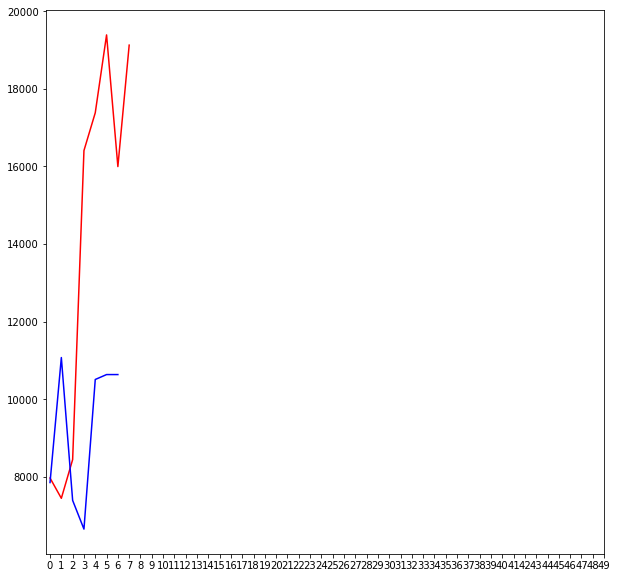


Time Taken :  2.6615288257598877

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  May
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour    air1      air2     air3 furnace1 furnace2  \
0  2016-05-01 00:00:00-05  725.45   1.01667  2176.45    625.4    113.4   
1  2016-05-02 00:00:00-05   748.6   829.017  555.683  1709.68  254.067   
2  2016-05-03 00:00:00-05    0.15   4.91667   613.15  6244.27    119.8   
3  2016-05-04 00:00:00-05    0.05      0.85   1640.9  487.067   119.45   
4  2016-05-05 00:00:00-05    0.05  0.883333  3730.93  938.317  119.967   

  waterheater1 total_thermal_load  
0       5996.8            9638.52  
1      3708.87            7805.92  
2      4383.32            11365.6  
3      4658.62            6906.93  
4      3673.63            8463.78  
(30, 8)
Inside extra trees :  (30, 8)
mean : 7744.30388889

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 652.3666666666666
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  9638.52
1  NaN    NaN      NaN      NaN  9638.52  7805.92
2  NaN    NaN      NaN  9638.52  7805.92  11365.6
3  3.0    1.0  9638.52  7805.92  11365.6  6906.93
4  3.0    1.0  7805.92  11365.6  6906.93  8463.78
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.616140)
2. feature 2 (0.209749)
3. feature 3 (0.174111)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.828307384193
RMSE :  2590.98457171
MAE :  2269.39538889


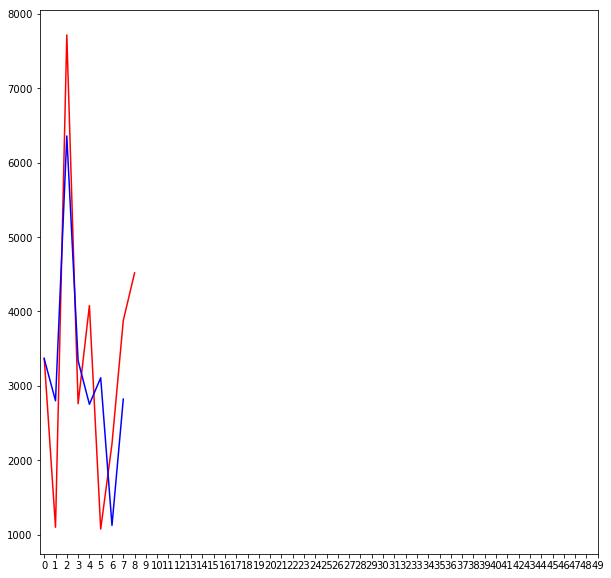


Time Taken :  2.6505184173583984

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jun
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1 air2     air3 furnace1 furnace2  \
0  2016-06-01 00:00:00-05        0    0   939.45    322.9      120   
1  2016-06-02 00:00:00-05        0    0  103.417    143.4      120   
2  2016-06-03 00:00:00-05  373.033    0  671.983  269.083    119.8   
3  2016-06-04 00:00:00-05        0    0     96.2   141.05  119.933   
4  2016-06-05 00:00:00-05    390.4    0  919.017  314.333  119.817   

  waterheater1 total_thermal_load  
0       433.25             1815.6  
1      878.017            1244.83  
2      894.383            2328.28  
3        878.9            1236.08  
4      896.433               2640  
(29, 8)
Inside extra trees :  (29, 8)
mean : 18617.1741379 max: 34263.21666666666 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


1236.0833333333333
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   1815.6
1  NaN    NaN      NaN      NaN   1815.6  1244.83
2  NaN    NaN      NaN   1815.6  1244.83  2328.28
3  3.0    1.0   1815.6  1244.83  2328.28  1236.08
4  3.0    1.0  1244.83  2328.28  1236.08     2640
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.392652)
2. feature 3 (0.309380)
3. feature 2 (0.297968)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.48400911759
RMSE :  7852.89845349
MAE :  6748.4065875


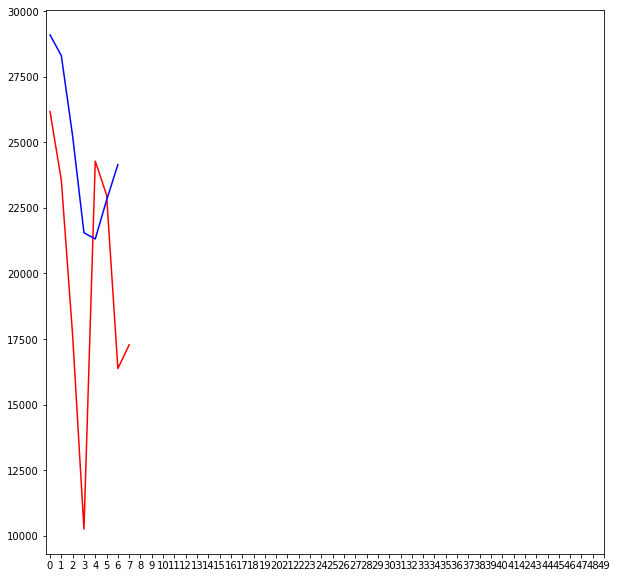


Time Taken :  2.6614770889282227

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jul
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-07-01 00:00:00-05  18489.6   373.25   4641.3   1040.7  158.717   
1  2016-07-02 00:00:00-05  11527.6  6641.85  4996.52  1115.92  905.467   
2  2016-07-03 00:00:00-05    12566  5139.87   4484.2  1019.57  728.817   
3  2016-07-04 00:00:00-05  15757.8  2280.23  5250.13  1154.47  397.867   
4  2016-07-05 00:00:00-05  18115.6  3193.03  5525.77  1198.47  485.083   

  waterheater1 total_thermal_load  
0      561.333            25264.9  
1        764.9            25952.2  
2        432.6            24371.1  
3      887.083            25727.6  
4      463.483            28981.4  
(30, 8)
Inside extra trees :  (30, 8)
mean : 28225.8622222

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  25264.9
1  NaN    NaN      NaN      NaN  25264.9  25952.2
2  NaN    NaN      NaN  25264.9  25952.2  24371.1
3  3.0    1.0  25264.9  25952.2  24371.1  25727.6
4  3.0    1.0  25952.2  24371.1  25727.6  28981.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.561879)
2. feature 3 (0.277477)
3. feature 2 (0.160644)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.187671948424
RMSE :  7058.73242039
MAE :  5796.53084444


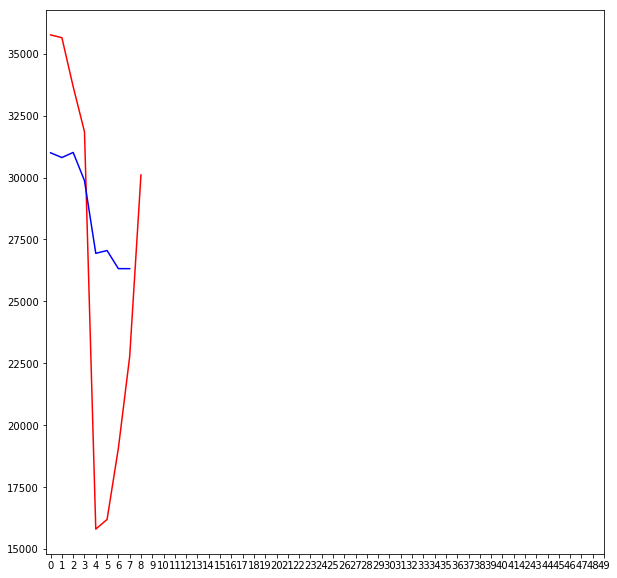


Time Taken :  2.762835741043091

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Aug
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-08-01 00:00:00-05  15045.7  5591.95  5606.37   1217.8    758.6   
1  2016-08-02 00:00:00-05  16866.1  4790.53  6243.57  1342.32  666.533   
2  2016-08-03 00:00:00-05  17683.2  7392.05  6553.27  1394.02    971.3   
3  2016-08-04 00:00:00-05  17444.7  5778.42  6476.02  1388.05  779.633   
4  2016-08-05 00:00:00-05  15958.5  6258.42  6342.97  1368.87  835.617   

  waterheater1 total_thermal_load  
0      876.133            29096.5  
1      435.467            30344.5  
2      438.417            34432.3  
3       882.45            32749.2  
4        446.7              31211  
(30, 8)
Inside extra trees :  (30, 8)
mean : 21129.9972222 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  29096.5
1  NaN    NaN      NaN      NaN  29096.5  30344.5
2  NaN    NaN      NaN  29096.5  30344.5  34432.3
3  3.0    1.0  29096.5  30344.5  34432.3  32749.2
4  3.0    1.0  30344.5  34432.3  32749.2    31211
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.578687)
2. feature 3 (0.226546)
3. feature 2 (0.194767)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.73335023768
RMSE :  6832.62815903
MAE :  5964.48664074


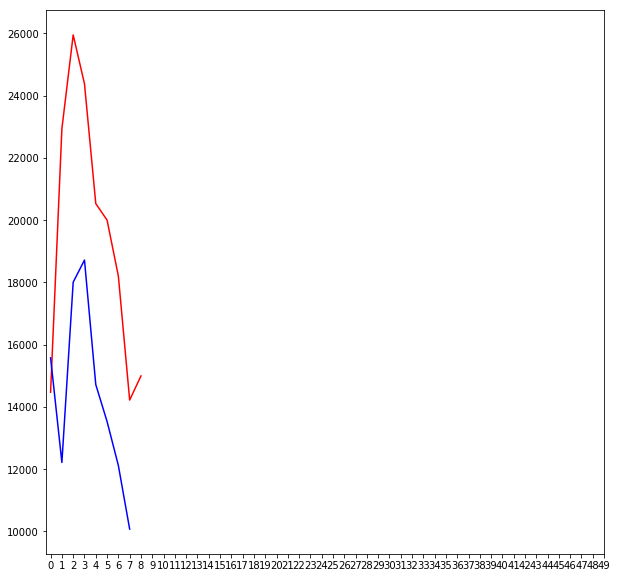


Time Taken :  2.6643130779266357

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Sept
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-09-01 00:00:00-05  7510.95        0  4006.58  921.883  116.633   
1  2016-09-02 00:00:00-05  10204.1  2830.45   2557.7    655.5  484.117   
2  2016-09-03 00:00:00-05  11416.7  1788.22   2749.4    695.4   347.45   
3  2016-09-04 00:00:00-05  10333.6  4215.83  3334.88   800.55  671.783   
4  2016-09-05 00:00:00-05    11693  1354.83  2161.55  578.783    294.8   

  waterheater1 total_thermal_load  
0          432              12988  
1      876.317            17608.1  
2      820.583            17817.7  
3      415.917            19772.5  
4      870.683            16953.6  
(29, 8)
Inside extra trees :  (29, 8)
mean : 18697.540804

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    12988
1  NaN    NaN      NaN      NaN    12988  17608.1
2  NaN    NaN      NaN    12988  17608.1  17817.7
3  3.0    1.0    12988  17608.1  17817.7  19772.5
4  3.0    1.0  17608.1  17817.7  19772.5  16953.6
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.460982)
2. feature 3 (0.324008)
3. feature 2 (0.215009)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.931959433175
RMSE :  14722.9918448
MAE :  12049.8363208


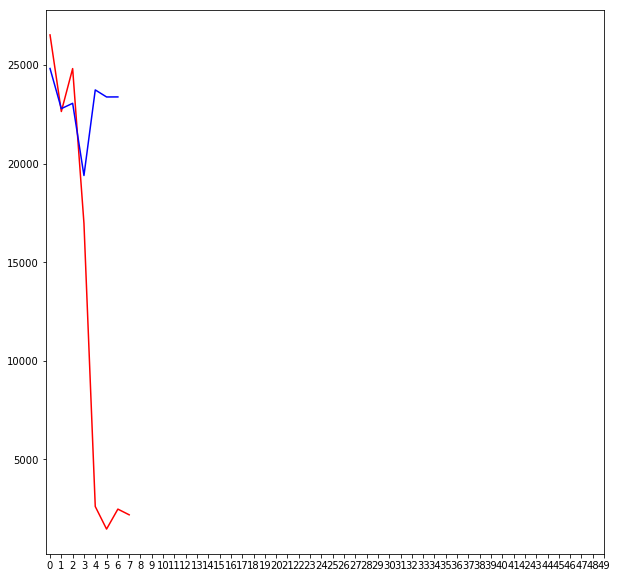


Time Taken :  2.650815010070801

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-10-01 00:00:00-05     0.15   1.31667      1.2   120.35   120.25   
1  2016-10-02 00:00:00-05      0.2  0.616667  522.683  236.883  120.067   
2  2016-10-03 00:00:00-05  1123.47      0.45  1343.58  414.533  119.333   
3  2016-10-04 00:00:00-05  7264.27       0.2  2428.83  626.917  116.717   
4  2016-10-05 00:00:00-05    11771   2875.27  4051.13  940.167  501.217   

  waterheater1 total_thermal_load  
0      824.317            1067.58  
1      807.633            1688.08  
2       1256.2            4257.57  
3        415.3            10852.2  
4      861.017            20999.8  
(30, 8)
Inside extra trees :  (30, 8)
mean : 9303.594

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


1058.25
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1067.58
1  NaN    NaN      NaN      NaN  1067.58  1688.08
2  NaN    NaN      NaN  1067.58  1688.08  4257.57
3  3.0    1.0  1067.58  1688.08  4257.57  10852.2
4  3.0    1.0  1688.08  4257.57  10852.2  20999.8
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.519662)
2. feature 3 (0.240710)
3. feature 2 (0.239628)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.23344915293
RMSE :  5218.73108108
MAE :  4425.41878889


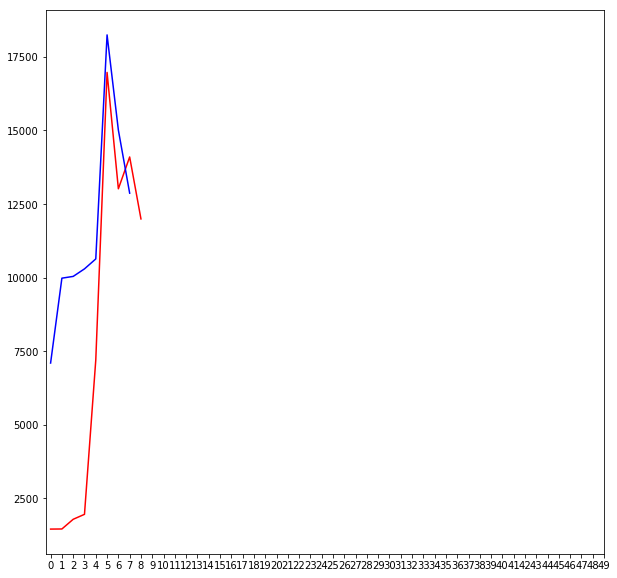


Time Taken :  2.6627182960510254

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-11-01 00:00:00-05  7912.02   2176.38  2332.62   606.85    405.3   
1  2016-11-02 00:00:00-05  6588.82   394.383   1421.5  434.317  172.833   
2  2016-11-03 00:00:00-05  2481.33   128.667      0.6   119.85  140.683   
3  2016-11-04 00:00:00-05     0.05  0.716667        2   126.75  119.967   
4  2016-11-05 00:00:00-05        0  0.733333      1.9  125.867      120   

  waterheater1 total_thermal_load  
0      835.567            14268.7  
1      821.167            9833.02  
2      830.183            3701.32  
3      1230.18            1479.67  
4       1205.1             1453.6  
(30, 8)
Inside extra trees :  (30, 8)
mean : 3403.95

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  14268.7
1  NaN    NaN      NaN      NaN  14268.7  9833.02
2  NaN    NaN      NaN  14268.7  9833.02  3701.32
3  3.0    1.0  14268.7  9833.02  3701.32  1479.67
4  3.0    1.0  9833.02  3701.32  1479.67   1453.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.503600)
2. feature 2 (0.288028)
3. feature 4 (0.208373)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.288608276322
RMSE :  1535.59231399
MAE :  1314.56055926


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


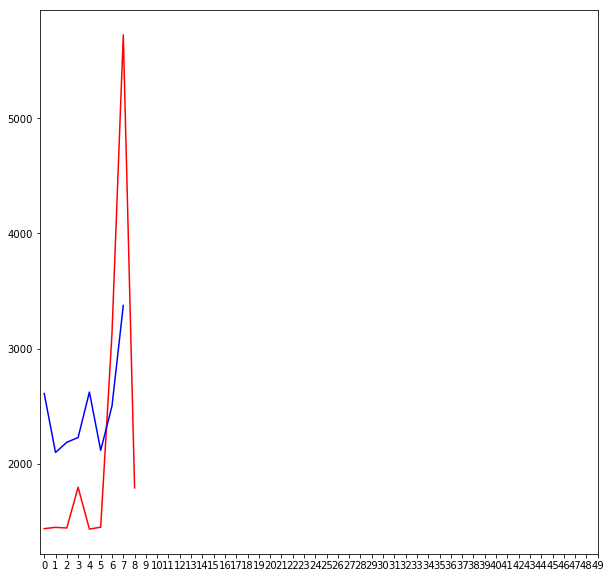


Time Taken :  2.754490375518799

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2016-12-01 00:00:00-06  0.366667  0.833333     2.25    120.5  1056.57   
1  2016-12-02 00:00:00-06       0.3      2.15      1.8  120.383   868.45   
2  2016-12-03 00:00:00-06      0.95   4.08333     2.25   120.35  1076.93   
3  2016-12-04 00:00:00-06         0      0.35      2.3   120.45  1298.05   
4  2016-12-05 00:00:00-06   1.46667       2.8  2.21667  120.083  1201.48   

  waterheater1 total_thermal_load  
0      1588.45            2768.97  
1      1200.17            2193.25  
2      1603.17            2807.73  
3      1591.07            3012.22  
4      1570.03            2898.08  
(30, 8)
Inside extra trees :  (30, 8)
mean : 91

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2768.97
1  NaN    NaN      NaN      NaN  2768.97  2193.25
2  NaN    NaN      NaN  2768.97  2193.25  2807.73
3  3.0    1.0  2768.97  2193.25  2807.73  3012.22
4  3.0    1.0  2193.25  2807.73  3012.22  2898.08
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.490303)
2. feature 2 (0.291988)
3. feature 3 (0.217709)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -2.34173740264
RMSE :  8853.08853282
MAE :  7696.7232037


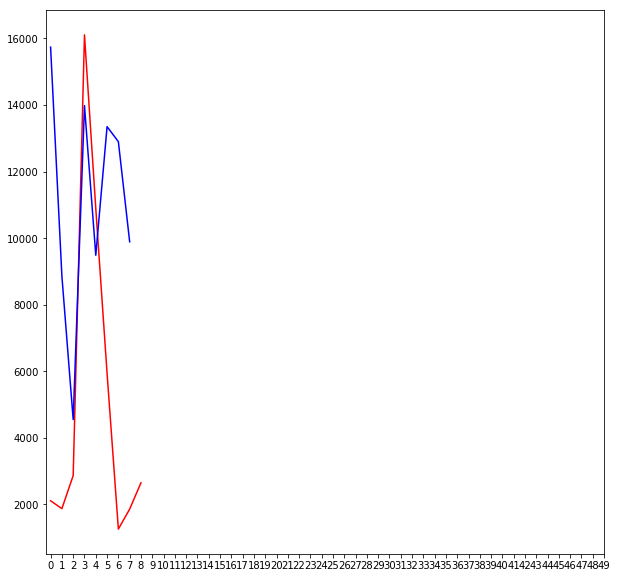


Time Taken :  2.7003045082092285

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jan
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2017-01-01 00:00:00-06         0     5.45     1.75  120.317  150.333   
1  2017-01-02 00:00:00-06       0.3  3.58333      1.7  120.317  120.117   
2  2017-01-03 00:00:00-06  0.466667      2.4      1.7  120.283   212.55   
3  2017-01-04 00:00:00-06      1.15  2.66667  3.21667  126.467  1312.52   
4  2017-01-05 00:00:00-06  0.716667  8.26667  2.31667   9340.3  1737.62   

  waterheater1 total_thermal_load  
0      1205.92            1483.77  
1      1214.35            1460.37  
2      1214.38            1551.78  
3      2019.93            3465.95  
4      1544.15            12633.4  
(30, 8)
Inside extra trees :  (30, 8)
mean : 15448.8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1460.3666666666663
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1483.77
1  NaN    NaN      NaN      NaN  1483.77  1460.37
2  NaN    NaN      NaN  1483.77  1460.37  1551.78
3  3.0    1.0  1483.77  1460.37  1551.78  3465.95
4  3.0    1.0  1460.37  1551.78  3465.95  12633.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.514416)
2. feature 2 (0.255770)
3. feature 3 (0.229813)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.232408441864
RMSE :  11037.7205164
MAE :  9278.04689259


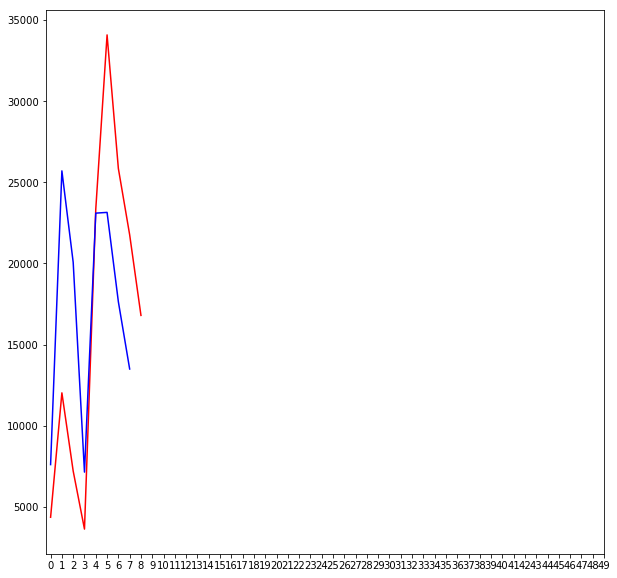


Time Taken :  2.712509870529175

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Feb
Number of days present :  28
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2017-02-01 00:00:00-06   1.53333  5.38333  4.81667  4659.68  433.633   
1  2017-02-02 00:00:00-06         0  9.76667  5.88333  12466.9  667.333   
2  2017-02-03 00:00:00-06   1.03333    23.55  5.36667  31761.3  1872.15   
3  2017-02-04 00:00:00-06      0.25  25.0667     2.55  32589.5  2087.07   
4  2017-02-05 00:00:00-06  0.283333     13.6  1.81667  13839.7  1049.58   

  waterheater1 total_thermal_load  
0      2941.12            8046.17  
1      3559.13              16709  
2         3098            36761.4  
3      1516.73            36221.2  
4      1168.47            16073.5  
(27, 8)
Inside extra trees :  (27, 8)
mean : 9471.270

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 36761.4 min: 1420.2333333333333
Dimensions of temp :  (27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8046.17
1  NaN    NaN      NaN      NaN  8046.17    16709
2  NaN    NaN      NaN  8046.17    16709  36761.4
3  3.0    1.0  8046.17    16709  36761.4  36221.2
4  3.0    1.0    16709  36761.4  36221.2  16073.5
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.710127)
2. feature 2 (0.180471)
3. feature 3 (0.109402)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -53.2454830581
RMSE :  7890.54294646
MAE :  7494.0250125


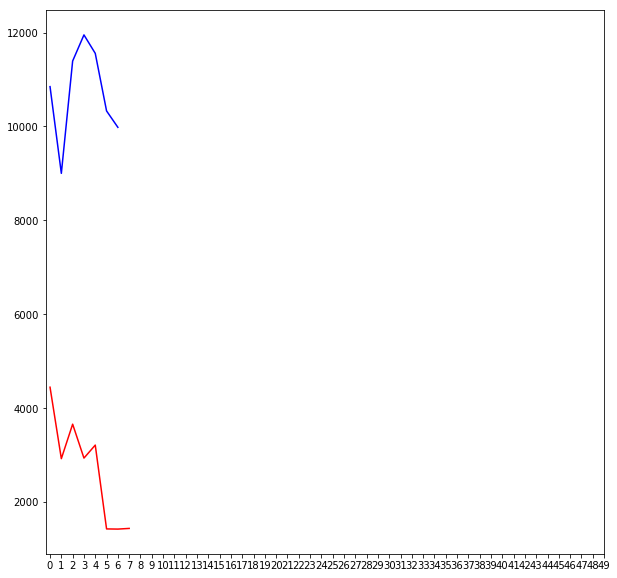


Time Taken :  2.657755136489868

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Mar
Number of days present :  31
From the loop :  (743, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-03-01 00:00:00-06  5318.95  1.36667  5.68333  122.883   117.95   
1  2017-03-02 00:00:00-06     1.05  3.01667      6.2  122.233  120.183   
2  2017-03-03 00:00:00-06      0.2  6.01667      6.2  8094.33  119.983   
3  2017-03-04 00:00:00-06  2.26667  13.6333  6.88333  15963.3   356.85   
4  2017-03-05 00:00:00-06        0  5.18333    379.4  7237.38    395.5   

  waterheater1 total_thermal_load  
0      2813.05            8379.88  
1      3058.15            3310.83  
2      2970.67            11197.4  
3       3217.6            19560.5  
4      2964.52              10982  
(30, 8)
Inside extra trees :  (30, 8)
mean : 4704.34555556 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8379.88
1  NaN    NaN      NaN      NaN  8379.88  3310.83
2  NaN    NaN      NaN  8379.88  3310.83  11197.4
3  3.0    1.0  8379.88  3310.83  11197.4  19560.5
4  3.0    1.0  3310.83  11197.4  19560.5    10982
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.626519)
2. feature 3 (0.215996)
3. feature 2 (0.157485)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -2.34487817565
RMSE :  3333.35807301
MAE :  2348.20414815


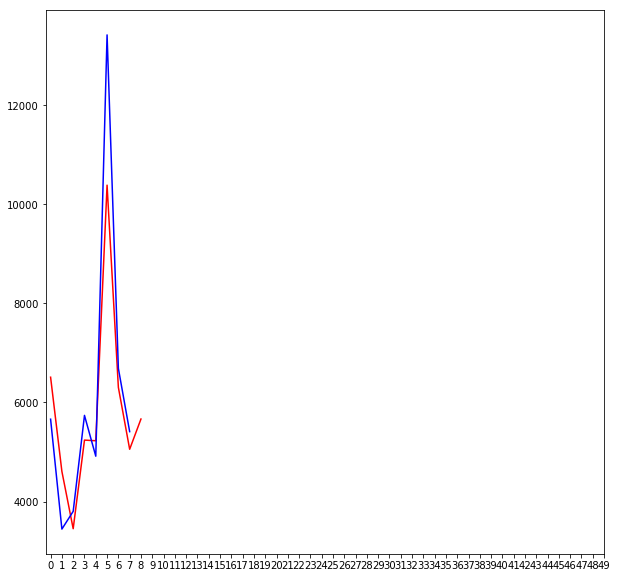


Time Taken :  2.6316657066345215

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Apr
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2017-04-01 00:00:00-05         0       0.7     2.25  120.167      120   
1  2017-04-02 00:00:00-05     726.5  0.666667      1.6  120.267    119.6   
2  2017-04-03 00:00:00-05  0.266667  0.516667     2.45   121.85  120.017   
3  2017-04-04 00:00:00-05  0.466667   1.51667  5111.75   1147.8  120.033   
4  2017-04-05 00:00:00-05  0.833333   2.13333  6.03333  120.983  119.917   

  waterheater1 total_thermal_load  
0      1169.13            1412.25  
1        809.3            1777.93  
2      1239.57            1484.67  
3      2550.27            8931.83  
4      3062.13            3312.03  
(29, 8)
Inside extra trees :  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(29, 8)
mean : 3052.40632184 max: 8931.833333333334 min: 1028.7
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1412.25
1  NaN    NaN      NaN      NaN  1412.25  1777.93
2  NaN    NaN      NaN  1412.25  1777.93  1484.67
3  3.0    1.0  1412.25  1777.93  1484.67  8931.83
4  3.0    1.0  1777.93  1484.67  8931.83  3312.03
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 3 (0.532809)
2. feature 4 (0.245863)
3. feature 2 (0.221328)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.676622620272
RMSE :  3600.74323156
MAE :  2861.70079583


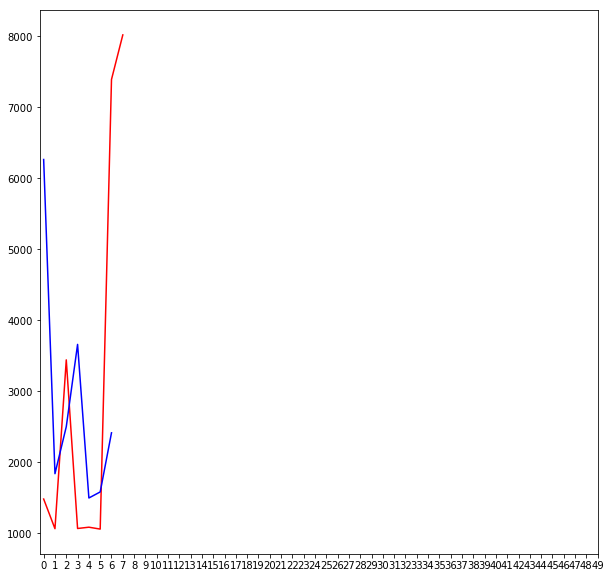


Time Taken :  2.7499887943267822

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  May
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2017-05-01 00:00:00-05   0.583333         1  2.31667  120.133  119.933   
1  2017-05-02 00:00:00-05    533.683      0.75  1.58333  120.133  119.583   
2  2017-05-03 00:00:00-05    6116.27   1.41667  1.43333   118.85  115.733   
3  2017-05-04 00:00:00-05  0.0666667  0.483333      1.8    119.9    119.8   
4  2017-05-05 00:00:00-05          0  0.266667  1.58333    120.2  119.933   

  waterheater1 total_thermal_load  
0      1219.73             1463.7  
1      812.267               1588  
2          724             7077.7  
3      928.317            1170.37  
4      823.583            1065.57  
(30, 8)
Inside extra trees :  (30, 8)
me

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished




 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month     t-3     t-2      t-1        t
0  NaN    NaN     NaN     NaN      NaN   1463.7
1  NaN    NaN     NaN     NaN   1463.7     1588
2  NaN    NaN     NaN  1463.7     1588   7077.7
3  3.0    1.0  1463.7    1588   7077.7  1170.37
4  3.0    1.0    1588  7077.7  1170.37  1065.57
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.462886)
2. feature 3 (0.272156)
3. feature 2 (0.264957)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.369989551881
RMSE :  7000.796263
MAE :  5874.00338519


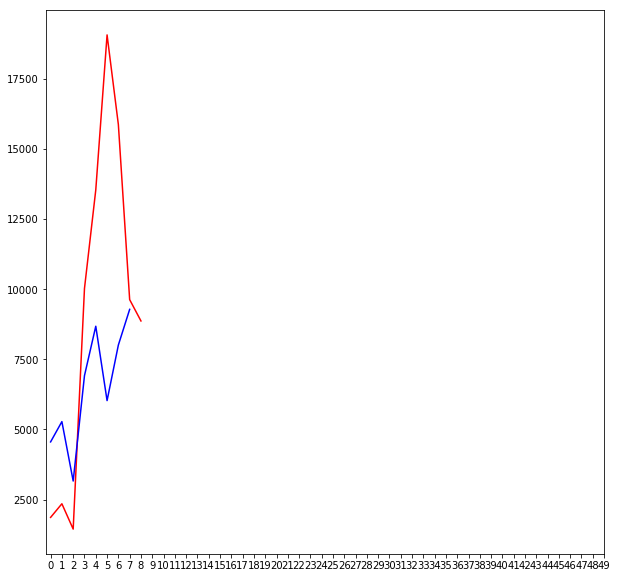


Time Taken :  2.6656746864318848

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jun
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2017-06-01 00:00:00-05  5663.55      0.05   1873.2  518.517  115.933   
1  2017-06-02 00:00:00-05  10126.4   2474.23   3670.9  884.967   435.85   
2  2017-06-03 00:00:00-05  8739.73   1071.17  3286.97  814.383  270.667   
3  2017-06-04 00:00:00-05  5644.37  0.716667  728.417  280.567  116.467   
4  2017-06-05 00:00:00-05  5639.77   1116.43  1291.18  393.267    256.7   

  waterheater1 total_thermal_load  
0      840.367            9011.62  
1          848            18440.3  
2      420.067              14603  
3      1262.72            8033.25  
4      841.367            9538.72  
(29, 8)
Inside extra trees :  (29, 8)
mean : 19102.0

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 7561.566666666666
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  9011.62
1  NaN    NaN      NaN      NaN  9011.62  18440.3
2  NaN    NaN      NaN  9011.62  18440.3    14603
3  3.0    1.0  9011.62  18440.3    14603  8033.25
4  3.0    1.0  18440.3    14603  8033.25  9538.72
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.489263)
2. feature 3 (0.285951)
3. feature 2 (0.224787)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.246684279076
RMSE :  7475.54882494
MAE :  5753.940175


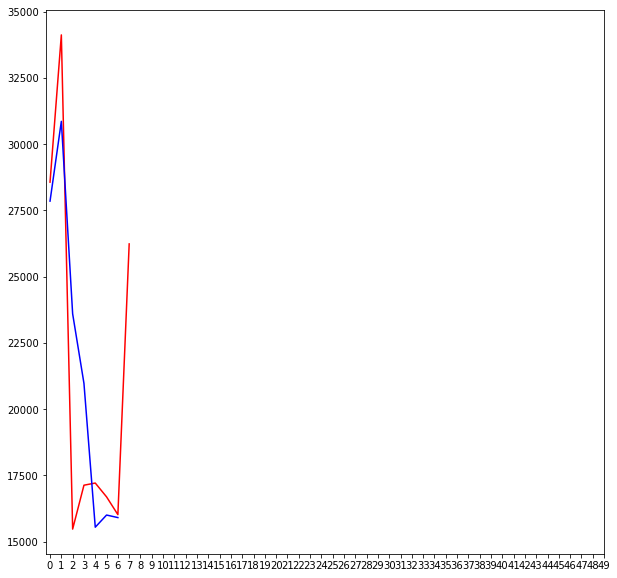


Time Taken :  2.6666324138641357

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jul
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-07-01 00:00:00-05  16379.1  5014.58  5081.02  1146.97      721   
1  2017-07-02 00:00:00-05  14697.7   6730.5  5467.57  1183.13  911.367   
2  2017-07-03 00:00:00-05  13303.2  8804.33  5188.27   1132.8  1172.78   
3  2017-07-04 00:00:00-05  14487.5  4878.32   5445.7  1171.98   688.25   
4  2017-07-05 00:00:00-05  14118.3   7386.6  5705.87  1231.97  985.067   

  waterheater1 total_thermal_load  
0        858.1            29200.8  
1      419.417            29409.6  
2      858.633            30460.1  
3          412            27083.8  
4      431.333            29859.1  
(30, 8)
Inside extra trees :  (30, 8)
mean : 31786.6716667

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 22464.85
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  29200.8
1  NaN    NaN      NaN      NaN  29200.8  29409.6
2  NaN    NaN      NaN  29200.8  29409.6  30460.1
3  3.0    1.0  29200.8  29409.6  30460.1  27083.8
4  3.0    1.0  29409.6  30460.1  27083.8  29859.1
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.436337)
2. feature 4 (0.355067)
3. feature 2 (0.208595)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.227386753713
RMSE :  4779.0197881
MAE :  4046.33652593


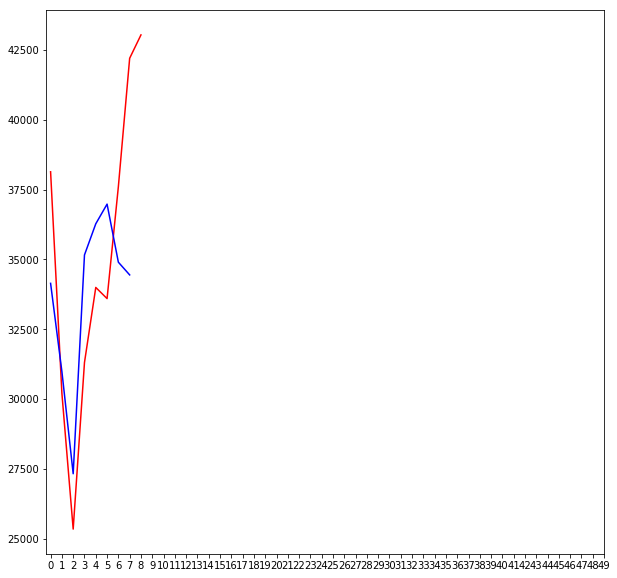


Time Taken :  2.6820287704467773

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Aug
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-08-01 00:00:00-05  15622.3   5520.9  3856.15  870.033  759.767   
1  2017-08-02 00:00:00-05    10785   1570.5  695.517  273.217    332.1   
2  2017-08-03 00:00:00-05  11051.7   4758.2   2376.3  597.967  717.867   
3  2017-08-04 00:00:00-05  12444.7  7259.48  3220.55   750.95  1006.52   
4  2017-08-05 00:00:00-05  16673.6   5300.5  4497.37   971.95  724.417   

  waterheater1 total_thermal_load  
0        834.6            27463.8  
1        825.7            14482.1  
2       405.55            19907.6  
3      851.033            25533.3  
4      420.917            28588.8  
(30, 8)
Inside extra trees :  (30, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 21852.8894444 max: 57268.93333333333 min: 3382.5333333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  27463.8
1  NaN    NaN      NaN      NaN  27463.8  14482.1
2  NaN    NaN      NaN  27463.8  14482.1  19907.6
3  3.0    1.0  27463.8  14482.1  19907.6  25533.3
4  3.0    1.0  14482.1  19907.6  25533.3  28588.8
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.570543)
2. feature 2 (0.238930)
3. feature 3 (0.190527)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -4.33529092793
RMSE :  13122.6604139
MAE :  11949.0706593


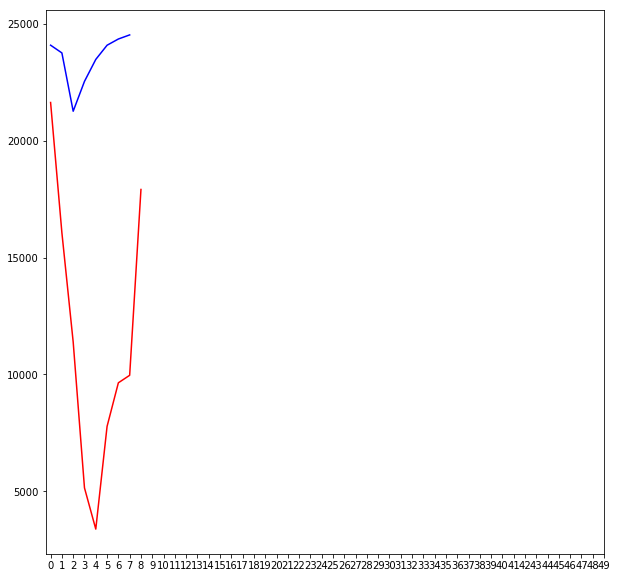


Time Taken :  2.739595651626587

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Sept
Number of days present :  30
From the loop :  (720, 8)
End i:  29
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-09-01 00:00:00-05  10636.4  5793.07   1878.7  495.833  852.733   
1  2017-09-02 00:00:00-05   9959.1  2997.77  2250.75  565.417  498.017   
2  2017-09-03 00:00:00-05    10248  5013.48  1573.88  440.933  774.033   
3  2017-09-04 00:00:00-05  9004.42  5026.97  2248.97  569.433  765.967   
4  2017-09-05 00:00:00-05  12720.3  5082.37  3080.67   719.35  735.933   

  waterheater1 total_thermal_load  
0       850.95            20507.6  
1        825.6            17096.6  
2      413.717              18464  
3      851.133            18466.9  
4      773.217            23111.8  
(29, 8)
Inside extra trees :  (29, 8)
mean : 14828.5390805

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


1495.9999999999995
Dimensions of temp :  (29, 2)


 Dimensions of ndf :  (29, 4)
Shape of ndf after merging :  (29, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  20507.6
1  NaN    NaN      NaN      NaN  20507.6  17096.6
2  NaN    NaN      NaN  20507.6  17096.6    18464
3  3.0    1.0  20507.6  17096.6    18464  18466.9
4  3.0    1.0  17096.6    18464  18466.9  23111.8
(26, 5) (26,)
        dow  month
count  26.0   26.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (8, 5) (18,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.705869)
2. feature 3 (0.168578)
3. feature 2 (0.125553)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.18606624058
RMSE :  6811.16087809
MAE :  5242.09984583


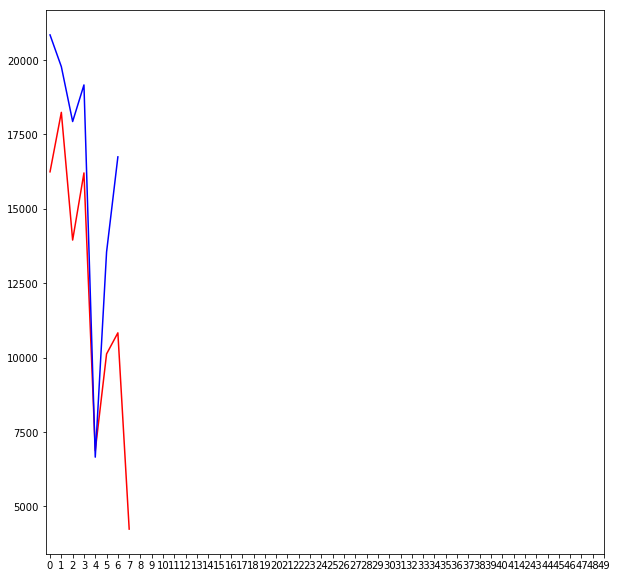


Time Taken :  2.640021324157715

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-10-01 00:00:00-05  3977.37  1485.52  1627.15  456.483   334.15   
1  2017-10-02 00:00:00-05   7745.9  2380.33  2040.43  541.567  426.867   
2  2017-10-03 00:00:00-05   6802.5  291.533   551.35  238.367  161.517   
3  2017-10-04 00:00:00-05  7775.02  1994.43   2810.3  701.017   390.55   
4  2017-10-05 00:00:00-05  8339.45  1594.73  2858.82    712.9  337.783   

  waterheater1 total_thermal_load  
0      837.817            8718.48  
1      843.533            13978.6  
2       843.65            8888.92  
3      841.883            14513.2  
4      842.333              14686  
(30, 8)
Inside extra trees :  (30, 8)
mean : 6279.18722222 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1069.2666666666664
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8718.48
1  NaN    NaN      NaN      NaN  8718.48  13978.6
2  NaN    NaN      NaN  8718.48  13978.6  8888.92
3  3.0    1.0  8718.48  13978.6  8888.92  14513.2
4  3.0    1.0  13978.6  8888.92  14513.2    14686
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.611347)
2. feature 3 (0.246610)
3. feature 2 (0.142044)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -36.1393563039
RMSE :  4997.09449706
MAE :  3390.32114074


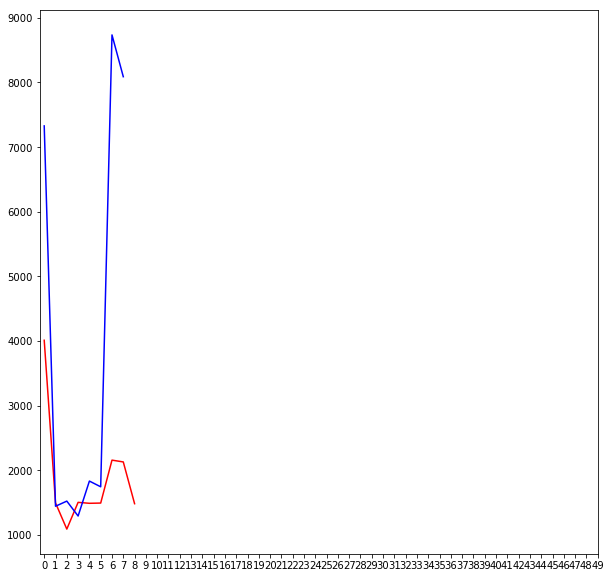


Time Taken :  2.6671104431152344

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Nov
Number of days present :  16

Year :  2017

Month :  Dec
Number of days present :  0


In [86]:
'''
Checking how many days are present in each day of the month, for the entire dataset.
Checks for the month period starting from 1 - 30.
'''
master_dict1={}
year = [2013,2014,2015,2016,2017]
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
month_days = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]

for y in year:
    for m in month:
        print("\nYear : ",y)
        print("\nMonth : ",month_days[int(m)-1])
        num_hours = np.sum(df_new_thermal["localhour"].str.contains(str(y)+"-"+m))
        num_days = np.sum(new_df1["localhour"].str.contains(str(y)+"-"+m))
        print ( "Number of days present : " , num_days )
        
        #Only train a model, if there are sufficient number of days, i.e >= 672 (hours) or 28 days.
        if (num_days >= 28):
            monthdf = pd.DataFrame(df_new_thermal[df_new_thermal["localhour"].str.contains(str(y)+"-"+m)],columns = df_new_thermal.columns)
            print ("From the loop : ",monthdf.shape)
            #Now, pass it to the model.
            thermal_dict = {}
            ti = time.time()
            thermal_dict,y_test1,y_pred1 = extra_trees(monthdf,thermal_dict,1,"mean_squared_error",7,day_hour)
            tf = time.time()
            print ("\nTime Taken : ",tf-ti)
            print ("\n",thermal_dict1)
            master_dict1[str(y)+"-"+m] = thermal_dict

In [87]:
'''
This dictionary corresponds to the definition of a month from the 1st to the 30th.
'''
print ("Master dict : ")
for key,val in master_dict1.items():
    print (key, " - ",val,"\n")

Master dict : 
2013-04  -  {'R2': -0.032508749345441013, 'RMSE': 4069.8534001745616, 'MAE': 3540.3958708333366} 

2013-05  -  {'R2': -1.341214043456064, 'RMSE': 2065.0790019043934, 'MAE': 1780.1190407407371} 

2013-06  -  {'R2': -0.90941438156538101, 'RMSE': 9838.9188181313875, 'MAE': 7913.765066666756} 

2013-07  -  {'R2': -0.71114683311132265, 'RMSE': 6819.2737471796972, 'MAE': 4474.6841074074136} 

2013-08  -  {'R2': -0.099050216539708469, 'RMSE': 10624.998995353275, 'MAE': 9053.3275666666705} 

2013-09  -  {'R2': 0.30443168892928096, 'RMSE': 6467.141527852219, 'MAE': 5140.0460624999596} 

2013-10  -  {'R2': -14.044105119253246, 'RMSE': 6256.3708613450226, 'MAE': 3294.7521444444524} 

2013-11  -  {'R2': -2.4064830941359387, 'RMSE': 21681.412754249326, 'MAE': 18248.924670370368} 

2013-12  -  {'R2': -1.5478679657509482, 'RMSE': 11472.067204356783, 'MAE': 7564.2821888888266} 

2014-01  -  {'R2': -0.98900503820566144, 'RMSE': 19345.712377546897, 'MAE': 15475.916737037012} 

2014-02  - 


Year :  2013

Month :  Jan
Number of days present :  0

Year :  2013

Month :  Feb
Number of days present :  0

Year :  2013

Month :  Mar
Number of days present :  9

Year :  2013

Month :  Apr
Number of days present :  30
Start index :  544
05
Stop index :  1264
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2 air3 furnace1 furnace2  \
0  2013-04-15 00:00:00-05  3465.55  0.733333    0  127.767  217.267   
1  2013-04-16 00:00:00-05  4706.45  0.483333    0  141.817  235.333   
2  2013-04-17 00:00:00-05  3524.57  0.316667    0  139.733  236.933   
3  2013-04-18 00:00:00-05  1305.53   1.51667    0  1320.67  238.633   
4  2013-04-19 00:00:00-05  2.31667   7.93333    0  12021.1  240.883   

  waterheater1 total_thermal_load  
0      2686.62            6497.93  
1      2288.32             7372.4  
2      1081.08            4982.63  
3      2881.42            5747.77  
4      2777.27        

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.440360)
2. feature 4 (0.317328)
3. feature 2 (0.242312)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -16.5913079008
RMSE :  6067.10396045
MAE :  5766.4521963


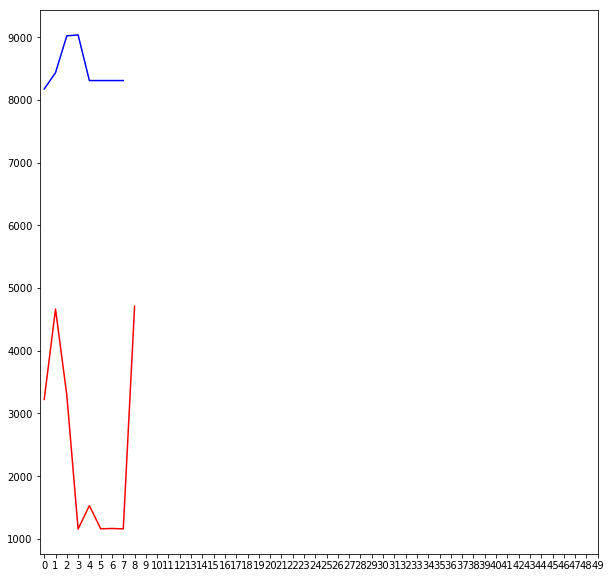


Time Taken :  2.7731094360351562

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  May
Number of days present :  31
Start index :  1264
06
Stop index :  2008
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2 air3 furnace1 furnace2  \
0  2013-05-15 00:00:00-05  3336.48      0.4    0  140.783  237.433   
1  2013-05-16 00:00:00-05  7252.23  3.01667    0  140.733  235.083   
2  2013-05-17 00:00:00-05  12833.4  2.03333    0  141.167  228.983   
3  2013-05-18 00:00:00-05  14906.4  1.38333    0  140.483  228.867   
4  2013-05-19 00:00:00-05  2360.72     0.25    0  141.583  237.867   

  waterheater1 total_thermal_load  
0      783.367            4498.47  
1      770.183            8401.25  
2       825.55            14031.1  
3        798.8            16075.9  
4      405.433            3145.85  
(31, 8)
Inside extra trees : 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (31, 8)
mean : 11131.2521505 max: 27004.133333333328 min: 1171.8166666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  4498.47
1  NaN    NaN      NaN      NaN  4498.47  8401.25
2  NaN    NaN      NaN  4498.47  8401.25  14031.1
3  3.0    1.0  4498.47  8401.25  14031.1  16075.9
4  3.0    1.0  8401.25  14031.1  16075.9  3145.85
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.639316)
2. feature 3 (0.181935)
3. feature 2 (0.178749)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.885805065141
RMSE :  9742.39298946
MAE :  8584.70072963


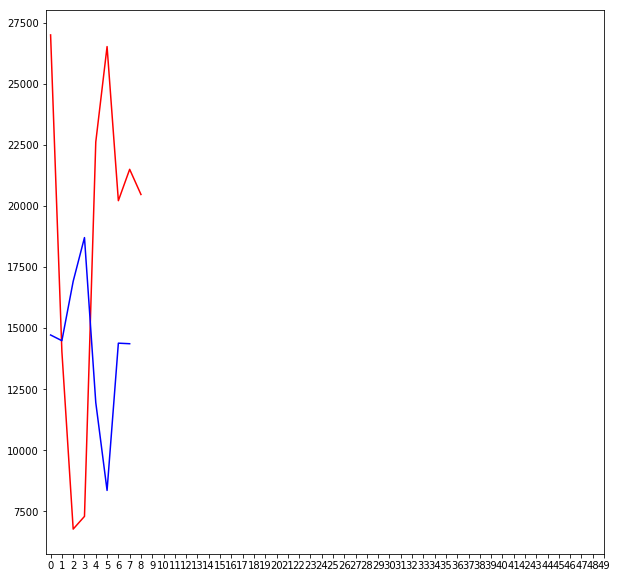


Time Taken :  2.7093071937561035

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Jun
Number of days present :  30
Start index :  2008
07
Stop index :  2728
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-06-15 00:00:00-05  11014.7  4598.65  2725.97  730.333  1312.48   
1  2013-06-16 00:00:00-05  15764.4  7527.05  4617.53  1055.98   1873.7   
2  2013-06-17 00:00:00-05  15700.8  5801.62  4988.07  1135.37   1420.9   
3  2013-06-18 00:00:00-05  13318.8  4516.57  3277.75    831.2  1218.05   
4  2013-06-19 00:00:00-05  13425.4  10613.7  4944.55     1118  2510.02   

  waterheater1 total_thermal_load  
0       788.05            21170.1  
1      415.867            31254.5  
2      812.417            29859.2  
3      415.517            23577.9  
4       808.75            33420.4  
(30, 8)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Inside extra trees :  (30, 8)
mean : 30293.8094444 max: 47711.43333333332 min: 17647.999999999996
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  21170.1
1  NaN    NaN      NaN      NaN  21170.1  31254.5
2  NaN    NaN      NaN  21170.1  31254.5  29859.2
3  3.0    1.0  21170.1  31254.5  29859.2  23577.9
4  3.0    1.0  31254.5  29859.2  23577.9  33420.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.373797)
2. feature 2 (0.340748)
3. feature 3 (0.285455)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.991147986944
RMSE :  9620.83733008
MAE :  7284.99018148


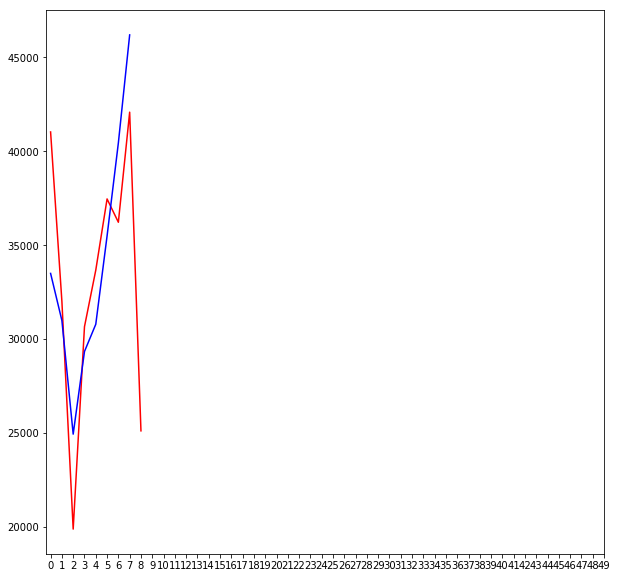


Time Taken :  3.0023436546325684

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Jul
Number of days present :  31
Start index :  2728
08
Stop index :  3472
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-07-15 00:00:00-05  4875.55  1168.82        0   143.55  554.267   
1  2013-07-16 00:00:00-05  7994.43  1844.47  1337.47    428.8  695.183   
2  2013-07-17 00:00:00-05  6360.92  1676.08   681.35  289.233  680.567   
3  2013-07-18 00:00:00-05   9751.8   4653.2  2569.58  679.217  1279.18   
4  2013-07-19 00:00:00-05  14490.8  6366.12  4081.52    952.9  1643.08   

  waterheater1 total_thermal_load  
0      1173.23            7915.42  
1      779.283            13079.6  
2      815.633            10503.8  
3      787.583            19720.6  
4        396.5            27930.9  
(31, 8)
Inside e

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



mean : 32975.0005376 max: 55922.84999999999 min: 7915.416666666665
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  7915.42
1  NaN    NaN      NaN      NaN  7915.42  13079.6
2  NaN    NaN      NaN  7915.42  13079.6  10503.8
3  3.0    1.0  7915.42  13079.6  10503.8  19720.6
4  3.0    1.0  13079.6  10503.8  19720.6  27930.9
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.514420)
2. feature 3 (0.251715)
3. feature 2 (0.233864)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.27421200209
RMSE :  7748.67538972
MAE :  6578.29797037


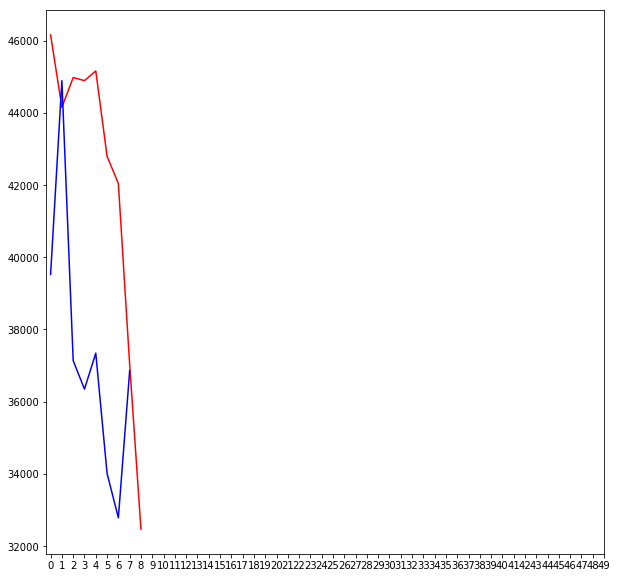


Time Taken :  3.019537925720215

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Aug
Number of days present :  31
Start index :  3472
09
Stop index :  4216
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-08-15 00:00:00-05  12226.2  4293.33  3824.23  917.683  1317.88   
1  2013-08-16 00:00:00-05  13849.7  6578.92  3503.07    852.4   1908.6   
2  2013-08-17 00:00:00-05  14189.1  2668.48  3956.77  922.283   873.55   
3  2013-08-18 00:00:00-05  14052.8  4627.88  4490.83  1017.25  1334.87   
4  2013-08-19 00:00:00-05  13876.9  6358.32  4217.18    973.8  1790.23   

  waterheater1 total_thermal_load  
0       788.85            23368.2  
1        777.9            27470.6  
2      390.483            23000.7  
3          823            26346.6  
4       796.55            28012.9  
(31, 8)
Inside ex

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


max: 47101.833333333336 min: 10377.533333333331
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  23368.2
1  NaN    NaN      NaN      NaN  23368.2  27470.6
2  NaN    NaN      NaN  23368.2  27470.6  23000.7
3  3.0    1.0  23368.2  27470.6  23000.7  26346.6
4  3.0    1.0  27470.6  23000.7  26346.6  28012.9
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.517628)
2. feature 2 (0.330951)
3. feature 3 (0.151421)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.555141178016
RMSE :  7726.19090667
MAE :  6415.42316296


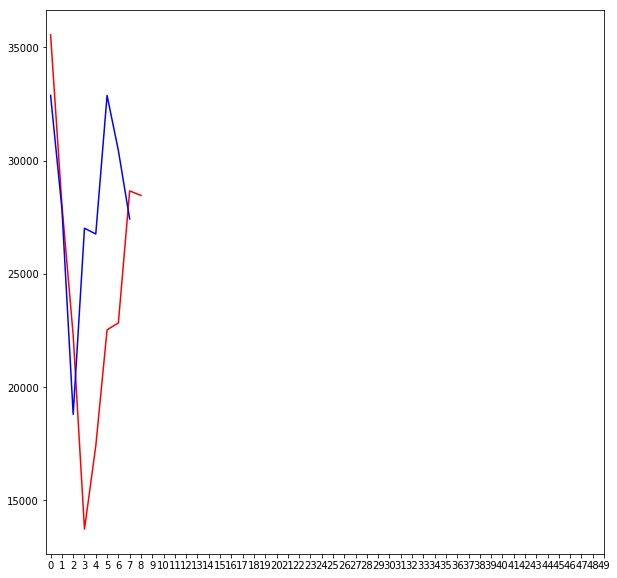


Time Taken :  2.6583735942840576

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Sept
Number of days present :  30
Start index :  4216
Stop index :  4936
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2013-09-15 00:00:00-05  12844.6  3889.77   3422.3   798.15  1192.17   
1  2013-09-16 00:00:00-05  9847.57  3346.48  1964.28  524.833  1137.22   
2  2013-09-17 00:00:00-05  9275.02   2850.4  2502.23  621.717  977.433   
3  2013-09-18 00:00:00-05  12877.9  4071.82   4345.3    963.4  1208.87   
4  2013-09-19 00:00:00-05  10459.8  2895.52  2972.32  725.867  983.983   

  waterheater1 total_thermal_load  
0       413.05            22560.1  
1       834.25            17654.6  
2      788.567            17015.4  
3      832.367            24299.7  
4      813.717            18851.2  
(30, 8)
Inside ext

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(30, 8)
mean : 13083.79 max: 24299.699999999997 min: 1103.9166666666667
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  22560.1
1  NaN    NaN      NaN      NaN  22560.1  17654.6
2  NaN    NaN      NaN  22560.1  17654.6  17015.4
3  3.0    1.0  22560.1  17654.6  17015.4  24299.7
4  3.0    1.0  17654.6  17015.4  24299.7  18851.2
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.549298)
2. feature 3 (0.245154)
3. feature 2 (0.205548)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.0586476338193
RMSE :  7488.50827204
MAE :  6683.53866667


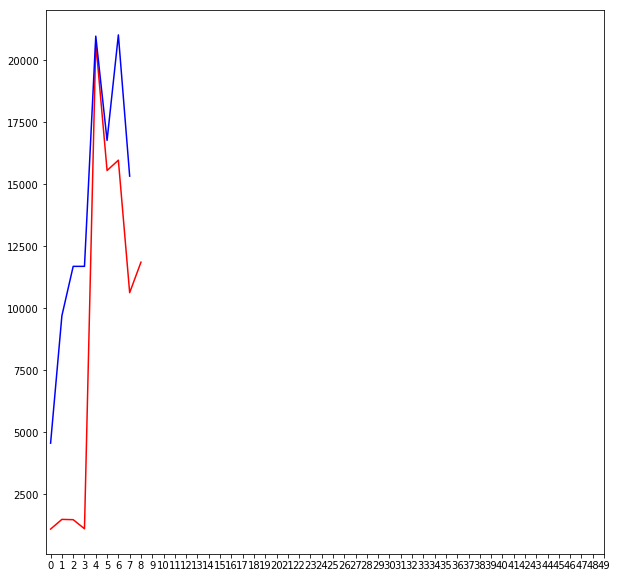


Time Taken :  2.6800854206085205

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Oct
Number of days present :  31
Start index :  4936
Stop index :  5681
From the loop :  (746, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2      air3 furnace1 furnace2  \
0  2013-10-15 00:00:00-05    2257.4   792.533         0  119.883    441.6   
1  2013-10-16 00:00:00-05   3.11667  0.333333         0  120.583  229.617   
2  2013-10-17 00:00:00-05   1.86667  0.933333  0.566667    120.2   231.85   
3  2013-10-18 00:00:00-05  0.233333   1.31667   2.01667  120.633   227.95   
4  2013-10-19 00:00:00-05  0.333333   1.13333   2.81667    120.9      238   

  waterheater1 total_thermal_load  
0      1138.85            4750.27  
1      1160.47            1514.12  
2      1155.18             1510.6  
3      1150.93            1503.08  
4      1539.57            1902.75  
(

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Inside extra trees :  (31, 8)
mean : 2249.96397849 max: 7377.333333333333 min: 1121.9666666666665
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  4750.27
1  NaN    NaN      NaN      NaN  4750.27  1514.12
2  NaN    NaN      NaN  4750.27  1514.12   1510.6
3  3.0    1.0  4750.27  1514.12   1510.6  1503.08
4  3.0    1.0  1514.12   1510.6  1503.08  1902.75
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.401464)
2. feature 3 (0.346899)
3. feature 2 (0.251637)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.352563843341
RMSE :  1600.7047797
MAE :  922.199196296


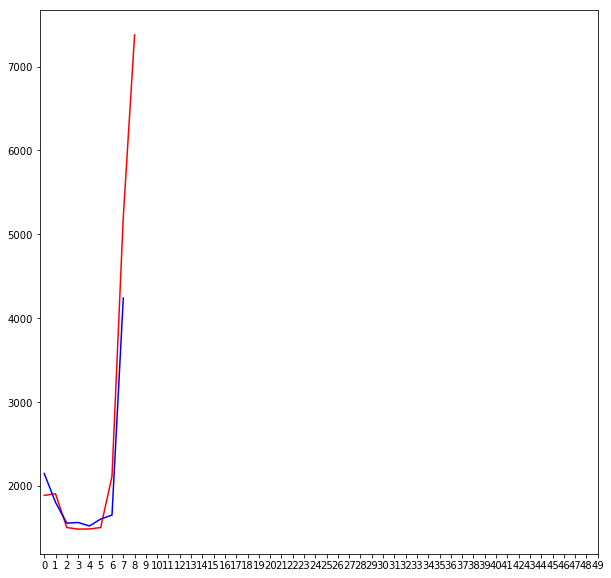


Time Taken :  2.7691893577575684

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Nov
Number of days present :  30
Start index :  5681
Stop index :  6401
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-11-15 00:00:00-06      0.85   1.86667     1.95    120.5  1443.42   
1  2013-11-16 00:00:00-06  0.116667  0.366667  1.81667  120.217  235.033   
2  2013-11-17 00:00:00-06   3853.17  0.716667      1.1   119.55   228.25   
3  2013-11-18 00:00:00-06      0.15       0.7      1.2   120.05  230.833   
4  2013-11-19 00:00:00-06       0.1       0.3      1.7    120.2  232.067   

  waterheater1 total_thermal_load  
0      1162.53            2731.12  
1      1161.12            1518.67  
2       799.45            5002.23  
3      801.533            1154.47  
4      1171.18            1525.55  
(30, 8)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 20026.3438889 max: 69397.58333333334 min: 1154.4666666666662
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2731.12
1  NaN    NaN      NaN      NaN  2731.12  1518.67
2  NaN    NaN      NaN  2731.12  1518.67  5002.23
3  3.0    1.0  2731.12  1518.67  5002.23  1154.47
4  3.0    1.0  1518.67  5002.23  1154.47  1525.55
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.753867)
2. feature 3 (0.123950)
3. feature 2 (0.122183)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.38453441925
RMSE :  20541.9000388
MAE :  17098.2919778


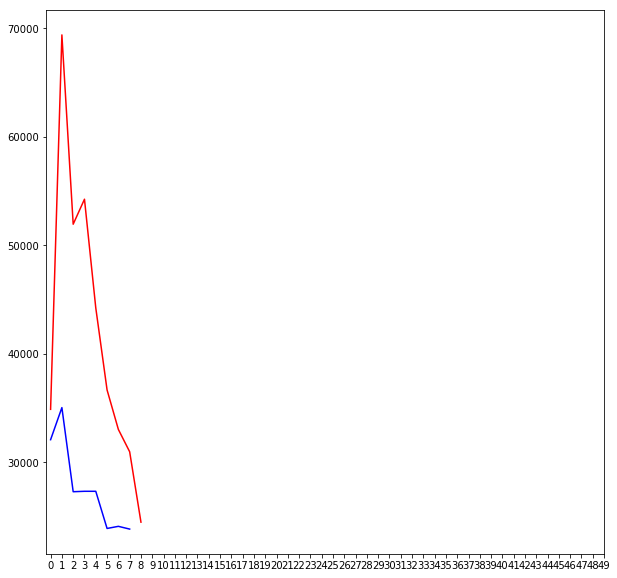


Time Taken :  2.647552013397217

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2013

Month :  Dec
Number of days present :  31
Start index :  6401
01
Stop index :  7145
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-12-15 00:00:00-06         0   12.1333  2.73333  17061.2  219.217   
1  2013-12-16 00:00:00-06         0      10.2  2.86667  14431.3  217.083   
2  2013-12-17 00:00:00-06  0.833333   9.08333     1.95  10919.6   1611.2   
3  2013-12-18 00:00:00-06  0.183333   5.18333      2.8  6051.43  2941.87   
4  2013-12-19 00:00:00-06      0.15  0.366667      1.9  120.067  1205.23   

  waterheater1 total_thermal_load  
0       1542.2            18837.5  
1      1550.53              16212  
2      1147.18            13689.9  
3      1589.75            10591.2  
4      1169.22            2496.93  
(31, 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 55234.9 min: 1582.6833333333332
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  18837.5
1  NaN    NaN      NaN      NaN  18837.5    16212
2  NaN    NaN      NaN  18837.5    16212  13689.9
3  3.0    1.0  18837.5    16212  13689.9  10591.2
4  3.0    1.0    16212  13689.9  10591.2  2496.93
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.513888)
2. feature 2 (0.301288)
3. feature 3 (0.184824)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.283854860186
RMSE :  16070.4390994
MAE :  12019.8670852


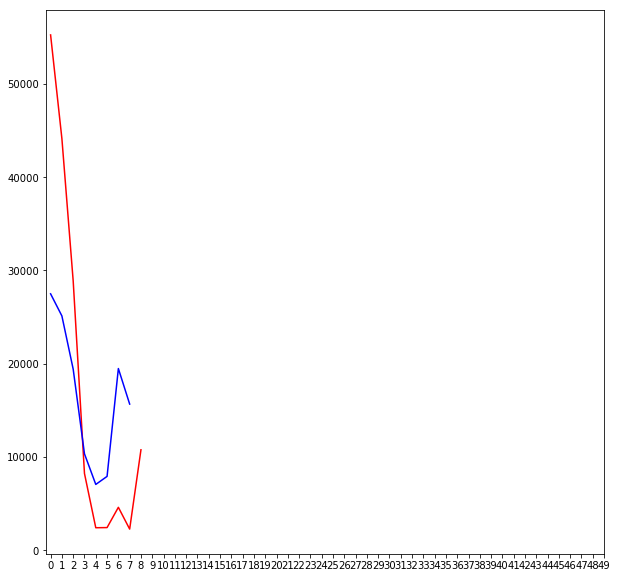


Time Taken :  2.6638033390045166

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jan
Number of days present :  31
Start index :  7145
02
Stop index :  7889
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour air1      air2     air3 furnace1 furnace2  \
0  2014-01-15 00:00:00-06    0      2.55  2.83333  2819.05  2833.15   
1  2014-01-16 00:00:00-06  0.9       6.2  2.01667   6130.8   2550.5   
2  2014-01-17 00:00:00-06  0.2  0.916667  2.96667    119.9  2063.42   
3  2014-01-18 00:00:00-06    0       7.8  2.58333  8499.67  1597.22   
4  2014-01-19 00:00:00-06    0   1.98333  2.11667  1416.05  1093.28   

  waterheater1 total_thermal_load  
0       1553.5            7211.08  
1       1124.8            9815.22  
2      1548.87            3736.27  
3      1540.08            11647.4  
4      1147.65            3661.08  
(31, 8)
Inside extra trees :  (31,

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


min: 2988.9666666666667
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  7211.08
1  NaN    NaN      NaN      NaN  7211.08  9815.22
2  NaN    NaN      NaN  7211.08  9815.22  3736.27
3  3.0    1.0  7211.08  9815.22  3736.27  11647.4
4  3.0    1.0  9815.22  3736.27  11647.4  3661.08
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.510807)
2. feature 2 (0.271034)
3. feature 3 (0.218159)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.319477857716
RMSE :  21393.0290899
MAE :  17240.3062481


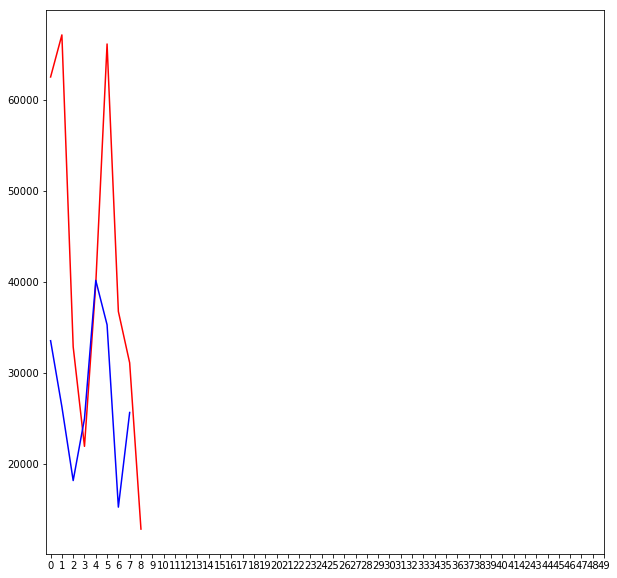


Time Taken :  2.658684253692627

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Feb
Number of days present :  28
Start index :  7889
03
Stop index :  8560
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1      air2     air3 furnace1 furnace2  \
0  2014-02-15 00:00:00-06     0       1.8      4.1  2551.22  1011.33   
1  2014-02-16 00:00:00-06     0       0.8  3.23333  1253.35  665.483   
2  2014-02-17 00:00:00-06     0         0  232.133  167.917   238.45   
3  2014-02-18 00:00:00-06  0.25      0.75  6.33333   121.45  119.767   
4  2014-02-19 00:00:00-06  0.35  0.916667    128.1  149.667  119.967   

  waterheater1 total_thermal_load  
0      2140.95             5709.4  
1      1671.05            3593.92  
2       2198.9             2837.4  
3      3534.55             3783.1  
4      2359.83            2758.83  
(27, 8)
Inside extra trees : 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1828.3666666666663
Dimensions of temp :  (27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   5709.4
1  NaN    NaN      NaN      NaN   5709.4  3593.92
2  NaN    NaN      NaN   5709.4  3593.92   2837.4
3  3.0    1.0   5709.4  3593.92   2837.4   3783.1
4  3.0    1.0  3593.92   2837.4   3783.1  2758.83
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.585206)
2. feature 2 (0.225544)
3. feature 3 (0.189249)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -18.9540797399
RMSE :  20516.1206508
MAE :  16952.8214792


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


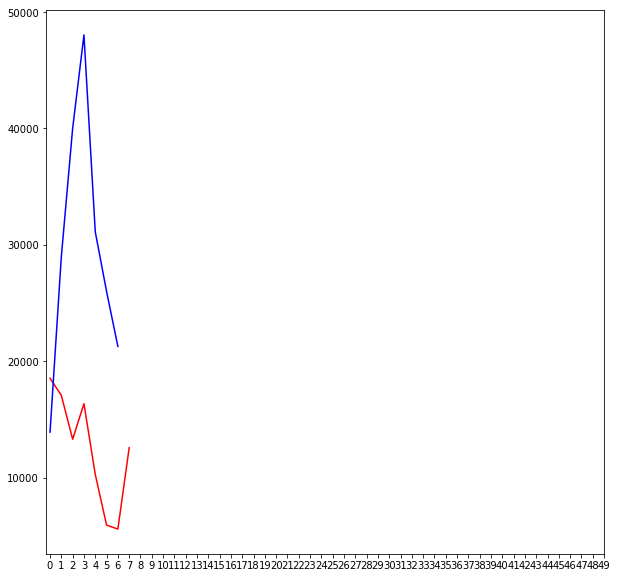


Time Taken :  2.9009034633636475

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Mar
Number of days present :  31
Start index :  8560
04
Stop index :  9304
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2014-03-15 00:00:00-05  0.216667      0.4  4.61667    120.3  365.117   
1  2014-03-16 00:00:00-05      0.05  2.53333  7.38333  3353.13  119.967   
2  2014-03-17 00:00:00-05  0.166667  10.5667      3.6  14565.6  119.983   
3  2014-03-18 00:00:00-05       0.6  7.96667  170.233  8648.35  120.017   
4  2014-03-19 00:00:00-05      1.05  1.46667  3.58333      120  120.017   

  waterheater1 total_thermal_load  
0      2394.32            2884.97  
1      4429.02            7912.08  
2      1872.85            16572.8  
3      3291.08            12238.2  
4      2134.95            2381.07  
(31, 8)
In

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 1305.6666666666665
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2884.97
1  NaN    NaN      NaN      NaN  2884.97  7912.08
2  NaN    NaN      NaN  2884.97  7912.08  16572.8
3  3.0    1.0  2884.97  7912.08  16572.8  12238.2
4  3.0    1.0  7912.08  16572.8  12238.2  2381.07
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.417423)
2. feature 4 (0.379429)
3. feature 3 (0.203148)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.260824564933
RMSE :  6389.60966887
MAE :  3644.64054444


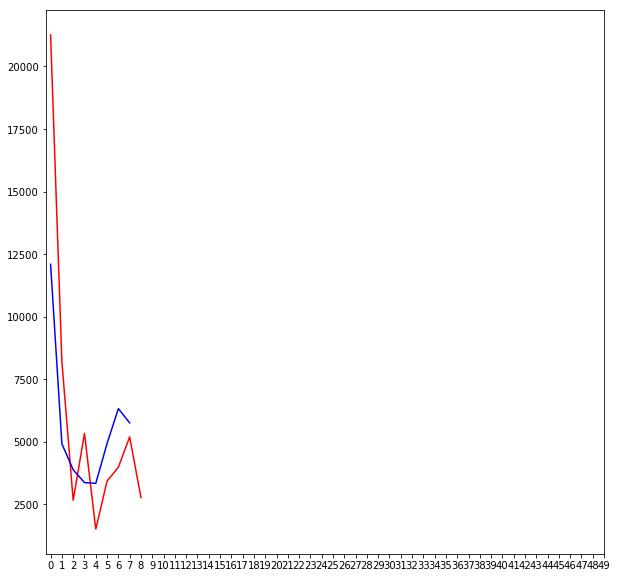


Time Taken :  2.6822609901428223

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Apr
Number of days present :  30
Start index :  9304
05
Stop index :  10024
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1      air2     air3 furnace1 furnace2  \
0  2014-04-15 00:00:00-05   0.1       1.6      4.7  2206.45  888.267   
1  2014-04-16 00:00:00-05  0.25   8.86667  5.58333    11121   119.95   
2  2014-04-17 00:00:00-05   0.2      0.55  7.11667   120.85  120.017   
3  2014-04-18 00:00:00-05  0.15  0.483333      2.1  120.233  119.967   
4  2014-04-19 00:00:00-05   0.1      0.45  1.33333   120.25   120.15   

  waterheater1 total_thermal_load  
0      2871.08             5972.2  
1       3302.7            14558.4  
2      3520.78            3769.52  
3      1133.27             1376.2  
4       762.75            1005.03  
(30, 8)
Inside extra trees 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 4801.15944444 max: 14558.383333333335 min: 1005.0333333333332
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   5972.2
1  NaN    NaN      NaN      NaN   5972.2  14558.4
2  NaN    NaN      NaN   5972.2  14558.4  3769.52
3  3.0    1.0   5972.2  14558.4  3769.52   1376.2
4  3.0    1.0  14558.4  3769.52   1376.2  1005.03
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.402077)
2. feature 4 (0.357468)
3. feature 2 (0.240455)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.778684251276
RMSE :  3532.01342402
MAE :  2612.58965926


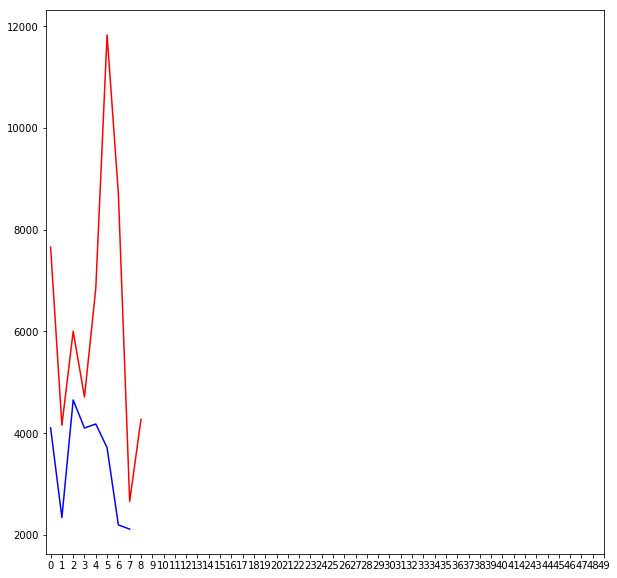


Time Taken :  2.6902506351470947

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  May
Number of days present :  31
Start index :  10024
06
Stop index :  10768
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-05-15 00:00:00-05  0.983333   1.38333  3.23333    120.9  120.017   
1  2014-05-16 00:00:00-05   122.917      0.55  4.53333    120.8  119.933   
2  2014-05-17 00:00:00-05       0.2      0.45  1.81667   120.45  119.983   
3  2014-05-18 00:00:00-05      0.35  0.633333      1.4  120.317   119.95   
4  2014-05-19 00:00:00-05       0.2  0.616667  1807.17   482.75   120.35   

  waterheater1 total_thermal_load  
0      1815.03            2061.55  
1      2419.78            2788.52  
2      1147.05            1389.95  
3      796.683            1039.33  
4      784.183            3195.27  


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(31, 8)
Inside extra trees :  (31, 8)
mean : 8501.4327957 max: 20002.016666666666 min: 1039.333333333333
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2061.55
1  NaN    NaN      NaN      NaN  2061.55  2788.52
2  NaN    NaN      NaN  2061.55  2788.52  1389.95
3  3.0    1.0  2061.55  2788.52  1389.95  1039.33
4  3.0    1.0  2788.52  1389.95  1039.33  3195.27
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.350613)
2. feature 4 (0.331401)
3. feature 2 (0.317986)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.386201604718
RMSE :  4274.96128643
MAE :  3983.00058889


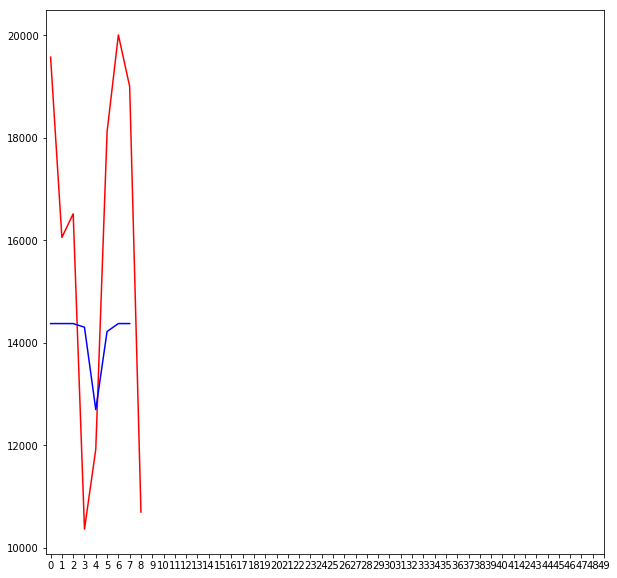


Time Taken :  2.6830575466156006

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jun
Number of days present :  30
Start index :  10768
07
Stop index :  11488
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2014-06-15 00:00:00-05  11678.5  5794.33  4166.45   964.35  856.683   
1  2014-06-16 00:00:00-05  12008.2   3336.2  4106.62  958.683  541.133   
2  2014-06-17 00:00:00-05  12289.4  1753.53   4108.3  957.283    339.8   
3  2014-06-18 00:00:00-05  10195.7  3332.63  3454.37  833.567  545.783   
4  2014-06-19 00:00:00-05  10388.5  3327.38  3391.58  821.683    550.1   

  waterheater1 total_thermal_load  
0      428.567            23888.8  
1      882.067            21832.9  
2      435.033            19883.3  
3      875.533            19237.6  
4        478.1            18957.4  
(30, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



mean : 21002.1816667 max: 38736.533333333326 min: 10880.683333333334
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  23888.8
1  NaN    NaN      NaN      NaN  23888.8  21832.9
2  NaN    NaN      NaN  23888.8  21832.9  19883.3
3  3.0    1.0  23888.8  21832.9  19883.3  19237.6
4  3.0    1.0  21832.9  19883.3  19237.6  18957.4
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.450605)
2. feature 4 (0.368634)
3. feature 3 (0.180761)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.6715328131
RMSE :  9296.69310667
MAE :  6917.47767407


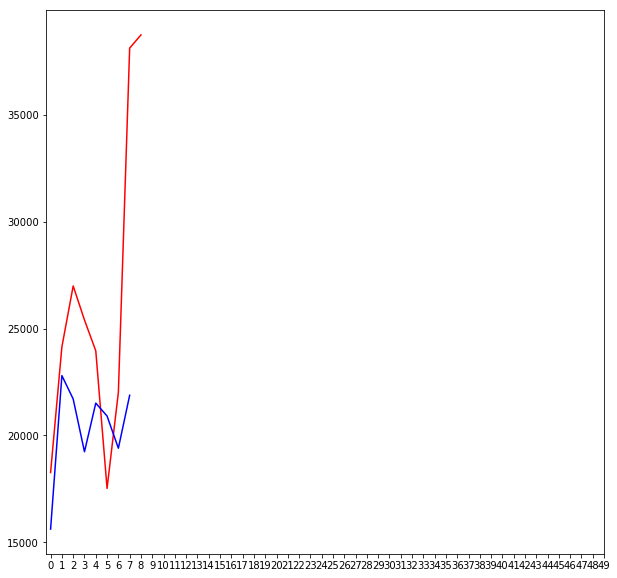


Time Taken :  2.6509954929351807

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Jul
Number of days present :  31
Start index :  11488
08
Stop index :  12232
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2014-07-15 00:00:00-05  11698.3    2415.3  10128.6  2251.85  444.717   
1  2014-07-16 00:00:00-05  9721.63   3194.58  8814.17  1889.45   536.15   
2  2014-07-17 00:00:00-05  9994.72   4399.48  8750.72  1966.58  720.167   
3  2014-07-18 00:00:00-05   4688.3    2609.6  4470.18   1139.1   507.65   
4  2014-07-19 00:00:00-05  5602.62  0.583333  6200.88  1430.88   117.25   

  waterheater1 total_thermal_load  
0       3009.2              29948  
1      2511.88            26667.9  
2      2644.43            28476.1  
3      3803.72            17218.5  
4      2324.92            15677.1  
(31, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (31, 8)
mean : 24049.1274194 max: 41123.383333333324 min: 6806.566666666667
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    29948
1  NaN    NaN      NaN      NaN    29948  26667.9
2  NaN    NaN      NaN    29948  26667.9  28476.1
3  3.0    1.0    29948  26667.9  28476.1  17218.5
4  3.0    1.0  26667.9  28476.1  17218.5  15677.1
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.646335)
2. feature 2 (0.180737)
3. feature 3 (0.172928)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.26092206231
RMSE :  9499.04883667
MAE :  7733.12308889


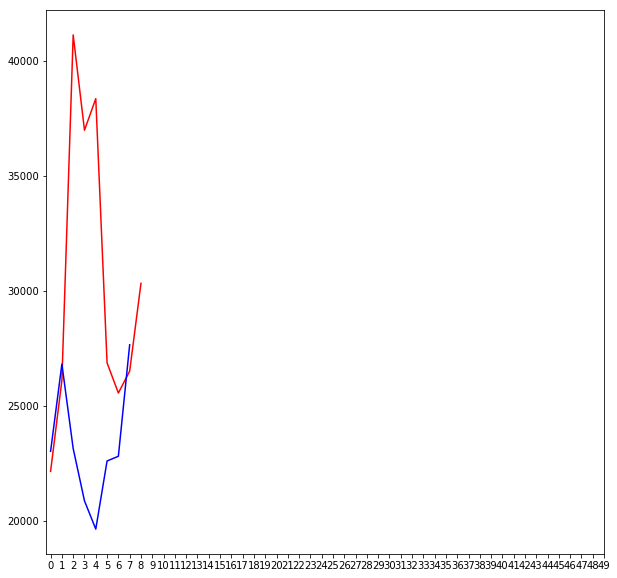


Time Taken :  2.9180397987365723

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Aug
Number of days present :  31
Start index :  12232
09
Stop index :  12976
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2014-08-15 00:00:00-05  11884.4  446.633  8959.73  1863.58      170   
1  2014-08-16 00:00:00-05  12783.1  2977.28  10162.3  2039.52  443.767   
2  2014-08-17 00:00:00-05  16997.8  7080.65  8837.17  1857.07  941.333   
3  2014-08-18 00:00:00-05    15993   8939.5  9133.03  1892.17   1172.7   
4  2014-08-19 00:00:00-05  15276.7   4176.6  7162.72  1582.48    620.5   

  waterheater1 total_thermal_load  
0      850.167            24174.5  
1       410.15            28816.2  
2      863.433            36577.4  
3       401.85            37532.2  
4          873              29692  
(31, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 37532.24999999999 min: 1397.4333333333332
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  24174.5
1  NaN    NaN      NaN      NaN  24174.5  28816.2
2  NaN    NaN      NaN  24174.5  28816.2  36577.4
3  3.0    1.0  24174.5  28816.2  36577.4  37532.2
4  3.0    1.0  28816.2  36577.4  37532.2    29692
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.397362)
2. feature 4 (0.397190)
3. feature 2 (0.205448)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.424641189056
RMSE :  11604.9587249
MAE :  7706.50127037


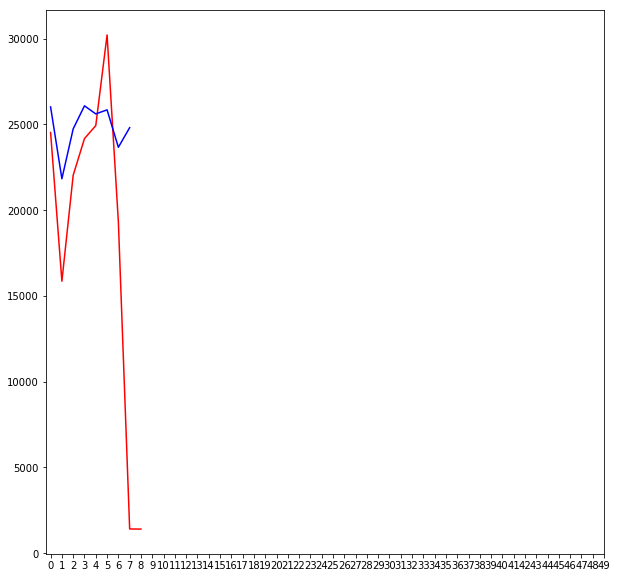


Time Taken :  2.670423746109009

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Sept
Number of days present :  30
Start index :  12976
Stop index :  13696
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2014-09-15 00:00:00-05  3634.87       0.6  339.867   190.55  118.033   
1  2014-09-16 00:00:00-05  10309.6   2263.77  2491.77   603.85  436.067   
2  2014-09-17 00:00:00-05  9696.88   3022.42   2428.9  607.133   520.05   
3  2014-09-18 00:00:00-05     8799    2542.8   1042.1    334.9    477.1   
4  2014-09-19 00:00:00-05  2497.85  0.366667     1.15    120.2  118.367   

  waterheater1 total_thermal_load  
0      805.383             5089.3  
1       384.25            16489.3  
2      812.567              17088  
3      809.667            14005.6  
4      781.883            3519.82  
(30, 8)
Ins

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


min: 1289.6166666666666
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   5089.3
1  NaN    NaN      NaN      NaN   5089.3  16489.3
2  NaN    NaN      NaN   5089.3  16489.3    17088
3  3.0    1.0   5089.3  16489.3    17088  14005.6
4  3.0    1.0  16489.3    17088  14005.6  3519.82
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.395353)
2. feature 3 (0.312038)
3. feature 4 (0.292608)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.0418035199548
RMSE :  7088.78196095
MAE :  5501.85498889


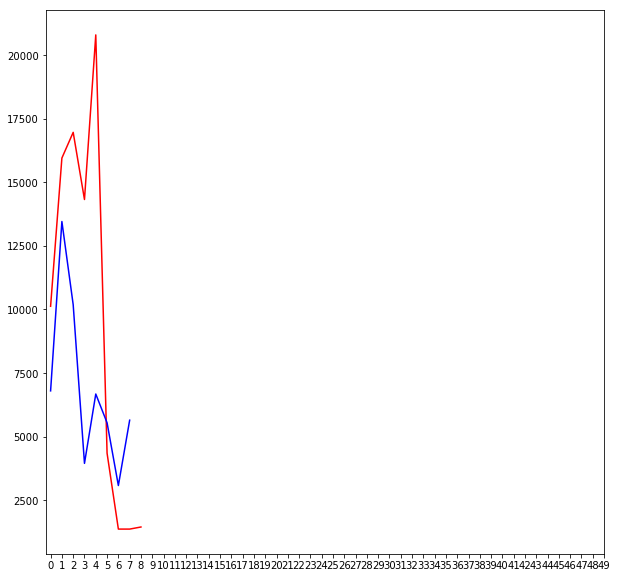


Time Taken :  2.6749961376190186

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Oct
Number of days present :  31
Start index :  13696
Stop index :  14441
From the loop :  (746, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-10-15 00:00:00-05       0.1      1.05      1.7  120.217  119.917   
1  2014-10-16 00:00:00-05  0.366667  0.766667     1.15  120.033   119.95   
2  2014-10-17 00:00:00-05         0       0.2  582.033   244.45  119.733   
3  2014-10-18 00:00:00-05   2451.48    348.75  105.133  142.783  170.567   
4  2014-10-19 00:00:00-05   6030.58   4068.85     1.15  120.267    711.2   

  waterheater1 total_thermal_load  
0       1163.6            1406.58  
1      781.933             1024.2  
2      1181.15            2127.57  
3      792.267            4010.98  
4      776.417            11708.5  
(31, 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 11708.466666666664 min: 1024.1499999999999
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1406.58
1  NaN    NaN      NaN      NaN  1406.58   1024.2
2  NaN    NaN      NaN  1406.58   1024.2  2127.57
3  3.0    1.0  1406.58   1024.2  2127.57  4010.98
4  3.0    1.0   1024.2  2127.57  4010.98  11708.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.575874)
2. feature 3 (0.218547)
3. feature 2 (0.205579)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.397047233713
RMSE :  1129.41282482
MAE :  717.377944444


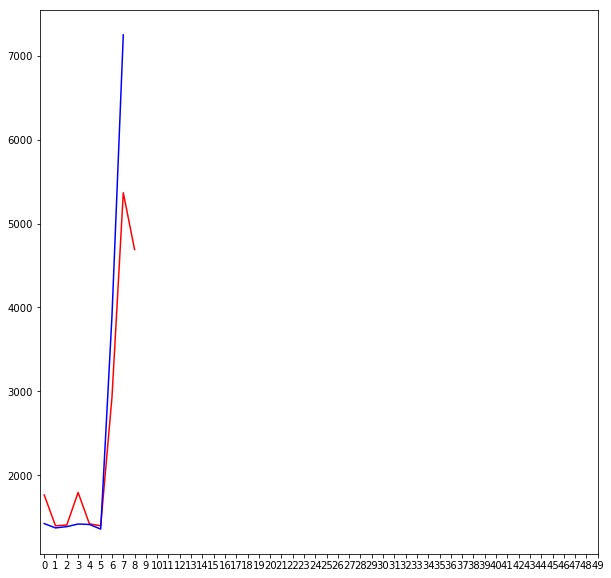


Time Taken :  2.9361000061035156

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Nov
Number of days present :  30
Start index :  14441
Stop index :  15161
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1      air2     air3 furnace1 furnace2  \
0  2014-11-15 00:00:00-06  0.15      0.65      3.5  120.317   2150.4   
1  2014-11-16 00:00:00-06  0.45   1.03333     2.85      120  1706.75   
2  2014-11-17 00:00:00-06   0.1  0.983333  3.63333  120.183  2742.25   
3  2014-11-18 00:00:00-06     0  0.866667  2.76667  120.533  2106.42   
4  2014-11-19 00:00:00-06  1.65   2.48333  2.68333  120.317  1520.77   

  waterheater1 total_thermal_load  
0      1854.45            4129.47  
1      1499.57            3330.65  
2       1890.1            4757.25  
3       1513.9            3744.48  
4      1512.47            3160.37  
(30, 8)
Inside extra trees : 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 4757.249999999999 min: 1216.933333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  4129.47
1  NaN    NaN      NaN      NaN  4129.47  3330.65
2  NaN    NaN      NaN  4129.47  3330.65  4757.25
3  3.0    1.0  4129.47  3330.65  4757.25  3744.48
4  3.0    1.0  3330.65  4757.25  3744.48  3160.37
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.518793)
2. feature 2 (0.278862)
3. feature 3 (0.202345)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.404864274403
RMSE :  619.891603139
MAE :  489.792085185


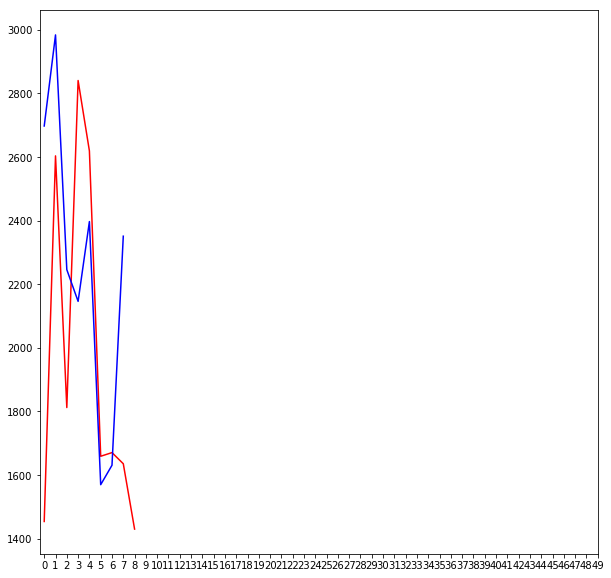


Time Taken :  2.771761655807495

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2014

Month :  Dec
Number of days present :  31
Start index :  15161
01
Stop index :  15905
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-12-15 00:00:00-06       0.2  0.316667  1.83333   120.05      120   
1  2014-12-16 00:00:00-06   1.01667   1.21667  2.76667   120.25  588.883   
2  2014-12-17 00:00:00-06  0.266667  0.516667  3.08333  120.417   1341.3   
3  2014-12-18 00:00:00-06      0.05  0.266667      2.5   120.35  1220.33   
4  2014-12-19 00:00:00-06       0.5   1.18333  2.68333   120.25  1003.58   

  waterheater1 total_thermal_load  
0      1170.42            1412.82  
1       1580.6            2294.73  
2       1583.5            3049.08  
3       1288.1             2631.6  
4       1350.3             2478.5  
(31

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


12010.0424731 max: 38009.68333333333 min: 1412.8166666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1412.82
1  NaN    NaN      NaN      NaN  1412.82  2294.73
2  NaN    NaN      NaN  1412.82  2294.73  3049.08
3  3.0    1.0  1412.82  2294.73  3049.08   2631.6
4  3.0    1.0  2294.73  3049.08   2631.6   2478.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.415087)
2. feature 2 (0.355217)
3. feature 3 (0.229696)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.21366252875
RMSE :  11187.6420462
MAE :  8691.60304444


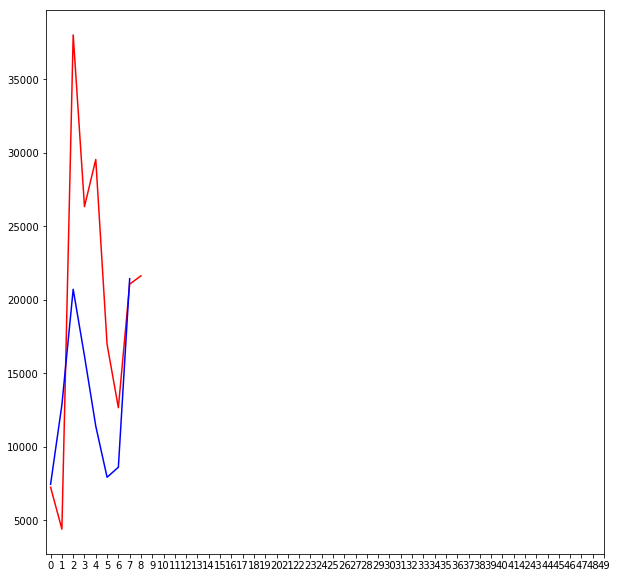


Time Taken :  2.6807820796966553

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jan
Number of days present :  31
Start index :  15905
02
Stop index :  16649
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2015-01-15 00:00:00-06       0.1      6.15  2.88333  7542.87  2278.62   
1  2015-01-16 00:00:00-06  0.166667   2.93333  2.86667   3470.7  2057.38   
2  2015-01-17 00:00:00-06       0.1   1.48333     2.75  120.067  1450.02   
3  2015-01-18 00:00:00-06  0.616667  0.933333        2  120.117  1019.33   
4  2015-01-19 00:00:00-06       0.3  0.416667     2.15      120   823.55   

  waterheater1 total_thermal_load  
0      1534.62            11365.2  
1       1510.4            7044.45  
2      1521.17            3095.58  
3      1159.03            2302.03  
4      1252.73            2199.15  
(3

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 4800.89784946 max: 15870.083333333334 min: 1234.9499999999998
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  11365.2
1  NaN    NaN      NaN      NaN  11365.2  7044.45
2  NaN    NaN      NaN  11365.2  7044.45  3095.58
3  3.0    1.0  11365.2  7044.45  3095.58  2302.03
4  3.0    1.0  7044.45  3095.58  2302.03  2199.15
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.640240)
2. feature 2 (0.243385)
3. feature 3 (0.116375)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.397011766661
RMSE :  2058.0784604
MAE :  1413.36641852


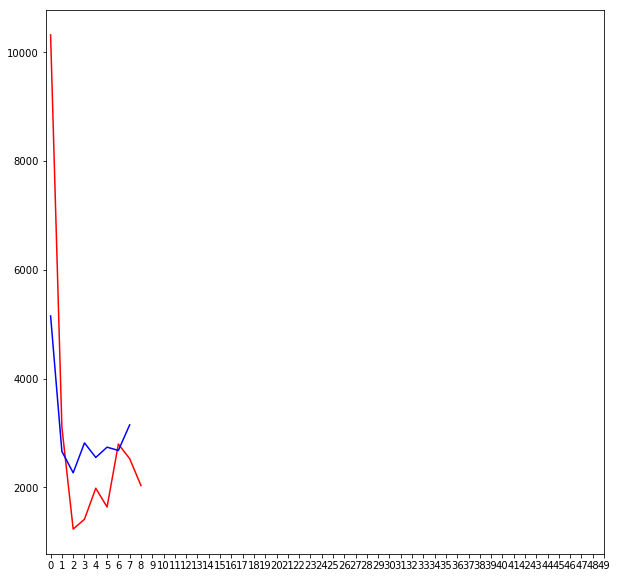


Time Taken :  2.9793248176574707

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Feb
Number of days present :  28
Start index :  16649
03
Stop index :  17320
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2015-02-15 00:00:00-06  0.0666667  0.533333        2    120.2  150.817   
1  2015-02-16 00:00:00-06        0.5   1.78333  3.88333  120.217   733.05   
2  2015-02-17 00:00:00-06          0      0.05  2.93333    120.3  2731.95   
3  2015-02-18 00:00:00-06          0  0.783333  2.98333  120.267  1847.38   
4  2015-02-19 00:00:00-06   0.166667      0.75  3.33333  120.333  1444.68   

  waterheater1 total_thermal_load  
0      1175.17            1448.78  
1      1946.12            2805.55  
2       1517.1            4372.33  
3      1515.55            3486.97  
4      1821.37            3390.6

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(27, 8)
Inside extra trees :  (27, 8)
mean : 12599.4160494 max: 36818.65000000001 min: 1448.7833333333333
Dimensions of temp :  (27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1448.78
1  NaN    NaN      NaN      NaN  1448.78  2805.55
2  NaN    NaN      NaN  1448.78  2805.55  4372.33
3  3.0    1.0  1448.78  2805.55  4372.33  3486.97
4  3.0    1.0  2805.55  4372.33  3486.97  3390.63
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.447341)
2. feature 2 (0.284639)
3. feature 3 (0.268020)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.240234028465
RMSE :  9962.93032039
MAE :  8427.12214583


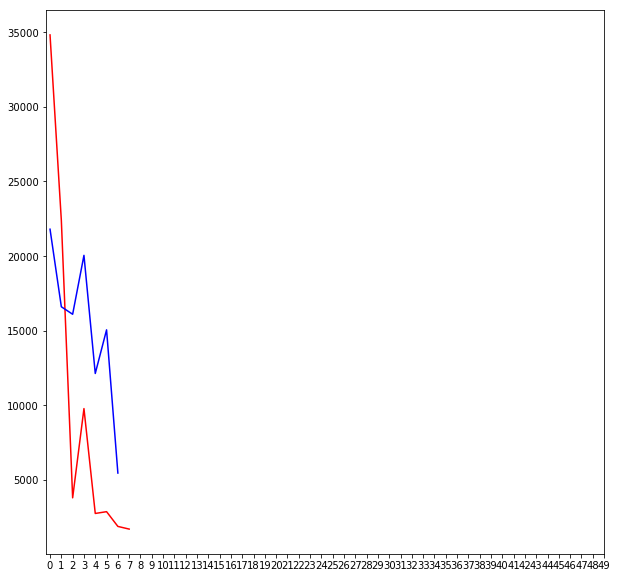


Time Taken :  2.6534852981567383

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Mar
Number of days present :  31
Start index :  17320
04
Stop index :  18064
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-03-15 00:00:00-05        0  0.466667  2.06667  120.083  150.567   
1  2015-03-16 00:00:00-05  1.16667   1.86667  2.06667  120.233    182.1   
2  2015-03-17 00:00:00-05        0         0  1.21667  120.233    119.8   
3  2015-03-18 00:00:00-05        0         0  1.93333  120.283  119.833   
4  2015-03-19 00:00:00-05        0         0  1.31667   120.25    119.9   

  waterheater1 total_thermal_load  
0      1184.52             1457.7  
1      1166.03            1473.47  
2          802            1043.25  
3      1218.23            1460.28  
4      822.583            1064.05  
(31, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 3096.94569892 max: 10975.316666666666 min: 992.9999999999998
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   1457.7
1  NaN    NaN      NaN      NaN   1457.7  1473.47
2  NaN    NaN      NaN   1457.7  1473.47  1043.25
3  3.0    1.0   1457.7  1473.47  1043.25  1460.28
4  3.0    1.0  1473.47  1043.25  1460.28  1064.05
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.510362)
2. feature 4 (0.343697)
3. feature 2 (0.145941)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.87339909494
RMSE :  4624.53931082
MAE :  3774.22201481


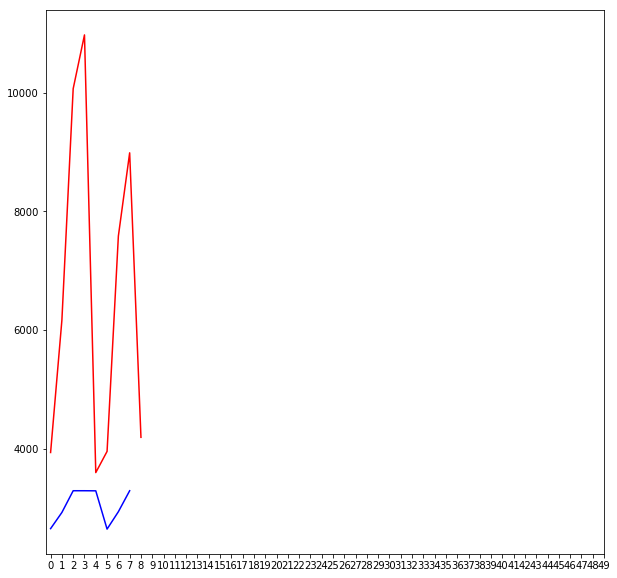


Time Taken :  2.753418445587158

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Apr
Number of days present :  30
Start index :  18064
05
Stop index :  18784
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2015-04-15 00:00:00-05  0.45     1.95  1061.88  368.867  119.917   
1  2015-04-16 00:00:00-05   0.1  1.08333  125.533  153.833  119.933   
2  2015-04-17 00:00:00-05  0.25  2.18333  5.16667  120.883  119.967   
3  2015-04-18 00:00:00-05  0.05  1.83333  2.41667  120.567   119.45   
4  2015-04-19 00:00:00-05     0  1.76667  291.333   182.25  119.417   

  waterheater1 total_thermal_load  
0      3054.25            4607.32  
1      1406.57            1807.05  
2      3037.82            3286.27  
3       1455.3            1699.62  
4      3607.73             4202.5  
(30, 8)
Inside extra trees :  (30

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 4067.15388889 max: 13300.066666666668 min: 1020.9666666666665
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  4607.32
1  NaN    NaN      NaN      NaN  4607.32  1807.05
2  NaN    NaN      NaN  4607.32  1807.05  3286.27
3  3.0    1.0  4607.32  1807.05  3286.27  1699.62
4  3.0    1.0  1807.05  3286.27  1699.62   4202.5
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.411923)
2. feature 3 (0.313086)
3. feature 2 (0.274991)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.022866053669
RMSE :  2885.28226302
MAE :  2646.84522222


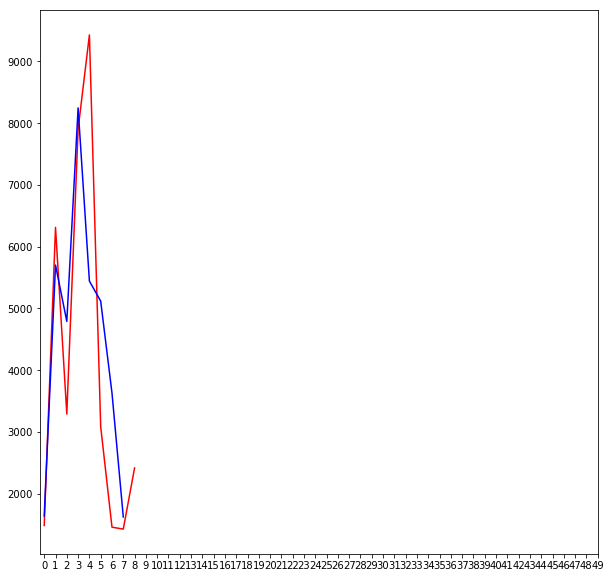


Time Taken :  2.6629831790924072

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  May
Number of days present :  31
Start index :  18784
06
Stop index :  19528
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-05-15 00:00:00-05  742.517  1.56667     1.15   120.25  119.567   
1  2015-05-16 00:00:00-05  5796.18  608.733      1.4   121.65   201.65   
2  2015-05-17 00:00:00-05  3548.78     0.25   1511.1  407.417  71.9667   
3  2015-05-18 00:00:00-05   7410.7  2147.57  5996.02  2350.58      391   
4  2015-05-19 00:00:00-05  6402.92  659.767   2696.4  659.783  206.133   

  waterheater1 total_thermal_load  
0       816.35             1801.4  
1      1207.48             7937.1  
2      1403.23            6942.75  
3      3081.17              21377  
4      717.017              11342  
(31, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(31, 8)
mean : 10532.0801075 max: 24943.166666666664 min: 1027.1333333333332
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month     t-3      t-2      t-1        t
0  NaN    NaN     NaN      NaN      NaN   1801.4
1  NaN    NaN     NaN      NaN   1801.4   7937.1
2  NaN    NaN     NaN   1801.4   7937.1  6942.75
3  3.0    1.0  1801.4   7937.1  6942.75    21377
4  3.0    1.0  7937.1  6942.75    21377    11342
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.458708)
2. feature 3 (0.273133)
3. feature 2 (0.268159)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.17701234373
RMSE :  10106.3479504
MAE :  9294.46401111


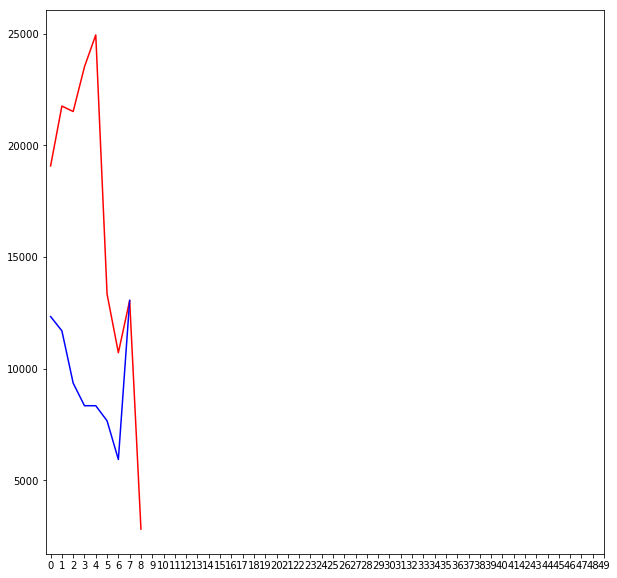


Time Taken :  2.6686389446258545

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jun
Number of days present :  30
Start index :  19528
07
Stop index :  20248
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-06-15 00:00:00-05  9053.18  2500.72  1868.27   499.05  442.683   
1  2015-06-16 00:00:00-05  5115.87  1527.62  173.233  160.633      339   
2  2015-06-17 00:00:00-05  5479.35  2744.28      1.2  120.217  525.567   
3  2015-06-18 00:00:00-05  4998.47   2972.1  1154.95   359.55  503.017   
4  2015-06-19 00:00:00-05  4967.57    649.8        1   120.15    208.3   

  waterheater1 total_thermal_load  
0      424.717            14788.6  
1      1264.48            8580.83  
2      856.367            9726.98  
3       849.55            10837.6  
4      863.783             6810.6  


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(30, 8)
Inside extra trees :  (30, 8)
mean : 16851.5405556 max: 27575.0 min: 6240.049999999999
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  14788.6
1  NaN    NaN      NaN      NaN  14788.6  8580.83
2  NaN    NaN      NaN  14788.6  8580.83  9726.98
3  3.0    1.0  14788.6  8580.83  9726.98  10837.6
4  3.0    1.0  8580.83  9726.98  10837.6   6810.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.569458)
2. feature 3 (0.262293)
3. feature 2 (0.168248)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.0120284315
RMSE :  6518.61111162
MAE :  5253.8976037


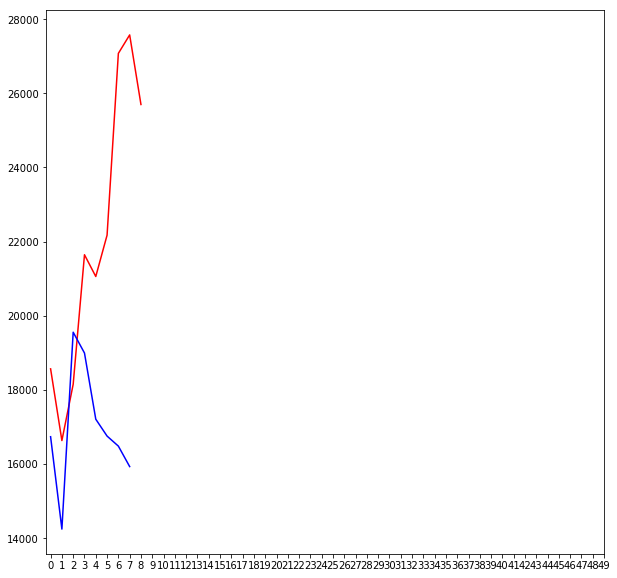


Time Taken :  2.6843767166137695

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Jul
Number of days present :  31
Start index :  20248
08
Stop index :  20992
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-07-15 00:00:00-05  10878.7  3771.85  4970.67  1094.17    556.3   
1  2015-07-16 00:00:00-05  13401.8  4618.65  2871.67  673.633  660.267   
2  2015-07-17 00:00:00-05  14453.7   6061.5  4660.45   985.25    820.1   
3  2015-07-18 00:00:00-05  16605.4   4650.5  5603.05  1215.38   654.45   
4  2015-07-19 00:00:00-05  15417.3  4600.12  5574.75  1197.08  641.967   

  waterheater1 total_thermal_load  
0      820.267              22092  
1      817.883            23043.9  
2      410.517            27391.5  
3      833.783            29562.6  
4      414.317            27845.5  
(31, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished





 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    22092
1  NaN    NaN      NaN      NaN    22092  23043.9
2  NaN    NaN      NaN    22092  23043.9  27391.5
3  3.0    1.0    22092  23043.9  27391.5  29562.6
4  3.0    1.0  23043.9  27391.5  29562.6  27845.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.610432)
2. feature 2 (0.203649)
3. feature 3 (0.185919)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.8178120507
RMSE :  8523.24334968
MAE :  7362.27335926


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


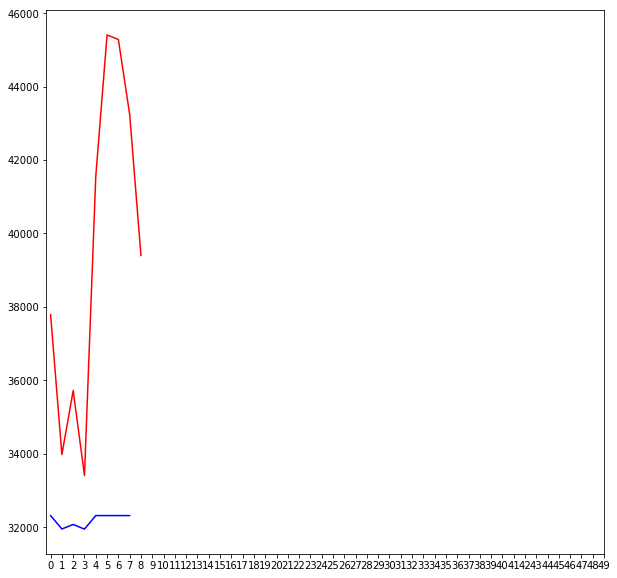


Time Taken :  2.7620038986206055

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Aug
Number of days present :  31
Start index :  20992
09
Stop index :  21736
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-08-15 00:00:00-05  18725.6  6995.93    11858  2285.28    921.3   
1  2015-08-16 00:00:00-05  14658.8   5571.8  8888.03  1714.48  800.367   
2  2015-08-17 00:00:00-05  16565.5   5263.3  8398.82  1653.45      753   
3  2015-08-18 00:00:00-05  16862.5  4635.03  8733.45  1703.15  647.517   
4  2015-08-19 00:00:00-05  18968.8  3885.92  7762.08  1548.42    577.8   

  waterheater1 total_thermal_load  
0      1131.35            41917.4  
1      1631.15            33264.6  
2      1477.97              34112  
3      1475.42            34057.1  
4      1754.38            34497.4  
(31, 8)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Inside extra trees :  (31, 8)
mean : 30177.5026882 max: 51048.11666666667 min: 12047.599999999999
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  41917.4
1  NaN    NaN      NaN      NaN  41917.4  33264.6
2  NaN    NaN      NaN  41917.4  33264.6    34112
3  3.0    1.0  41917.4  33264.6    34112  34057.1
4  3.0    1.0  33264.6    34112  34057.1  34497.4
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.459228)
2. feature 4 (0.355347)
3. feature 3 (0.185426)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.525346244516
RMSE :  10782.849231
MAE :  8665.71538519


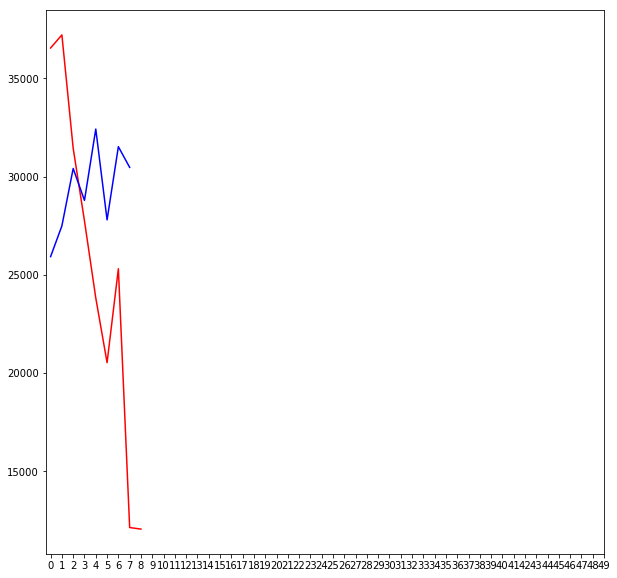


Time Taken :  2.6574361324310303

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Sept
Number of days present :  30
Start index :  21736
Stop index :  22456
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-09-15 00:00:00-05  7988.68  4256.15  3773.15  886.117   664.85   
1  2015-09-16 00:00:00-05  11346.5  2996.92  7612.12  1625.48  497.567   
2  2015-09-17 00:00:00-05  11443.3   3406.2  7307.63  1461.72    530.7   
3  2015-09-18 00:00:00-05    12524   3937.9  8904.33   1839.2  592.367   
4  2015-09-19 00:00:00-05    10121  7586.83  2311.43  601.633  1061.53   

  waterheater1 total_thermal_load  
0      1519.28            19088.2  
1      2761.05            26839.6  
2      2019.23            26168.8  
3      2044.93            29842.8  
4      2142.87            23825.3  
(30, 8)
Inside e

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 max: 31735.033333333326 min: 5168.983333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  19088.2
1  NaN    NaN      NaN      NaN  19088.2  26839.6
2  NaN    NaN      NaN  19088.2  26839.6  26168.8
3  3.0    1.0  19088.2  26839.6  26168.8  29842.8
4  3.0    1.0  26839.6  26168.8  29842.8  23825.3
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.544173)
2. feature 3 (0.298096)
3. feature 2 (0.157731)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.699473913146
RMSE :  6589.36266334
MAE :  5803.80403333


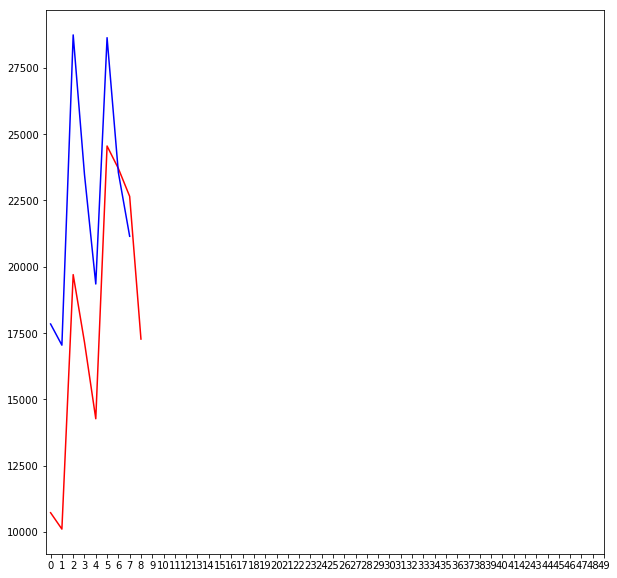


Time Taken :  2.6662826538085938

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Oct
Number of days present :  31
Start index :  22456
Stop index :  23201
From the loop :  (746, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-10-15 00:00:00-05  7922.33      3220  5488.15   1134.6  514.483   
1  2015-10-16 00:00:00-05  5441.25   1213.33  4569.13  1003.27   289.85   
2  2015-10-17 00:00:00-05  1109.67  0.583333  3117.53    787.1  119.217   
3  2015-10-18 00:00:00-05        0   1.61667  3038.77  775.367  119.983   
4  2015-10-19 00:00:00-05  583.517      0.85  2664.82  679.833  116.733   

  waterheater1 total_thermal_load  
0      2767.07            21046.6  
1      2569.83            15086.7  
2      2053.93            7188.03  
3      2302.35            6238.08  
4      2177.27            6223.02  
(31, 8)
Ins

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


7655.12688172 max: 21046.63333333333 min: 2261.1333333333328
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  21046.6
1  NaN    NaN      NaN      NaN  21046.6  15086.7
2  NaN    NaN      NaN  21046.6  15086.7  7188.03
3  3.0    1.0  21046.6  15086.7  7188.03  6238.08
4  3.0    1.0  15086.7  7188.03  6238.08  6223.02
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.399880)
2. feature 2 (0.336749)
3. feature 4 (0.263370)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 1 2] 



R2 Score :  -0.395453281343
RMSE :  5691.01915388
MAE :  4098.11165926


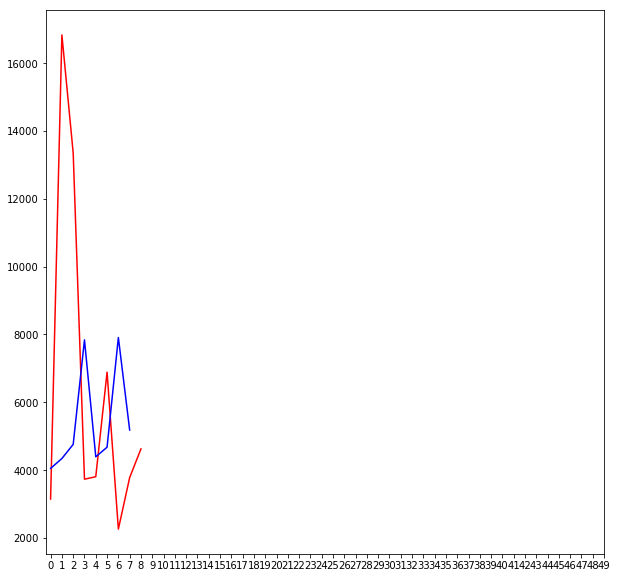


Time Taken :  2.674781560897827

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Nov
Number of days present :  30
Start index :  23201
Stop index :  23921
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2015-11-15 00:00:00-06   1.48333   6.28333     4.75  6067.07  120.633   
1  2015-11-16 00:00:00-06         0  0.883333    257.4   177.15    119.9   
2  2015-11-17 00:00:00-06         0      0.55  6.01667  125.117  119.983   
3  2015-11-18 00:00:00-06      0.25   10.1667  7.76667  10450.9  120.067   
4  2015-11-19 00:00:00-06  0.733333       4.8  4.91667  4258.75  120.033   

  waterheater1 total_thermal_load  
0       2639.8            8840.02  
1       3697.6            4252.93  
2       3176.5            3428.17  
3      4381.45            14970.5  
4      2584.53            6973.77  
(30, 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


max: 60107.450000000004 min: 2684.683333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8840.02
1  NaN    NaN      NaN      NaN  8840.02  4252.93
2  NaN    NaN      NaN  8840.02  4252.93  3428.17
3  3.0    1.0  8840.02  4252.93  3428.17  14970.5
4  3.0    1.0  4252.93  3428.17  14970.5  6973.77
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.603853)
2. feature 2 (0.202924)
3. feature 3 (0.193223)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.0199655436339
RMSE :  9047.9063684
MAE :  7009.50724444


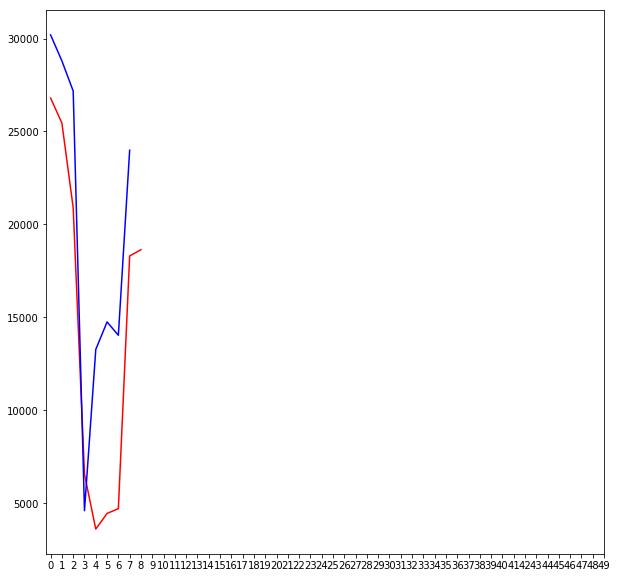


Time Taken :  2.6543874740600586

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2015

Month :  Dec
Number of days present :  31
Start index :  23921
01
Stop index :  24665
From the loop :  (745, 8)
End i:  31


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2015-12-15 00:00:00-06        0.1  0.966667  2.11667  116.833    268.4   
1  2015-12-16 00:00:00-06  0.0666667  0.366667  2.63333  120.117  171.267   
2  2015-12-17 00:00:00-06        1.4      4.05  2.88333    120.1  1642.75   
3  2015-12-18 00:00:00-06        0.1  0.783333     2.75    120.2  1039.72   
4  2015-12-19 00:00:00-06   0.116667       1.1     2.85    120.3  1446.23   

  waterheater1 total_thermal_load  
0      1147.43            1535.85  
1      1569.05             1863.5  
2      1521.67            3292.85  
3      1533.42            2696.97  
4      1557.95            3128.55  
(31, 8)
Inside extra trees :  (31, 8)
mean : 8380.34516129 max: 38978.433333333334 min: 1383.9166666666665
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1      

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -2.89393402558
RMSE :  10361.2823373
MAE :  9515.5192037


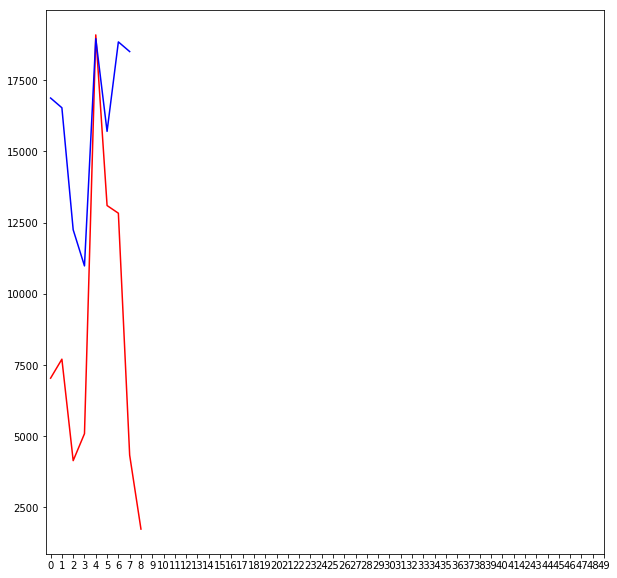


Time Taken :  2.762812376022339

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jan
Number of days present :  31
Start index :  24665
02
Stop index :  25409
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2016-01-15 00:00:00-06   0.3  1.56667  1.78333    120.2  323.217   
1  2016-01-16 00:00:00-06  0.15  13.5167     6.35  17659.6    776.8   
2  2016-01-17 00:00:00-06   0.2    16.65  11.9667  23282.4  2149.88   
3  2016-01-18 00:00:00-06   0.2       20  15.0167  22218.4  1952.78   
4  2016-01-19 00:00:00-06   0.4  10.0333  7.38333  13464.5  1355.12   

  waterheater1 total_thermal_load  
0      1179.05            1626.12  
1      3394.18            21850.6  
2       7056.8            32517.9  
3      8181.08            32387.5  
4      4025.13            18862.5  
(31, 8)
Inside extra trees :  (31

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 20780.6387097 max: 38450.049999999996 min: 1626.1166666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1626.12
1  NaN    NaN      NaN      NaN  1626.12  21850.6
2  NaN    NaN      NaN  1626.12  21850.6  32517.9
3  3.0    1.0  1626.12  21850.6  32517.9  32387.5
4  3.0    1.0  21850.6  32517.9  32387.5  18862.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.400197)
2. feature 2 (0.315957)
3. feature 3 (0.283846)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.211806450302
RMSE :  6097.10610316
MAE :  4734.77759259


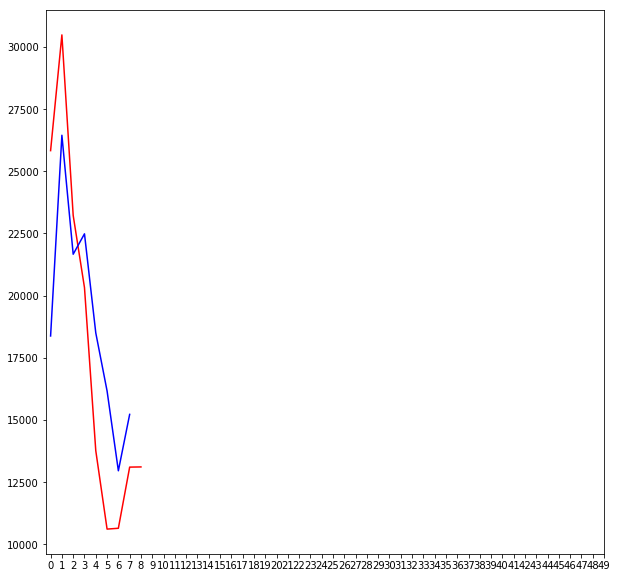


Time Taken :  2.6672990322113037

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Feb
Number of days present :  29
Start index :  25409
03
Stop index :  26104
From the loop :  (696, 8)
End i:  28
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2016-02-15 00:00:00-06      0.05  1.16667  406.117  1880.08  120.017   
1  2016-02-16 00:00:00-06       0.4  6.81667  1403.82  8195.25  591.533   
2  2016-02-17 00:00:00-06  0.716667      5.2  1703.72  5553.25  270.267   
3  2016-02-18 00:00:00-06       0.3      0.7  124.717  153.033  120.017   
4  2016-02-19 00:00:00-06       0.2     0.75  902.267    335.6  120.017   

  waterheater1 total_thermal_load  
0      4200.23            6607.67  
1       5336.9            15534.7  
2      3340.78            10873.9  
3      1099.27            1498.03  
4       801.35            2160.18  
(28, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (28, 8)
mean : 8717.66011905 max: 21752.916666666664 min: 1420.183333333333
Dimensions of temp :  (28, 2)


 Dimensions of ndf :  (28, 4)
Shape of ndf after merging :  (28, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  6607.67
1  NaN    NaN      NaN      NaN  6607.67  15534.7
2  NaN    NaN      NaN  6607.67  15534.7  10873.9
3  3.0    1.0  6607.67  15534.7  10873.9  1498.03
4  3.0    1.0  15534.7  10873.9  1498.03  2160.18
(25, 5) (25,)
        dow  month
count  25.0   25.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (17, 5) (8, 5) (17,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.517763)
2. feature 3 (0.290007)
3. feature 2 (0.192230)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.798774206252
RMSE :  5535.49575744
MAE :  4423.55182917


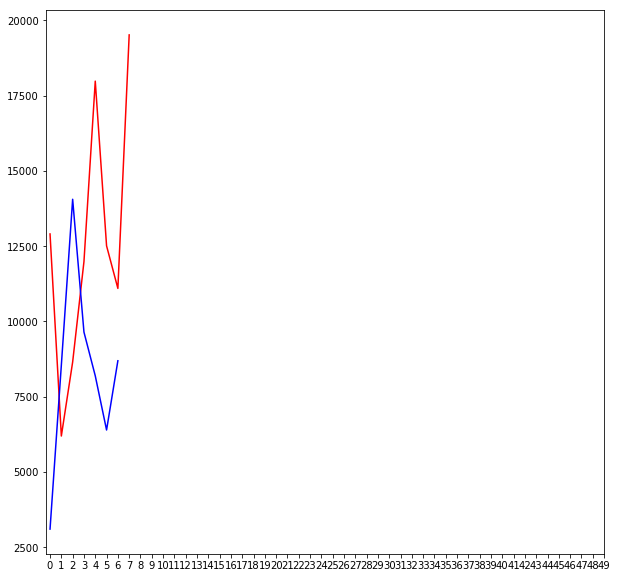


Time Taken :  2.6653318405151367

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Mar
Number of days present :  31
Start index :  26104
04
Stop index :  26848
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1      air2     air3 furnace1 furnace2  \
0  2016-03-15 00:00:00-05     0      0.05   6862.6  1603.32      120   
1  2016-03-16 00:00:00-05     0  0.383333  2374.93   1166.9   119.95   
2  2016-03-17 00:00:00-05     0         0  2025.68  595.567  119.983   
3  2016-03-18 00:00:00-05     0   1.16667  2647.72  755.583  119.933   
4  2016-03-19 00:00:00-05  0.05   12.3167  959.833  17361.4  119.967   

  waterheater1 total_thermal_load  
0      4130.32            12716.3  
1      4677.75            8339.92  
2      3672.33            6413.57  
3      4005.98            7530.38  
4      7067.83            25521.4  
(31, 8)
Inside extra trees

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



mean : 8935.7311828 max: 25568.766666666666 min: 1051.4333333333334
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  12716.3
1  NaN    NaN      NaN      NaN  12716.3  8339.92
2  NaN    NaN      NaN  12716.3  8339.92  6413.57
3  3.0    1.0  12716.3  8339.92  6413.57  7530.38
4  3.0    1.0  8339.92  6413.57  7530.38  25521.4
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.712250)
2. feature 3 (0.152047)
3. feature 2 (0.135703)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -3.75641828177
RMSE :  6479.42109953
MAE :  5605.86504815


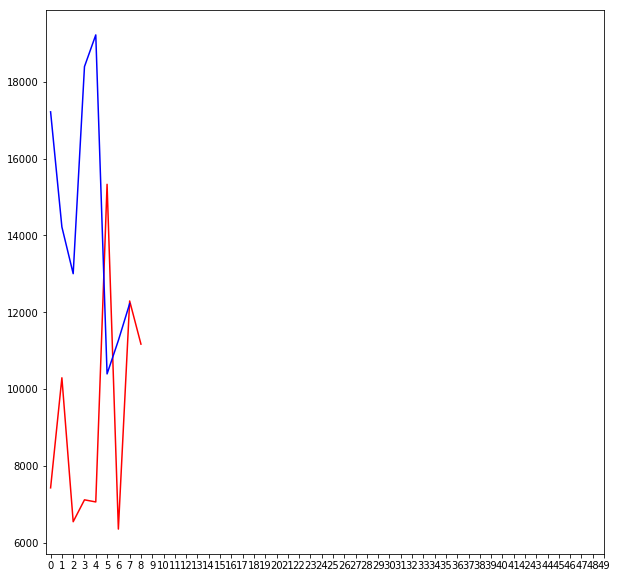


Time Taken :  2.8849093914031982

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Apr
Number of days present :  30
Start index :  26848
05
Stop index :  27568
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



                localhour  air1      air2     air3 furnace1 furnace2  \
0  2016-04-15 00:00:00-05     0   4.88333  1993.78  6411.75      120   
1  2016-04-16 00:00:00-05  0.05       0.8  515.417    255.9  119.783   
2  2016-04-17 00:00:00-05     0         0  31.5333  141.483      120   
3  2016-04-18 00:00:00-05     0   1.71667     10.5  126.383  120.017   
4  2016-04-19 00:00:00-05     0  0.583333   850.15  325.717  119.883   

  waterheater1 total_thermal_load  
0      2707.23            11237.6  
1      6064.07            6956.02  
2      9008.23            9301.25  
3      6615.93            6874.55  
4      5138.93            6435.27  
(30, 8)
Inside extra trees :  (30, 8)
mean : 12136.5144444 max: 26059.31666666666 min: 6435.2666666666655
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  11237.6
1  NaN    NaN      NaN      NaN  11237.6  69

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.262014542164
RMSE :  6747.98180977
MAE :  4333.58057037


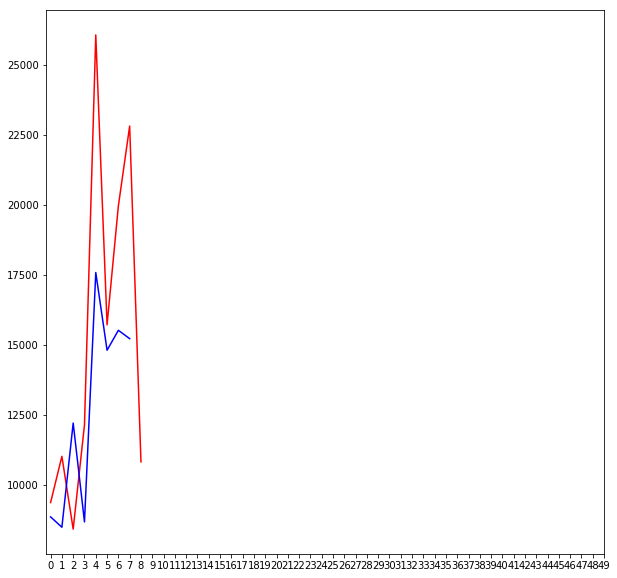


Time Taken :  2.7507364749908447

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  May
Number of days present :  31
Start index :  27568
06
Stop index :  28312
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour air1      air2    air3 furnace1 furnace2  \
0  2016-05-15 00:00:00-05    0  0.433333   706.2  311.967  119.933   
1  2016-05-16 00:00:00-05    0   1.16667  459.75  229.533  119.983   
2  2016-05-17 00:00:00-05    0      1.35  298.05   186.65      120   
3  2016-05-18 00:00:00-05    0       0.2    1.65  120.217  119.933   
4  2016-05-19 00:00:00-05    0       1.1     1.7    120.3  120.083   

  waterheater1 total_thermal_load  
0      4711.48            5850.02  
1      2245.45            3055.88  
2       1335.9            1941.95  
3      1201.87            1443.87  
4      1208.62             1451.8  
(31, 8)
Inside extra trees :  (31, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


25869.666666666664 min: 652.3666666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  5850.02
1  NaN    NaN      NaN      NaN  5850.02  3055.88
2  NaN    NaN      NaN  5850.02  3055.88  1941.95
3  3.0    1.0  5850.02  3055.88  1941.95  1443.87
4  3.0    1.0  3055.88  1941.95  1443.87   1451.8
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.415114)
2. feature 2 (0.297878)
3. feature 3 (0.287008)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -11.8112008052
RMSE :  17545.1632088
MAE :  16833.7020333


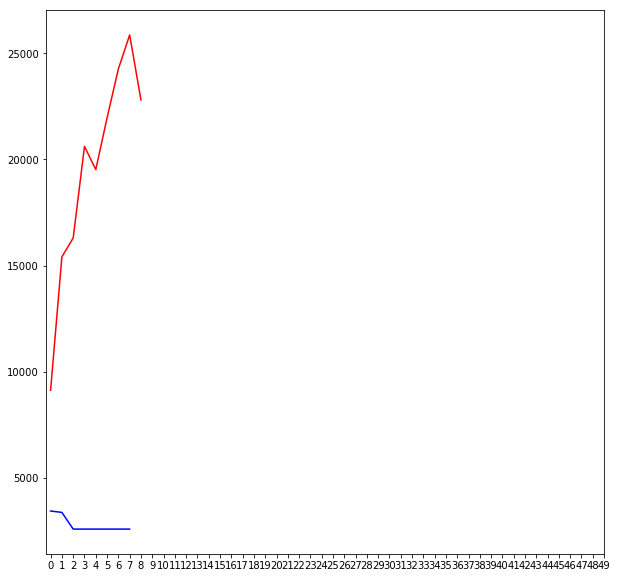


Time Taken :  2.677926540374756

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jun
Number of days present :  30
Start index :  28312
07
Stop index :  29032
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-06-15 00:00:00-05  13521.2  5409.17  4856.63  1079.65  760.767   
1  2016-06-16 00:00:00-05  14485.6  5012.82  4623.78  1034.33  709.033   
2  2016-06-17 00:00:00-05  15292.4  4772.17  5005.03  1105.32   673.65   
3  2016-06-18 00:00:00-05  15513.3  10571.6  5190.13   1141.7  1394.72   
4  2016-06-19 00:00:00-05  13559.7  4872.73  4211.22  981.183  721.467   

  waterheater1 total_thermal_load  
0      451.433            26078.8  
1      466.017            26331.6  
2      910.867            27759.5  
3      451.733            34263.2  
4        434.9            24781.2  
(30, 8)
Inside 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  26078.8
1  NaN    NaN      NaN      NaN  26078.8  26331.6
2  NaN    NaN      NaN  26078.8  26331.6  27759.5
3  3.0    1.0  26078.8  26331.6  27759.5  34263.2
4  3.0    1.0  26331.6  27759.5  34263.2  24781.2
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.515034)
2. feature 2 (0.243701)
3. feature 3 (0.241265)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.794321244963
RMSE :  4142.16989511
MAE :  3272.23104815


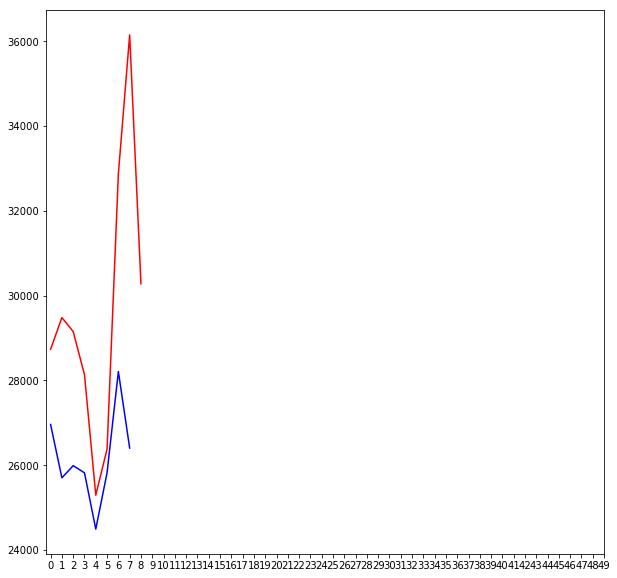


Time Taken :  2.6745805740356445

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Jul
Number of days present :  31
Start index :  29032
08
Stop index :  29776
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-07-15 00:00:00-05  17309.3  6326.93  5981.25  1270.85  841.483   
1  2016-07-16 00:00:00-05    13355     7345   5597.7  1210.08  978.917   
2  2016-07-17 00:00:00-05    17595  1251.97  5126.45  1118.85  269.967   
3  2016-07-18 00:00:00-05  14409.7  7213.25  5107.57  1126.03   965.85   
4  2016-07-19 00:00:00-05  16581.9   4278.5  5282.47  1165.93   628.95   

  waterheater1 total_thermal_load  
0      434.767            32164.6  
1      868.267              29355  
2      434.317            25796.5  
3        440.5            29262.9  
4      867.117            28804.8  


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(31, 8)
Inside extra trees :  (31, 8)
mean : 27949.5354839 max: 37530.45 min: 8633.616666666665
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  32164.6
1  NaN    NaN      NaN      NaN  32164.6    29355
2  NaN    NaN      NaN  32164.6    29355  25796.5
3  3.0    1.0  32164.6    29355  25796.5  29262.9
4  3.0    1.0    29355  25796.5  29262.9  28804.8
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.620927)
2. feature 2 (0.192651)
3. feature 3 (0.186423)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.358966261107
RMSE :  10304.7110545
MAE :  8055.30381481


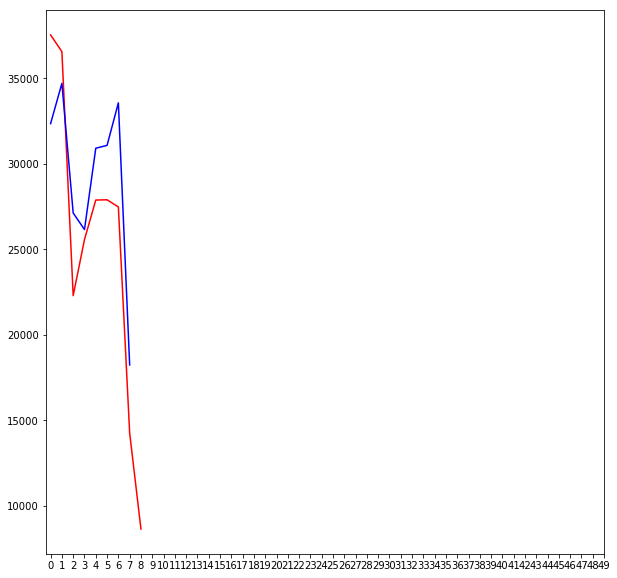


Time Taken :  2.66414213180542

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Aug
Number of days present :  31
Start index :  29776
09
Stop index :  30520
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-08-15 00:00:00-05  3297.28  0.583333      1.2   120.85  118.317   
1  2016-08-16 00:00:00-05  6113.72   1.18333      1.8  120.283  117.033   
2  2016-08-17 00:00:00-05  5921.77   2297.38      1.2   120.65   441.75   
3  2016-08-18 00:00:00-05  6900.73   2071.73    521.9   238.35    402.2   
4  2016-08-19 00:00:00-05  9920.82   6955.55  3047.28  744.433  995.267   

  waterheater1 total_thermal_load  
0      843.983            4382.22  
1      1288.37            7642.38  
2      839.583            9622.33  
3      867.783            11002.7  
4      417.267            22080.6  
(31, 8)
In

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(31, 8)
mean : 17035.272043 max: 25947.916666666668 min: 4382.216666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  4382.22
1  NaN    NaN      NaN      NaN  4382.22  7642.38
2  NaN    NaN      NaN  4382.22  7642.38  9622.33
3  3.0    1.0  4382.22  7642.38  9622.33  11002.7
4  3.0    1.0  7642.38  9622.33  11002.7  22080.6
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.458225)
2. feature 3 (0.285597)
3. feature 2 (0.256178)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.23697657006
RMSE :  5363.28220854
MAE :  3967.02480741


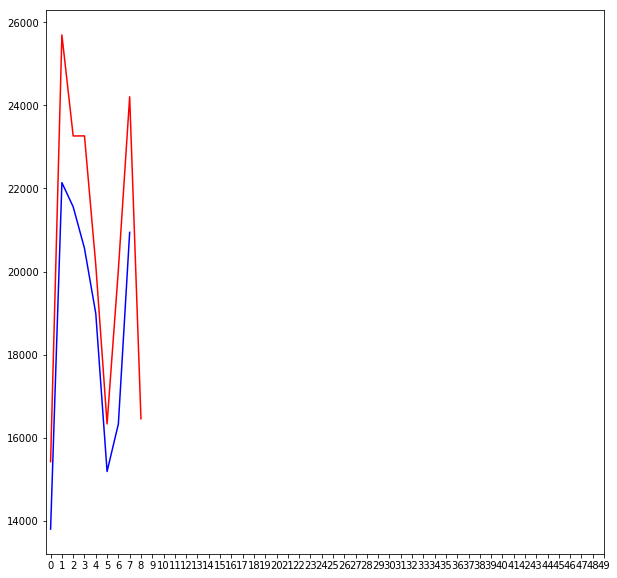


Time Taken :  2.737203359603882

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Sept
Number of days present :  30
Start index :  30520
Stop index :  31240
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-09-15 00:00:00-05    10420  4524.47  3705.95   874.75   682.65   
1  2016-09-16 00:00:00-05    11363  4034.07  3929.45  915.217   624.95   
2  2016-09-17 00:00:00-05  12742.5  5471.52  4665.58  1049.77  783.767   
3  2016-09-18 00:00:00-05  14112.5  3985.82  5509.52  1188.62    593.8   
4  2016-09-19 00:00:00-05  15282.4  4120.17  6081.32  1310.17  596.483   

  waterheater1 total_thermal_load  
0       418.95            20626.7  
1      857.767            21724.5  
2      437.717            25150.9  
3      894.067            26284.4  
4      437.883            27828.5  
(30, 8)
Inside ex

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 12975.9838889 max: 28481.699999999997 min: 1067.5833333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  20626.7
1  NaN    NaN      NaN      NaN  20626.7  21724.5
2  NaN    NaN      NaN  20626.7  21724.5  25150.9
3  3.0    1.0  20626.7  21724.5  25150.9  26284.4
4  3.0    1.0  21724.5  25150.9  26284.4  27828.5
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.805444)
2. feature 3 (0.151590)
3. feature 2 (0.042966)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.325307444408
RMSE :  6518.6382152
MAE :  5767.79129259


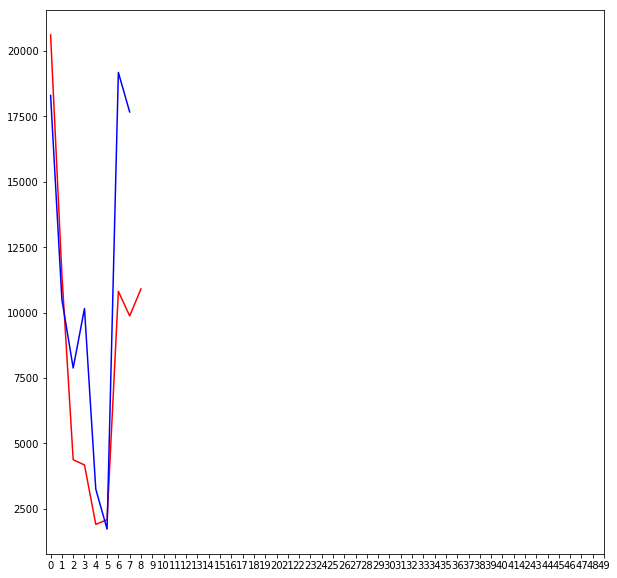


Time Taken :  2.657586097717285

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Oct
Number of days present :  31
Start index :  31240
Stop index :  31985
From the loop :  (746, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2016-10-15 00:00:00-05  7656.72  866.633  2454.63  634.133  227.817   
1  2016-10-16 00:00:00-05  10605.2   2208.7  3831.12  898.833  390.167   
2  2016-10-17 00:00:00-05  10178.4   1779.9  4019.33   939.55  339.667   
3  2016-10-18 00:00:00-05  9223.88  2181.07  3151.87  780.383    390.2   
4  2016-10-19 00:00:00-05  8733.77  3367.48  3415.45  834.033   558.05   

  waterheater1 total_thermal_load  
0      855.167            12695.1  
1        844.7            18778.7  
2      839.867            18096.7  
3       418.55            16145.9  
4      858.083            17766.9  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



(31, 8)
Inside extra trees :  (31, 8)
mean : 7360.40806452 max: 18778.699999999997 min: 1058.25
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  12695.1
1  NaN    NaN      NaN      NaN  12695.1  18778.7
2  NaN    NaN      NaN  12695.1  18778.7  18096.7
3  3.0    1.0  12695.1  18778.7  18096.7  16145.9
4  3.0    1.0  18778.7  18096.7  16145.9  17766.9
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.669530)
2. feature 3 (0.219621)
3. feature 2 (0.110849)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -9.94957900951
RMSE :  5509.14194553
MAE :  4448.76933333


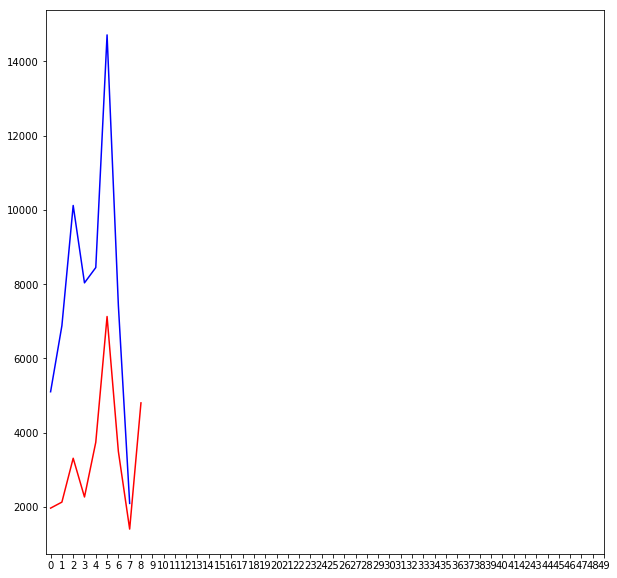


Time Taken :  2.6688122749328613

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Nov
Number of days present :  30
Start index :  31985
Stop index :  32705
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2016-11-15 00:00:00-06     0      1.9     4.55  120.567  119.883   
1  2016-11-16 00:00:00-06   0.1     0.85  605.917   252.85   120.05   
2  2016-11-17 00:00:00-06     0  2.16667  2123.05  562.767  120.067   
3  2016-11-18 00:00:00-06     0      2.1  198.183    172.3  120.117   
4  2016-11-19 00:00:00-06  0.25  3.31667  1.88333    120.1   119.95   

  waterheater1 total_thermal_load  
0      3179.57            3426.47  
1       1451.3            2431.07  
2      2489.37            5297.42  
3      4280.87            4773.57  
4      1153.07            1398.57  
(30, 8)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Inside extra trees :  (30, 8)
mean : 5377.91055556 max: 36435.68333333333 min: 1042.7833333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  3426.47
1  NaN    NaN      NaN      NaN  3426.47  2431.07
2  NaN    NaN      NaN  3426.47  2431.07  5297.42
3  3.0    1.0  3426.47  2431.07  5297.42  4773.57
4  3.0    1.0  2431.07  5297.42  4773.57  1398.57
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.417948)
2. feature 2 (0.313455)
3. feature 3 (0.268597)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.548804039549
RMSE :  15731.9324869
MAE :  9681.95795926


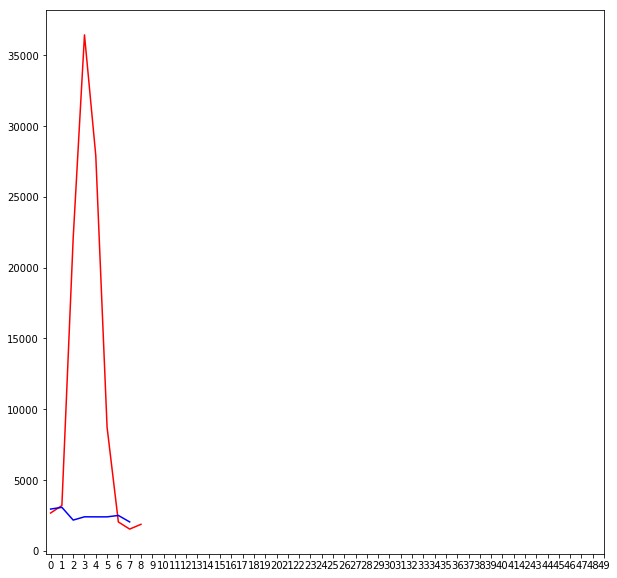


Time Taken :  2.6751317977905273

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2016

Month :  Dec
Number of days present :  31
Start index :  32705
01
Stop index :  33449
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2016-12-15 00:00:00-06      0.45  9.28333      2.7  9500.03  1682.25   
1  2016-12-16 00:00:00-06  0.816667  2.68333      1.6   120.15  1019.27   
2  2016-12-17 00:00:00-06      0.05      0.7     2.35  120.233   231.15   
3  2016-12-18 00:00:00-06  0.633333  22.1333  2.53333  29016.7  3488.15   
4  2016-12-19 00:00:00-06       0.8  21.4667  3.36667  29382.4  2220.82   

  waterheater1 total_thermal_load  
0      1928.85            13123.6  
1      1143.07            2287.58  
2      1581.18            1935.67  
3      1600.27            34130.4  
4      1959.43            33588.3  
(31, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


min: 1254.683333333333
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  13123.6
1  NaN    NaN      NaN      NaN  13123.6  2287.58
2  NaN    NaN      NaN  13123.6  2287.58  1935.67
3  3.0    1.0  13123.6  2287.58  1935.67  34130.4
4  3.0    1.0  2287.58  1935.67  34130.4  33588.3
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.505207)
2. feature 2 (0.307748)
3. feature 3 (0.187045)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.175579668951
RMSE :  12369.1068325
MAE :  7946.66907037


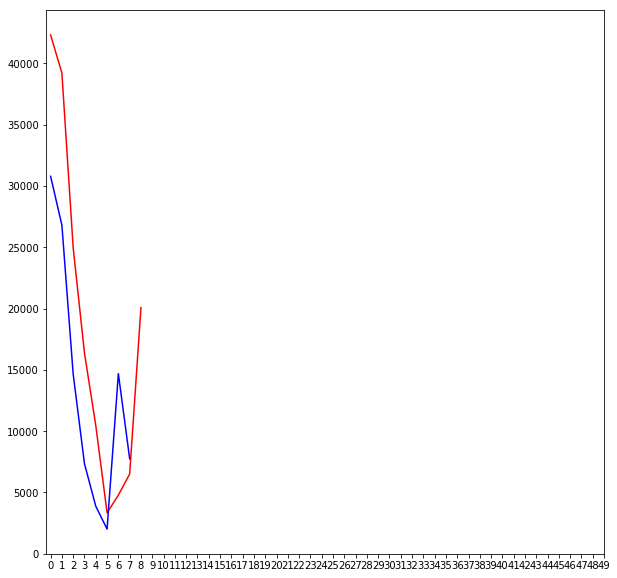


Time Taken :  2.7538976669311523

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jan
Number of days present :  31
Start index :  33449
02
Stop index :  34193
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2017-01-15 00:00:00-06   0.5  12.8333      6.5  13935.3  875.733   
1  2017-01-16 00:00:00-06  0.15      6.2  4.51667     5958  120.083   
2  2017-01-17 00:00:00-06  0.15    19.65  6.26667  24324.7  1618.77   
3  2017-01-18 00:00:00-06   0.5  21.3333  7.31667  28226.9  2395.73   
4  2017-01-19 00:00:00-06     0  8.83333  6.36667    11646  1227.23   

  waterheater1 total_thermal_load  
0      3721.58            18552.5  
1      2808.53            8897.48  
2      3491.12            29460.6  
3      3912.05            34563.8  
4      3555.07            16443.5  
(31, 8)
Inside extra trees :  (3

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 2102.016666666666
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  18552.5
1  NaN    NaN      NaN      NaN  18552.5  8897.48
2  NaN    NaN      NaN  18552.5  8897.48  29460.6
3  3.0    1.0  18552.5  8897.48  29460.6  34563.8
4  3.0    1.0  8897.48  29460.6  34563.8  16443.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.480829)
2. feature 3 (0.326769)
3. feature 2 (0.192403)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -4.00905122784
RMSE :  8426.52306128
MAE :  6892.55502593


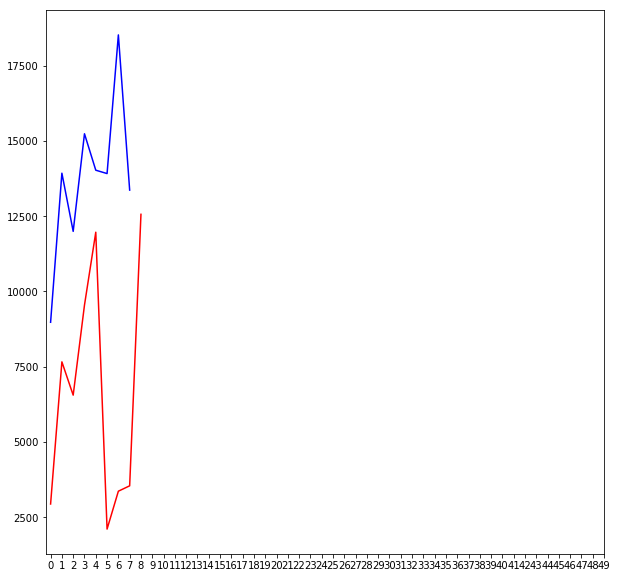


Time Taken :  2.643552541732788

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Feb
Number of days present :  28
Start index :  34193
03
Stop index :  34864
From the loop :  (672, 8)
End i:  27
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1     air2     air3 furnace1 furnace2  \
0  2017-02-15 00:00:00-06   1.41667  11.2667  6.58333  14682.5  1193.98   
1  2017-02-16 00:00:00-06  0.266667  13.8167  5.46667  13966.1  1217.98   
2  2017-02-17 00:00:00-06  0.466667       11  6.03333   8156.5  644.417   
3  2017-02-18 00:00:00-06       0.1  3.13333      4.2  122.783  119.933   
4  2017-02-19 00:00:00-06   1648.97  1.08333  1755.28  497.817  119.033   

  waterheater1 total_thermal_load  
0      3490.43            19386.2  
1      3386.58            18590.2  
2      3566.63              12385  
3      2658.32            2908.47  
4      2953.65            6975.83  
(27, 8)
I

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (27, 8)
mean : 5878.04259259 max: 19560.5 min: 1420.2333333333333
Dimensions of temp :  (27, 2)


 Dimensions of ndf :  (27, 4)
Shape of ndf after merging :  (27, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  19386.2
1  NaN    NaN      NaN      NaN  19386.2  18590.2
2  NaN    NaN      NaN  19386.2  18590.2    12385
3  3.0    1.0  19386.2  18590.2    12385  2908.47
4  3.0    1.0  18590.2    12385  2908.47  6975.83
(24, 5) (24,)
        dow  month
count  24.0   24.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (16, 5) (8, 5) (16,) (8,)
Feature ranking according to the ETR : 
1. feature 4 (0.401777)
2. feature 3 (0.325421)
3. feature 2 (0.272802)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -3.63434892463
RMSE :  2201.24596831
MAE :  1613.87940417


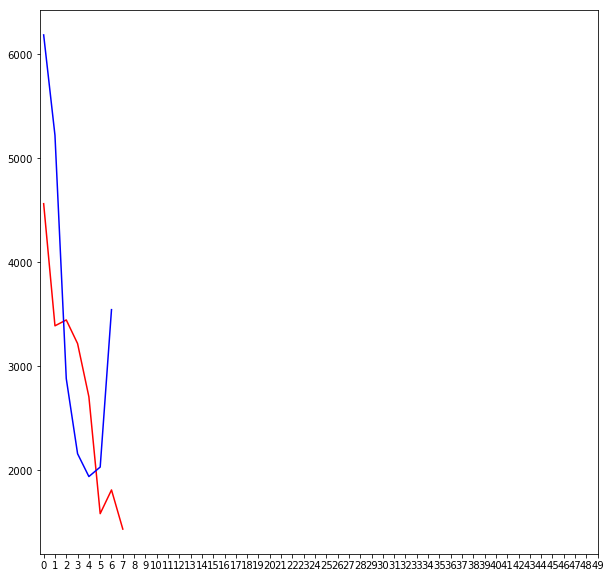


Time Taken :  2.6550958156585693

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Mar
Number of days present :  31
Start index :  34864
04
Stop index :  35608
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour    air1      air2     air3 furnace1 furnace2  \
0  2017-03-15 00:00:00-05       0  0.833333      2.2  120.167   120.05   
1  2017-03-16 00:00:00-05       0         0      2.3  120.333      120   
2  2017-03-17 00:00:00-05     0.3      0.75  1.58333  120.183  120.067   
3  2017-03-18 00:00:00-05       0   1.28333  1.86667  121.283  119.933   
4  2017-03-19 00:00:00-05  2488.3  0.583333        2  120.217  118.683   

  waterheater1 total_thermal_load  
0      1139.75               1383  
1      1181.05            1423.68  
2       821.15            1064.03  
3      944.683            1189.05  
4      1051.18            3780.97  
(31, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (31, 8)
mean : 3934.38225806 max: 11867.666666666666 min: 1064.0333333333333
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN     1383
1  NaN    NaN      NaN      NaN     1383  1423.68
2  NaN    NaN      NaN     1383  1423.68  1064.03
3  3.0    1.0     1383  1423.68  1064.03  1189.05
4  3.0    1.0  1423.68  1064.03  1189.05  3780.97
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 2 (0.396425)
2. feature 3 (0.323139)
3. feature 4 (0.280435)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 1 2] 



R2 Score :  -2.21555704095
RMSE :  2645.75966117
MAE :  2178.02133704


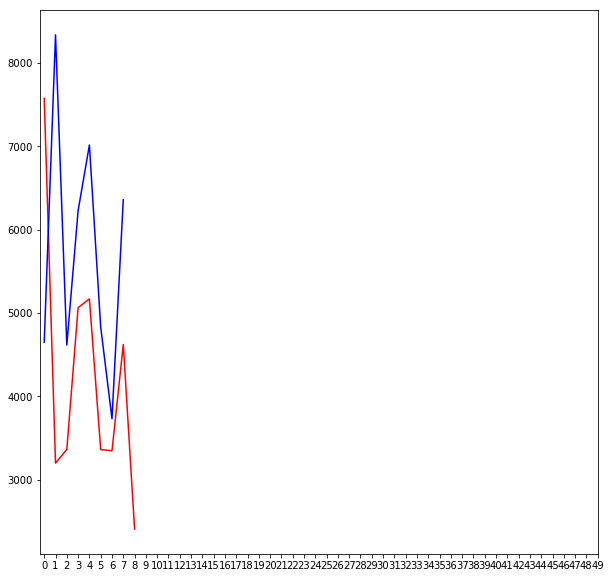


Time Taken :  2.6661579608917236

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Apr
Number of days present :  30
Start index :  35608
05
Stop index :  36328
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1      air2     air3 furnace1 furnace2  \
0  2017-04-15 00:00:00-05     0       0.3     1.65   120.45  119.933   
1  2017-04-16 00:00:00-05     0       0.8      1.6  120.167  119.817   
2  2017-04-17 00:00:00-05     0  0.366667      2.4  120.083  119.917   
3  2017-04-18 00:00:00-05     0  0.466667  1.46667  120.017  119.867   
4  2017-04-19 00:00:00-05  0.05   1.33333  1.58333  120.117  120.133   

  waterheater1 total_thermal_load  
0      812.017            1054.35  
1      844.333            1086.72  
2      1243.85            1486.62  
3      786.883             1028.7  
4      816.233            1059.45  
(30, 8)
Inside extra trees

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 8)
mean : 2714.66222222 max: 9794.783333333331 min: 1028.7
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1054.35
1  NaN    NaN      NaN      NaN  1054.35  1086.72
2  NaN    NaN      NaN  1054.35  1086.72  1486.62
3  3.0    1.0  1054.35  1086.72  1486.62   1028.7
4  3.0    1.0  1086.72  1486.62   1028.7  1059.45
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.395508)
2. feature 4 (0.303804)
3. feature 2 (0.300688)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.601766624579
RMSE :  4375.68935357
MAE :  3450.28132593


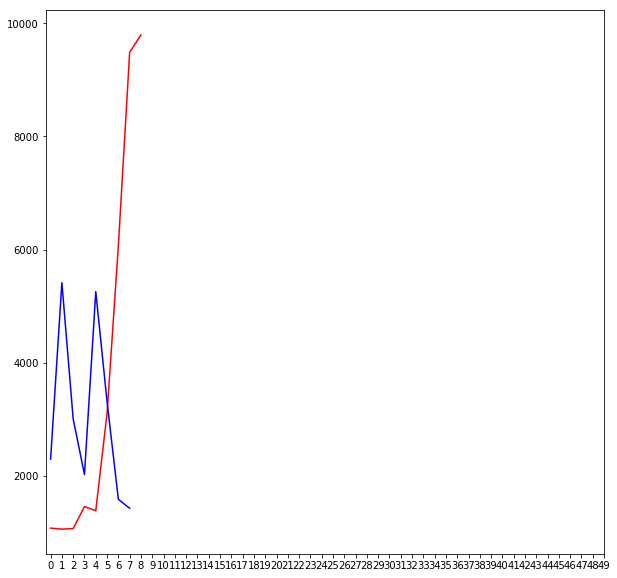


Time Taken :  2.7735440731048584

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  May
Number of days present :  31
Start index :  36328
06
Stop index :  37072
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2017-05-15 00:00:00-05  4859.57   1638.65  2949.67  741.033    336.8   
1  2017-05-16 00:00:00-05  1797.53       0.2  283.833   181.45  118.417   
2  2017-05-17 00:00:00-05  2424.82  0.366667  1544.37  456.183   117.35   
3  2017-05-18 00:00:00-05  11983.3   1175.27   2723.7   694.05  272.767   
4  2017-05-19 00:00:00-05  6952.05   5543.07  3602.03  869.917  834.567   

  waterheater1 total_thermal_load  
0      1790.27              12316  
1      1204.05            3585.48  
2      788.833            5331.92  
3       826.55            17675.6  
4      834.867            18636.5  


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(31, 8)
Inside extra trees :  (31, 8)
mean : 11590.2887097 max: 27211.516666666666 min: 1448.9666666666667
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    12316
1  NaN    NaN      NaN      NaN    12316  3585.48
2  NaN    NaN      NaN    12316  3585.48  5331.92
3  3.0    1.0    12316  3585.48  5331.92  17675.6
4  3.0    1.0  3585.48  5331.92  17675.6  18636.5
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.349083)
2. feature 2 (0.330403)
3. feature 3 (0.320514)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.243485851782
RMSE :  5442.68914381
MAE :  4463.24848889


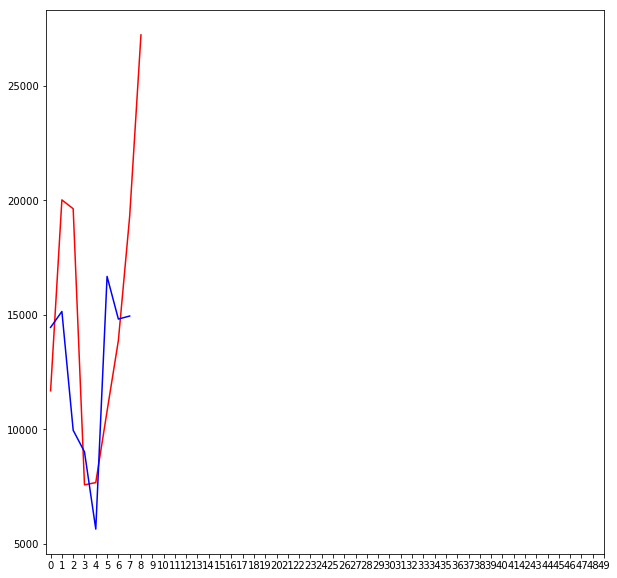


Time Taken :  2.6669139862060547

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jun
Number of days present :  30
Start index :  37072
07
Stop index :  37792
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-06-15 00:00:00-05  10830.5   6243.1  5528.53   1204.8  862.033   
1  2017-06-16 00:00:00-05  15894.6  6831.53  6286.12  1347.83  926.917   
2  2017-06-17 00:00:00-05  16210.9   6091.6  6519.27   1391.2   815.65   
3  2017-06-18 00:00:00-05  15637.5   5416.2  6378.55   1370.2    746.8   
4  2017-06-19 00:00:00-05  8645.65  2992.12  2799.88  719.317   514.25   

  waterheater1 total_thermal_load  
0       419.75            25088.7  
1        846.3            32133.3  
2          426            31454.6  
3      859.167            30408.4  
4      839.383            16510.6  
(30, 8)
Inside

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 27063.8922222 max: 37122.08333333333 min: 15474.916666666664
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  25088.7
1  NaN    NaN      NaN      NaN  25088.7  32133.3
2  NaN    NaN      NaN  25088.7  32133.3  31454.6
3  3.0    1.0  25088.7  32133.3  31454.6  30408.4
4  3.0    1.0  32133.3  31454.6  30408.4  16510.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.559689)
2. feature 2 (0.220681)
3. feature 3 (0.219630)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -6.46515089742
RMSE :  8788.26487621
MAE :  7804.71751111


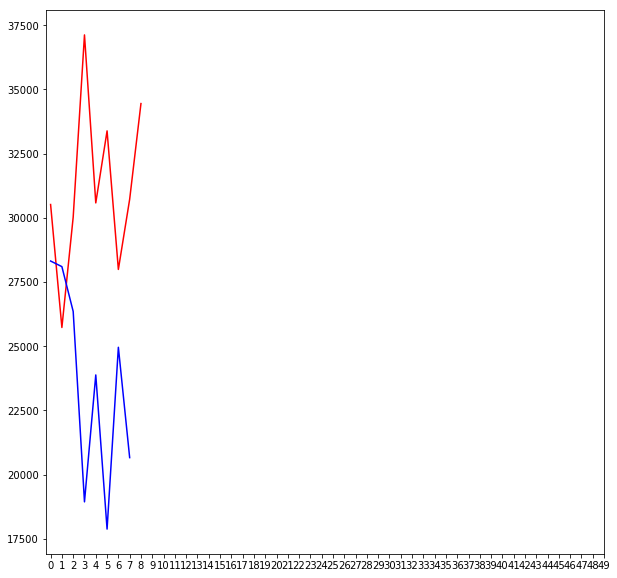


Time Taken :  2.673581838607788

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Jul
Number of days present :  31
Start index :  37792
08
Stop index :  38536
From the loop :  (745, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-07-15 00:00:00-05  13998.6   5651.8   3755.9    866.8  859.233   
1  2017-07-16 00:00:00-05  11442.2  5020.05  3589.78   830.15    733.7   
2  2017-07-17 00:00:00-05  13646.6  6086.53   4265.3  967.983  886.233   
3  2017-07-18 00:00:00-05  14121.5  6554.48  5177.18  1131.33   927.15   
4  2017-07-19 00:00:00-05  16843.1  6320.73  5776.73  1254.02   901.05   

  waterheater1 total_thermal_load  
0      434.617            25566.9  
1       848.95            22464.8  
2      411.817            26264.4  
3      849.733            28761.4  
4      407.983            31503.6  
(31, 8)
Inside 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (31, 8)
mean : 30587.7537634 max: 57268.93333333333 min: 8890.683333333332
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  25566.9
1  NaN    NaN      NaN      NaN  25566.9  22464.8
2  NaN    NaN      NaN  25566.9  22464.8  26264.4
3  3.0    1.0  25566.9  22464.8  26264.4  28761.4
4  3.0    1.0  22464.8  26264.4  28761.4  31503.6
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.486479)
2. feature 2 (0.308490)
3. feature 3 (0.205030)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.360577542175
RMSE :  10785.7098224
MAE :  7640.99764444


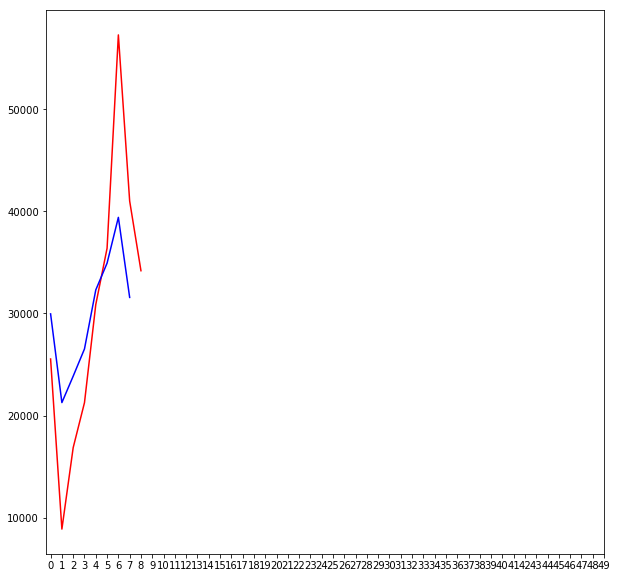


Time Taken :  2.6588134765625

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Aug
Number of days present :  31
Start index :  38536
09
Stop index :  39280
From the loop :  (745, 8)
End i:  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-08-15 00:00:00-05  17757.5  6766.55   5267.6  1117.02  914.317   
1  2017-08-16 00:00:00-05  10289.5  948.183   4828.4   1036.4    224.1   
2  2017-08-17 00:00:00-05  12133.1  3322.77  5337.48   1125.6  494.217   
3  2017-08-18 00:00:00-05  12140.9  3347.93  5428.62  1144.22   498.15   
4  2017-08-19 00:00:00-05  13095.7  3824.43  5648.27  1165.93  545.817   

  waterheater1 total_thermal_load  
0      421.417            32244.4  
1      872.533            18199.1  
2       432.95            22846.1  
3      429.383            22989.2  
4      435.917            24716.1  
(31, 8)
Inside extra trees :  (31, 8)
mean : 14038.7639785 max: 32244.41666666666 min: 1495.9999999999995
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    Na

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.843521309668
RMSE :  7168.44203111
MAE :  5760.18204815


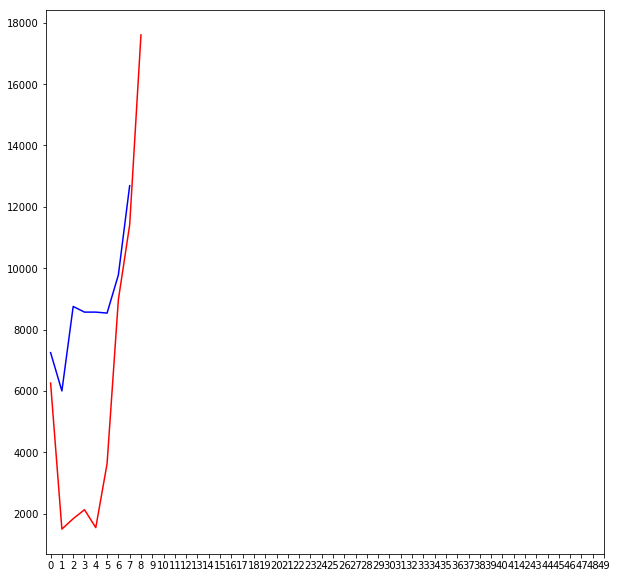


Time Taken :  2.672483444213867

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Sept
Number of days present :  30
Start index :  39280
Stop index :  40000
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-09-15 00:00:00-05  10937.1     3582  7637.98  1665.78  584.817   
1  2017-09-16 00:00:00-05  12363.3   5854.7  10834.5  2339.95   858.65   
2  2017-09-17 00:00:00-05  13292.9  3685.07  6066.78  1385.42    580.6   
3  2017-09-18 00:00:00-05  12930.1     3582  4767.45  1052.48  557.683   
4  2017-09-19 00:00:00-05  11018.5  3204.92  4825.88  1083.75  515.417   

  waterheater1 total_thermal_load  
0      848.467            25256.1  
1      2211.63            34462.7  
2       2555.1            27565.8  
3      836.967            23726.6  
4      419.633            21068.1  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



(30, 8)
Inside extra trees :  (30, 8)
mean : 14300.7666667 max: 34462.73333333333 min: 1466.3333333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  25256.1
1  NaN    NaN      NaN      NaN  25256.1  34462.7
2  NaN    NaN      NaN  25256.1  34462.7  27565.8
3  3.0    1.0  25256.1  34462.7  27565.8  23726.6
4  3.0    1.0  34462.7  27565.8  23726.6  21068.1
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.358017)
2. feature 4 (0.331874)
3. feature 2 (0.310110)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.261211091279
RMSE :  7114.03998641
MAE :  6140.04871481


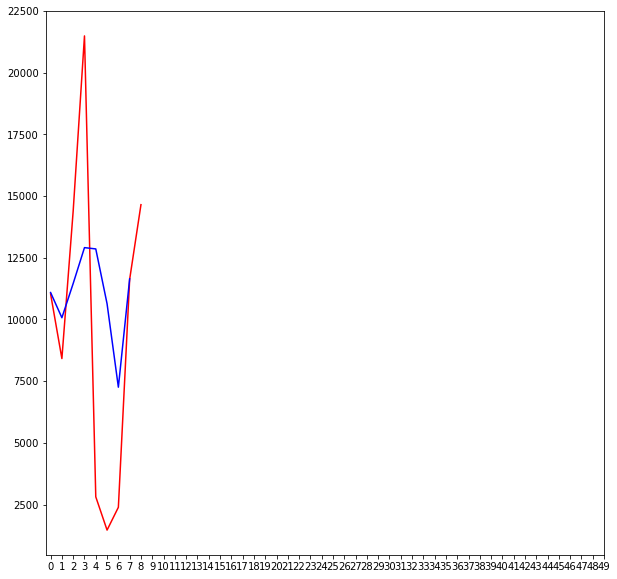


Time Taken :  2.9447383880615234

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Oct
Number of days present :  31
Start index :  40000
Stop index :  40745
From the loop :  (746, 8)
End i:  31
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2017-10-15 00:00:00-05  2544.13  0.266667     91.8  140.433  118.517   
1  2017-10-16 00:00:00-05        0       0.4      1.8  120.017  120.017   
2  2017-10-17 00:00:00-05        0  0.466667  1.26667  123.667  119.933   
3  2017-10-18 00:00:00-05     0.05      1.65      1.7   121.05   119.95   
4  2017-10-19 00:00:00-05        0  0.316667      1.2  119.917  119.917   

  waterheater1 total_thermal_load  
0      841.633            3736.78  
1      1240.38            1482.62  
2      832.233            1077.57  
3      1237.18            1481.58  
4      827.917            1069.27  
(31, 8)
Ins

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


mean : 2592.19784946 max: 10625.416666666666 min: 1054.55
Dimensions of temp :  (31, 2)


 Dimensions of ndf :  (31, 4)
Shape of ndf after merging :  (31, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  3736.78
1  NaN    NaN      NaN      NaN  3736.78  1482.62
2  NaN    NaN      NaN  3736.78  1482.62  1077.57
3  3.0    1.0  3736.78  1482.62  1077.57  1481.58
4  3.0    1.0  1482.62  1077.57  1481.58  1069.27
(28, 5) (28,)
        dow  month
count  28.0   28.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (19, 5) (9, 5) (19,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.493969)
2. feature 2 (0.255310)
3. feature 3 (0.250721)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.146656175388
RMSE :  2913.21064819
MAE :  1904.23064444


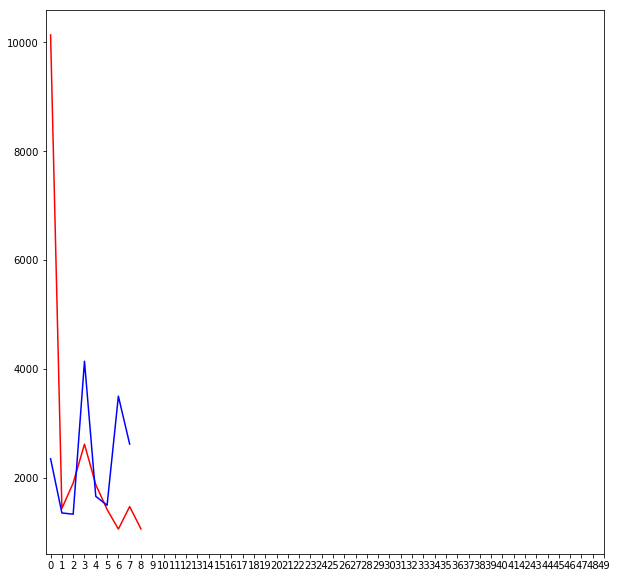


Time Taken :  2.6643667221069336

 {'R2': 0.25703498629934518, 'RMSE': 6683.8493535662965, 'MAE': 5326.8441291666195}

Year :  2017

Month :  Nov
Number of days present :  16

Year :  2017

Month :  Dec
Number of days present :  0


In [84]:
'''
Checking how many days are present in each day of the month, for the entire dataset.
Checks for the month period starting from 15 - 15 (of the next month).
'''
master_dict={}
year = [2013,2014,2015,2016,2017]
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
month_days = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]

for y in year:
    flag=0
    year_temp=y
    for m in month:
        print("\nYear : ",y)
        print("\nMonth : ",month_days[int(m)-1])
        num_hours = np.sum(df_new_thermal["localhour"].str.contains(str(y)+"-"+m))
        num_days = np.sum(new_df1["localhour"].str.contains(str(y)+"-"+m))
        print ( "Number of days present : " , num_days )
        
        #Only train a model, if there are sufficient number of days, i.e >= 672 (hours)
        if (num_days >= 28):
            
            #Get the correct year number.
            if(int(m) == 12):
                year_temp = year_temp+1
                if(year_temp == 2018): 
                    flag=1
                    break
                    
            start_index = pd.DataFrame(df_new_thermal[df_new_thermal["localhour"].str.contains(str(y)+"-"+m+"-15")],columns = df_new_thermal.columns).index[0]
            print ("Start index : ",start_index)
            
            #Get the month number, of the next month.
            temp = str(int(m) + 1)
            if (int(temp) < 10):
                temp = "0" + temp
                print (temp)
            elif (int(temp) == 13):
                temp = "01"
                print (temp)
                
            stop_index = pd.DataFrame(df_new_thermal[df_new_thermal["localhour"].str.contains(str(year_temp) + "-" + temp + "-15")],columns = df_new_thermal.columns).index[0]
            print ("Stop index : ",stop_index)
            monthdf = df_new_thermal.iloc[start_index:(stop_index+1)]
            
            print ("From the loop : ",monthdf.shape)
            #Now, pass it to the model.
            thermal_dict = {}
            ti = time.time()
            thermal_dict,y_test1,y_pred1 = extra_trees(monthdf,thermal_dict,1,"mean_squared_error",7,day_hour)
            tf = time.time()
            print ("\nTime Taken : ",tf-ti)
            print ("\n",thermal_dict1)
            master_dict[str(y)+"-"+m] = thermal_dict
    if(flag==1):
        break


In [85]:
'''
Viewing the performance of the model on the months. The dicitonary corresponds to the above piece of code
15 of one month to 15th of the next month.
'''
for key,val in master_dict.items():
    print (key," - ",val,"\n")

2013-04  -  {'R2': -16.591307900769909, 'RMSE': 6067.10396044769, 'MAE': 5766.4521962962854} 

2013-05  -  {'R2': -0.88580506514069146, 'RMSE': 9742.3929894639623, 'MAE': 8584.7007296296342} 

2013-06  -  {'R2': -0.99114798694355266, 'RMSE': 9620.8373300772091, 'MAE': 7284.9901814815075} 

2013-07  -  {'R2': -2.2742120020931069, 'RMSE': 7748.6753897221988, 'MAE': 6578.2979703704796} 

2013-08  -  {'R2': -0.55514117801567253, 'RMSE': 7726.1909066728049, 'MAE': 6415.4231629629903} 

2013-09  -  {'R2': -0.058647633819311373, 'RMSE': 7488.5082720401724, 'MAE': 6683.5386666666564} 

2013-10  -  {'R2': 0.35256384334143098, 'RMSE': 1600.7047796968732, 'MAE': 922.19919629629817} 

2013-11  -  {'R2': -1.3845344192461666, 'RMSE': 20541.900038770822, 'MAE': 17098.29197777775} 

2013-12  -  {'R2': 0.28385486018614225, 'RMSE': 16070.439099357303, 'MAE': 12019.867085185171} 

2014-01  -  {'R2': -0.31947785771646009, 'RMSE': 21393.029089947191, 'MAE': 17240.306248148161} 

2014-02  -  {'R2': -18.9540

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
Dimensions of temp :  (1700, 2)


 Dimensions of ndf :  (1700, 31)
Shape of ndf after merging :  (1670, 33)
    dow  month     t-30     t-29     t-28     t-27   

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Feature ranking according to the ETR : 
1. feature 32 (0.472883)
2. feature 31 (0.099120)
3. feature 30 (0.053442)
4. feature 29 (0.045393)
5. feature 28 (0.030059)
6. feature 0 (0.018574)
7. feature 20 (0.015535)
8. feature 27 (0.015455)
9. feature 19 (0.015296)
10. feature 26 (0.014680)
11. feature 21 (0.013505)
12. feature 16 (0.012193)
13. feature 18 (0.011852)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]


14. feature 6 (0.011612)
15. feature 3 (0.011485)
16. feature 17 (0.011201)
17. feature 9 (0.011064)
18. feature 25 (0.010923)
19. feature 22 (0.010730)
20. feature 24 (0.010525)
21. feature 5 (0.010490)
22. feature 15 (0.010354)
23. feature 14 (0.010151)
24. feature 12 (0.010128)
25. feature 13 (0.010123)
26. feature 23 (0.009654)
27. feature 7 (0.009226)
28. feature 4 (0.008984)
29. feature 10 (0.008982)
30. feature 8 (0.008508)
31. feature 11 (0.007873)
32. feature 2 (0.000000)
33. feature 1 (0.000000)
Ranking of the features :  [ 1 18 17  2 14  7  1 12 15  4 13 16  6 10  1 11  1  9  3  1  1  1  8  1  1
  5  1  1  1  1  1  1  1] 



R2 Score :  0.674897206538
RMSE :  6672.15137586
MAE :  4683.56844016


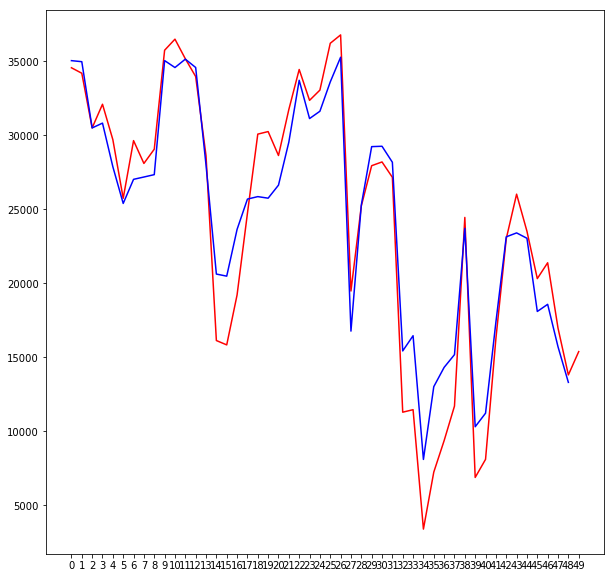


Time Taken :  78.39084315299988

 {'R2': 0.67489720653762575, 'RMSE': 6672.1513758642304, 'MAE': 4683.5684401622721}


In [115]:
'''
Running the extra trees regressor on df_new_thermal, where :
df_new_thermal : full dataframe of house:1632 with consumption in Watt-Hr.

Using the total load of the previous four weeks, corresponding to the same day.
'''
thermal_dict = {}
model_history = {}
ti = time.time()
thermal_dict,y_test1,y_pred1 = extra_trees(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,stop=30)
tf = time.time()
print ("\nTime Taken : ",tf-ti)
print ("\n",thermal_dict)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
Dimensions of temp :  (1700, 2)


 Dimensions of ndf :  (1700, 31)
Shape of ndf after merging :  (1670, 33)
    dow  month     t-30     t-29     t-28     t-27   

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Feature ranking according to the ETR : 
1. feature 31 (0.480714)
2. feature 30 (0.095870)
3. feature 29 (0.045277)
4. feature 28 (0.043886)
5. feature 27 (0.035102)
6. feature 26 (0.021803)
7. feature 18 (0.016752)
8. feature 19 (0.015836)
9. feature 25 (0.015048)
10. feature 20 (0.013152)
11. feature 24 (0.012301)
12. feature 15 (0.012267)
13. feature 17 (0.012171)
14. feature 5 (0.011878)
15. feature 2 (0.011719)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]

16. feature 8 (0.011653)
17. feature 21 (0.011630)
18. feature 23 (0.011428)
19. feature 16 (0.011387)
20. feature 22 (0.011209)
21. feature 4 (0.011163)
22. feature 14 (0.010835)
23. feature 12 (0.010513)
24. feature 11 (0.010437)
25. feature 13 (0.010089)
26. feature 6 (0.010016)
27. feature 9 (0.009416)
28. feature 3 (0.009306)
29. feature 7 (0.009063)
30. feature 10 (0.008078)
31. feature 1 (0.000000)
32. feature 0 (0.000000)
Ranking of the features :  [17 16  2 13  4  1 11 14  5 12 15  3  9  1 10  1  8  1  1  1  1  7  1  1  6
  1  1  1  1  1  1  1] 



R2 Score :  0.680817540079
RMSE :  6639.13373047
MAE :  4664.74742302


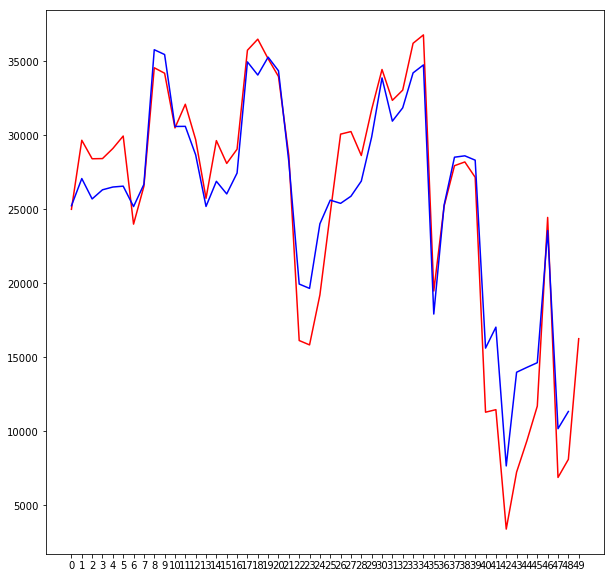


Time Taken :  74.37799048423767

 {'R2': 0.68081754007914397, 'RMSE': 6639.1337304748786, 'MAE': 4664.7474230206253}


In [117]:
'''
Running the extra trees regressor on df_new_thermal, where :
df_new_thermal : full dataframe of house:1632 with consumption in Watt-Hr.

Not using the total load of the previous four weeks, corresponding to the same day.
'''
thermal_dict = {}
model_history = {}
ti = time.time()
thermal_dict,y_test1,y_pred1 = extra_trees(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,stop=30)
tf = time.time()
print ("\nTime Taken : ",tf-ti)
print ("\n",thermal_dict)

In [27]:
df_thermal.head()

localhour air1 air2 air3    furnace1   furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      0.0059       0.01            0   
1  2013-03-23 09:00:00-05    0    0    0  0.00491667       0.01            0   
2  2013-03-23 10:00:00-05    0    0    0      0.0059  0.0762833     0.181567   
3  2013-03-23 11:00:00-05    0    0    0      0.0059  0.0760333      1.32477   
4  2013-03-23 12:00:00-05    0    0    0       0.006       0.01            0   

  total_thermal_load  
0             0.0159  
1          0.0149167  
2            0.26375  
3             1.4067  
4              0.016

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14.1060630784 max: 73.69508333333333 min: 0.5525999999999999

 The DataFrame to be passed to the model. 
          0
0  3.21287
1  8.62352
2  20.2004
3  9.76093
4  9.11042
(

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.652360226906
MSE :  12.2927772293
MAE :  2.56187214645


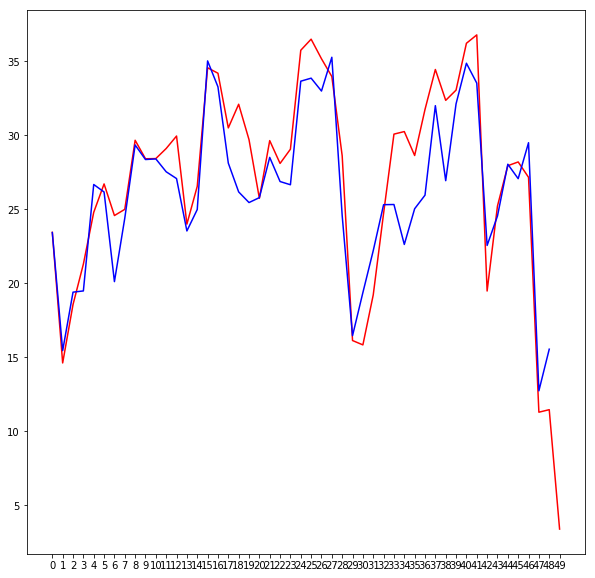

Time Taken :  2.2321622371673584
{'R2': 0.65236022690642315, 'MSE': 12.292777229332618, 'MAE': 2.5618721464497018}


In [28]:
'''
Running extra-trees regressor on df_thermal, where :
df_thermal : full dataframe of house:1632 with the consumptions in KWhr.

Metric is adjusted, incorporating the SHIFT.

'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14.1060630784 max: 73.69508333333333 min: 0.5525999999999999

 The DataFrame to be passed to the model. 
          0
0  3.21287
1  8.62352
2  20.2004
3  9.76093
4  9.11042
(

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.65043674491
MSE :  12.2962747864
MAE :  2.56178771611


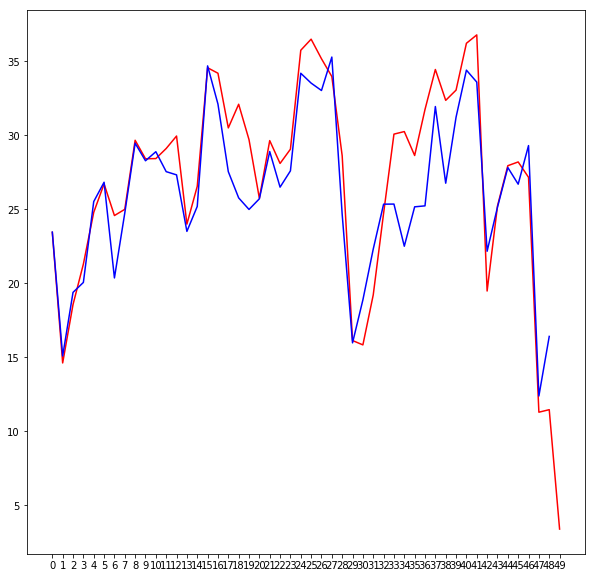

Time Taken :  2.060117244720459
{'R2': 0.65043674490967673, 'MSE': 12.296274786411789, 'MAE': 2.5617877161078226}


In [29]:
'''
Running extra trees regressor considering only 'air1','furnace1' and 'heater1', of house : 1632, 
where the dataframe contains consumption in terms of KWhr.

When run on all the columns,

('R2 Score : ', 0.6522723453798559)
('MSE : ', 12.20056712597718)
('MAE : ', 2.5690554018737646)

Metric is adjusted, incorporating the SHIFT.

'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)



 House :  1037
End i:  450
                                           timestamp air1 furnace1  \
0  2014-02-07 19:00:00-062014-02-07 19:00:00-0620...    0  20428.5   
1  2014-02-08 19:00:00-062014-02-08 19:00:00-0620...    0   7923.2   
2  2014-02-09 19:00:00-062014-02-09 19:00:00-0620...    0  11310.3   
3  2014-02-10 19:00:00-062014-02-10 19:00:00-0620...    0  27065.6   
4  2014-02-11 19:00:00-062014-02-11 19:00:00-0620...    0  21793.3   

  waterheater1 total_load  
0         3045    23473.5  
1      1036.67    8959.87  
2      3513.15    14823.5  
3      1186.97    28252.6  
4       2429.2    24222.5  
(450, 5)
Inside extra trees :  (450, 5)
mean : 9912.59274074 max: 38759.86666666666 min: 595.7166666666666

 The DataFrame to be passed to the model. 
          0
0  23473.5
1  8959.87
2  14823.5
3  28252.6
4  24222.5
(443, 7) (443,)
            t-7      t-6      t-5      t-4      t-3      t-2      t-1        t
count    443.00   444.00   445.00   446.00   447.00   448.00   449.00

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.441301700943
MSE :  31879923.1364
MAE :  3338.26178662


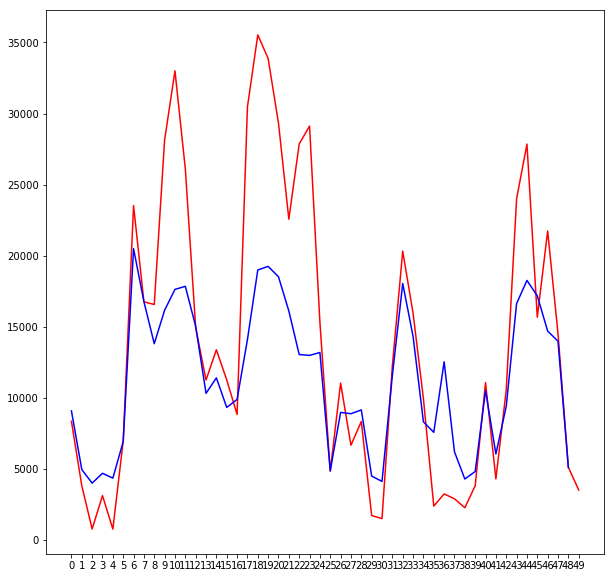

Time Taken :  3.514356851577759
{'R2': 0.44130170094256727, 'MSE': 31879923.136440448, 'MAE': 3338.261786616155}


 House :  115
End i:  1155
                                           timestamp air1 furnace1  \
0  2014-01-24 19:00:00-062014-01-24 19:00:00-0620...    0  19820.9   
1  2014-01-25 19:00:00-062014-01-25 19:00:00-0620...    0  5199.87   
2  2014-01-26 19:00:00-062014-01-26 19:00:00-0620...    0  19829.8   
3  2014-01-27 19:00:00-062014-01-27 19:00:00-0620...    0  39658.6   
4  2014-01-28 19:00:00-062014-01-28 19:00:00-0620...    0  31764.2   

  waterheater1 total_load  
0       1102.5    20923.4  
1      1241.45    6441.32  
2      1227.93    21057.7  
3         1931    41589.6  
4      1681.98    33446.2  
(1155, 5)
Inside extra trees :  (1155, 5)
mean : 7630.87502165 max: 56141.48333333334 min: 363.5833333333332

 The DataFrame to be passed to the model. 
          0
0  20923.4
1  6441.32
2  21057.7
3  41589.6
4  33446.2
(1148, 7) (1148,)
           t-7     t-6     t-5 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.732991711498
MSE :  5303299.34285
MAE :  1771.9387468


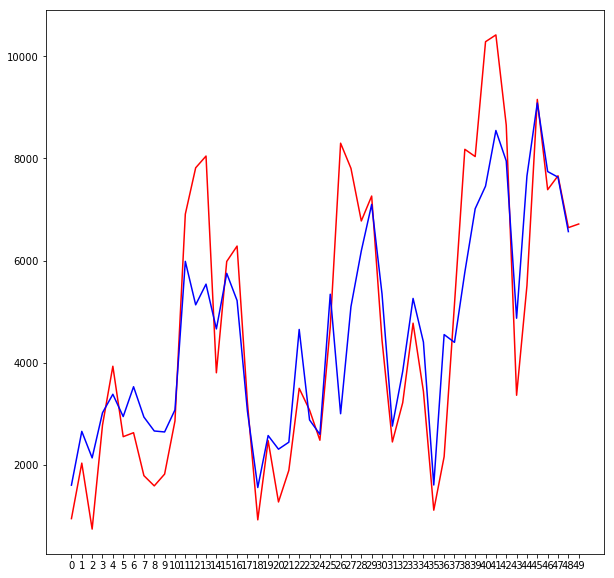

Time Taken :  17.2287757396698
{'R2': 0.73299171149847475, 'MSE': 5303299.3428481333, 'MAE': 1771.9387468023226}


 House :  2401
End i:  1231
                                           timestamp air1 furnace1  \
0  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...    0    11807   
1  2014-01-05 19:00:00-062014-01-05 19:00:00-0620...    0  50385.7   
2  2014-01-06 19:00:00-062014-01-06 19:00:00-0620...    0    25804   
3  2014-01-07 19:00:00-062014-01-07 19:00:00-0620...    0  11727.4   
4  2014-01-08 19:00:00-062014-01-08 19:00:00-0620...    0  3327.92   

  waterheater1 total_load  
0         4309      16116  
1      2906.05    53291.7  
2      1604.37    27408.3  
3      2407.25    14134.7  
4      2433.78     5761.7  
(1231, 5)
Inside extra trees :  (1231, 5)
mean : 9222.48122123 max: 53291.73333333333 min: 422.79999999999995

 The DataFrame to be passed to the model. 
          0
0    16116
1  53291.7
2  27408.3
3  14134.7
4   5761.7
(1224, 7) (1224,)
                t-7          

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.499137376772
MSE :  13281373.7595
MAE :  2541.76692543


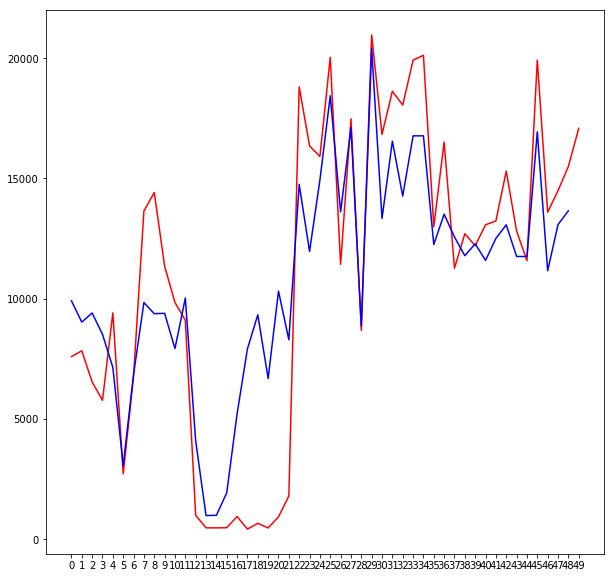

Time Taken :  19.03609013557434
{'R2': 0.49913737677160441, 'MSE': 13281373.75949093, 'MAE': 2541.7669254314333}


 House :  3268
End i:  1083
                                           timestamp      air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...   1.08333  31901.1   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...  0.983333  2331.65   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...       0.7        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...   1.06667  11474.7   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...   5.08333  18486.8   

  waterheater1 total_load  
0      740.283    32642.5  
1      738.483    3071.12  
2      523.233    523.933  
3      725.517    12201.3  
4      3130.28    21622.1  
(1083, 5)
Inside extra trees :  (1083, 5)
mean : 4589.67005809 max: 44031.3 min: 364.99999999999983

 The DataFrame to be passed to the model. 
          0
0  32642.5
1  3071.12
2  523.933
3  12201.3
4  21622.1
(1076, 7) (1076,)
         

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.369064406449
MSE :  4525845.47938
MAE :  1116.5819131


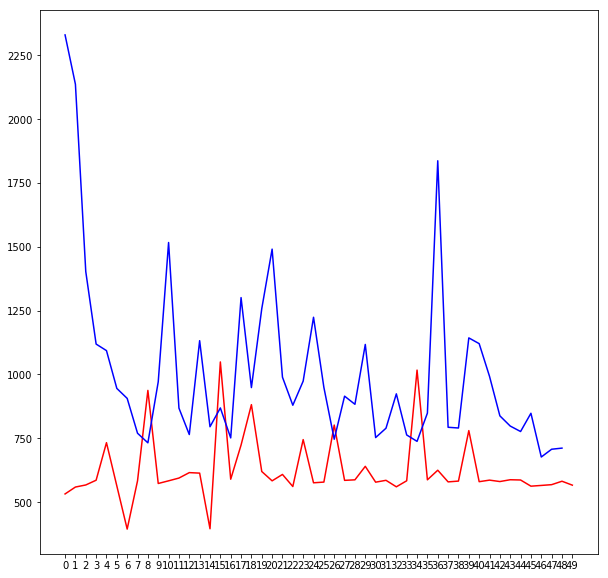

Time Taken :  14.456186532974243
{'R2': 0.36906440644887395, 'MSE': 4525845.4793827049, 'MAE': 1116.5819130952382}


 House :  3273
End i:  1385
                                           timestamp  air1 furnace1  \
0  2013-12-17 19:00:00-062013-12-17 19:00:00-0620...  0.55     2.95   
1  2013-12-18 19:00:00-062013-12-18 19:00:00-0620...     0      2.4   
2  2013-12-19 19:00:00-062013-12-19 19:00:00-0620...     0        0   
3  2013-12-20 19:00:00-062013-12-20 19:00:00-0620...     0  3.48333   
4  2013-12-21 19:00:00-062013-12-21 19:00:00-0620...     0     2.65   

  waterheater1 total_load  
0      3421.87    3425.37  
1      5774.15    5776.55  
2         1621       1621  
3      8605.05    8608.53  
4      3465.72    3468.37  
(1385, 5)
Inside extra trees :  (1385, 5)
mean : 8374.72022864 max: 35128.58333333333 min: 606.9833333333332

 The DataFrame to be passed to the model. 
          0
0  3425.37
1  5776.55
2     1621
3  8608.53
4  3468.37
(1378, 7) (1378,)
           t-7     t-6

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


R2 Score :  0.351233494391
MSE :  3564972.98926
MAE : 

/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 1467.39726675


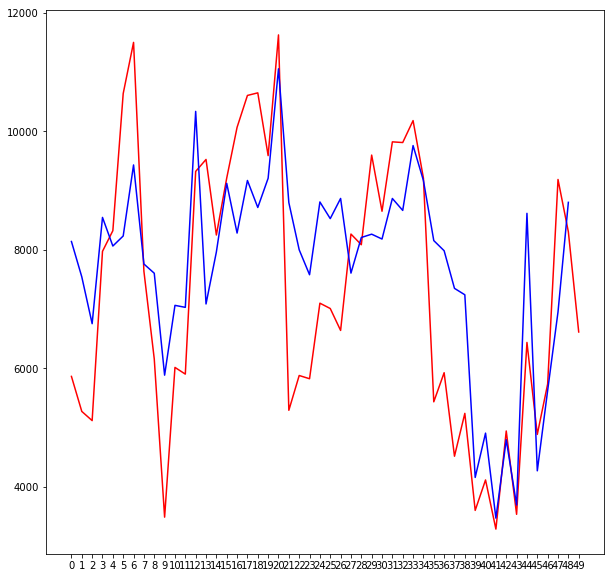

Time Taken :  21.957313537597656
{'R2': 0.35123349439148066, 'MSE': 3564972.9892617967, 'MAE': 1467.397266747377}


 House :  4000
End i:  305
                                           timestamp     air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...      6.6  13293.8   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...    12.05  2454.37   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...  12.2667        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...     7.15  4171.87   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...  12.5167  14696.3   

  waterheater1 total_load  
0      3747.68    17048.1  
1      6504.68     8971.1  
2       6800.6    6812.87  
3      4112.43    8291.45  
4      6781.08    21489.9  
(305, 5)
Inside extra trees :  (305, 5)
mean : 6330.40295082 max: 31007.833333333336 min: 680.6

 The DataFrame to be passed to the model. 
          0
0  17048.1
1   8971.1
2  6812.87
3  8291.45
4  21489.9
(298, 7) (298,)
            t-7      

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  -0.313499808745
MSE :  7269827.13029
MAE :  1907.97310749


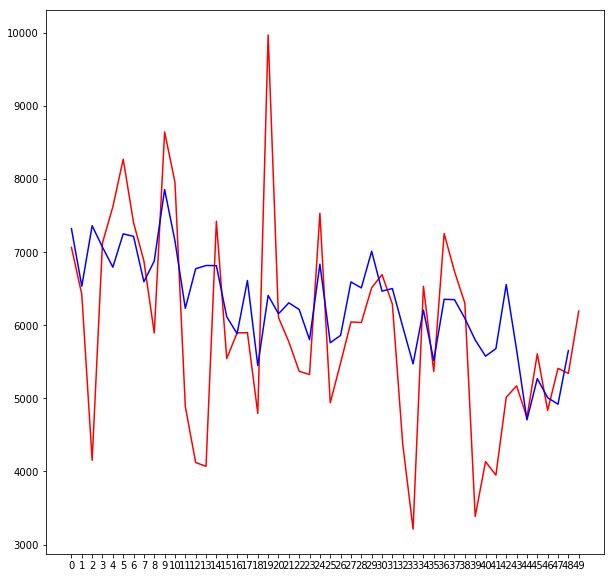

Time Taken :  2.1713335514068604
{'R2': -0.31349980874507644, 'MSE': 7269827.1302890899, 'MAE': 1907.9731074906349}


 House :  6324
End i:  202
                                           timestamp     air1 furnace1  \
0  2014-12-01 01:00:00-062014-12-01 01:00:00-0620...  4.93333   5745.3   
1  2014-12-02 01:00:00-062014-12-02 01:00:00-0620...  4.73333  5120.58   
2  2014-12-03 01:00:00-062014-12-03 01:00:00-0620...  6.31667  315.283   
3  2014-12-04 01:00:00-062014-12-04 01:00:00-0620...  1.76667     0.35   
4  2014-12-05 01:00:00-062014-12-05 01:00:00-0620...  6.26667        0   

  waterheater1 total_load  
0      2848.73    8598.97  
1      2649.65    7774.97  
2      3462.27    3783.87  
3      1019.75    1021.87  
4      3698.32    3704.58  
(202, 5)
Inside extra trees :  (202, 5)
mean : 4028.92211221 max: 20783.283333333333 min: 471.1666666666667

 The DataFrame to be passed to the model. 
          0
0  8598.97
1  7774.97
2  3783.87
3  1021.87
4  3704.58
(195, 7) (195,)
       

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(136,) (59,)
R2 Score :  0.0892068988459
MSE :  702759.013342
MAE :  472.139471264


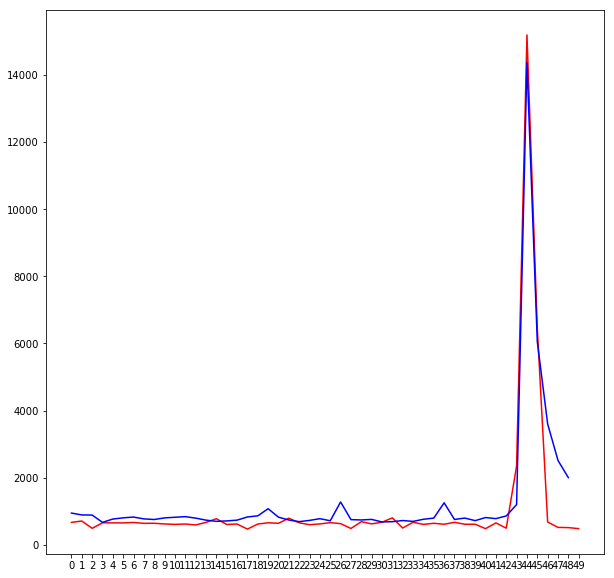

Time Taken :  1.441256046295166
{'R2': 0.089206898845932026, 'MSE': 702759.01334219554, 'MAE': 472.13947126437006}


 House :  6614
End i:  452
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.1   2163.2   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     4.05  9143.13   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...     2.75  7275.53   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...  2.46667  1357.05   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     2.75  3554.23   

  waterheater1 total_load  
0      1233.62    3397.92  
1      3536.78      12684  
2       2735.6    10013.9  
3      2733.27    4092.78  
4      2073.17    5630.15  
(452, 5)
Inside extra trees :  (452, 5)
mean : 6535.17116519 max: 40480.683333333334 min: 766.5333333333333

 The DataFrame to be passed to the model. 
          0
0  3397.92
1    12684
2  10013.9
3  4092.78
4  5630.15
(445, 7) (445,)
        

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.106729729152
MSE :  19727426.5571
MAE :  3150.28019799


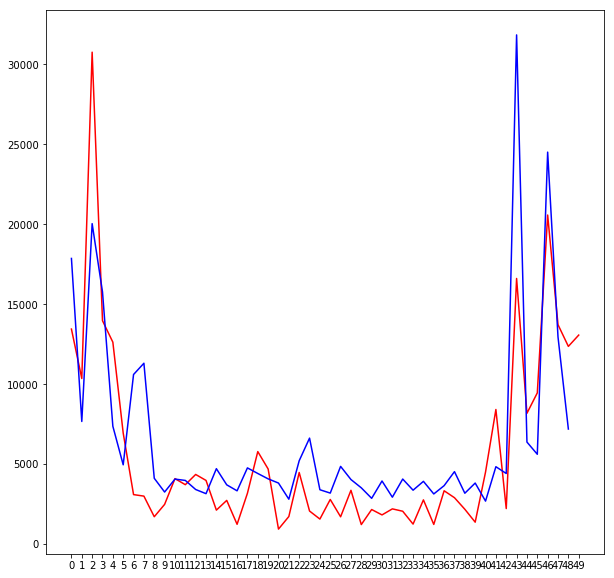

Time Taken :  3.2056527137756348
{'R2': 0.10672972915173495, 'MSE': 19727426.557131562, 'MAE': 3150.2801979949872}


 House :  9912
End i:  1286
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.5  12388.8   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     0.95  8235.38   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...  3.13333  11923.3   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...      3.3  6036.62   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     3.85      402   

  waterheater1 total_load  
0      2183.45    14573.8  
1      1675.95    9912.28  
2       4111.9    16038.4  
3      4647.52    10687.4  
4      5109.57    5515.42  
(1286, 5)
Inside extra trees :  (1286, 5)
mean : 6980.34348108 max: 40758.61666666666 min: 562.2333333333332

 The DataFrame to be passed to the model. 
          0
0  14573.8
1  9912.28
2  16038.4
3  10687.4
4  5515.42
(1279, 7) (1279,)
    

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.525771877808
MSE :  9221402.21821
MAE :  2177.46172071


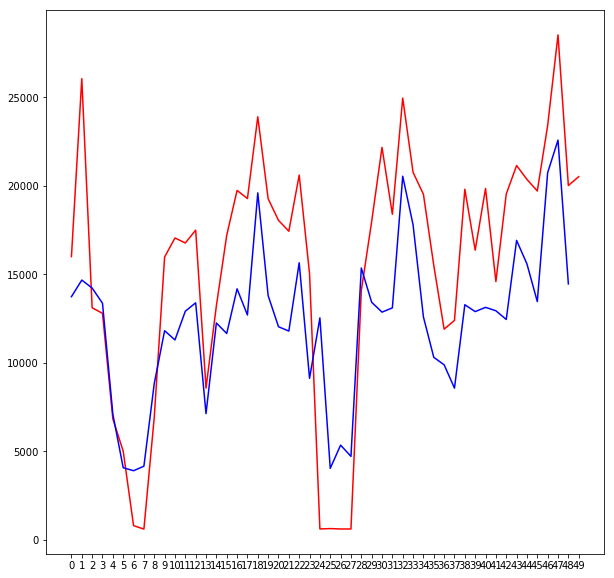

Time Taken :  19.47272777557373
{'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}
{1037: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 115: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 2401: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 3268: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 3273: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 4000: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 6324: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 6614: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 9912: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}}


In [30]:
'''
Running the model (EXTRA-TREES REGRESSOR) and comparing on other houses.
'''
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
for i in range(len(hid)):
    print ("\n\n House : ",hid[i])
    d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[i])+".pkl")
    d_total.isnull().sum()
    #Selecting only the attributes, which are common to all the houses.
    d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
    #Converting the consumption values from 'KWhr' to 'Watthr'.
    d_total = d_total*1000

    thermal_dict1 = {}
    ti = time.time()
    thermal_dict1,y_test1,y_pred1 = extra_trees(d_total,thermal_dict,1,"mean_squared_error",4,day_hour,False)
    tf = time.time()

    print ("Time Taken : ",tf-ti)
    print (thermal_dict1)
    d[hid[i]] = thermal_dict1

print (d)   

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside nn :  (1700, 8)
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05    

1185/1185 [==============================] - 0s - loss: 54.2681 - mean_squared_error: 54.2681     
Epoch 55/750
1185/1185 [==============================] - 0s - loss: 54.2974 - mean_squared_error: 54.2974     
Epoch 56/750
1185/1185 [==============================] - 0s - loss: 54.2244 - mean_squared_error: 54.2244     
Epoch 57/750
1185/1185 [==============================] - 0s - loss: 54.0885 - mean_squared_error: 54.0885     
Epoch 58/750
1185/1185 [==============================] - 0s - loss: 54.1625 - mean_squared_error: 54.1625     
Epoch 59/750
1185/1185 [==============================] - 0s - loss: 54.1851 - mean_squared_error: 54.1851     
Epoch 60/750
1185/1185 [==============================] - 0s - loss: 54.0932 - mean_squared_error: 54.0932     
Epoch 61/750
1185/1185 [==============================] - 0s - loss: 58.8535 - mean_squared_error: 58.8535     
Epoch 62/750
1185/1185 [==============================] - 0s - loss: 54.3683 - mean_squared_error: 54.3683     
Epoch

1185/1185 [==============================] - 0s - loss: 53.7033 - mean_squared_error: 53.7033     
Epoch 128/750
1185/1185 [==============================] - 0s - loss: 53.8768 - mean_squared_error: 53.8768     
Epoch 129/750
1185/1185 [==============================] - 0s - loss: 53.9324 - mean_squared_error: 53.9324     
Epoch 130/750
1185/1185 [==============================] - 0s - loss: 53.8129 - mean_squared_error: 53.8129     
Epoch 131/750
1185/1185 [==============================] - 0s - loss: 53.8939 - mean_squared_error: 53.8939     
Epoch 132/750
1185/1185 [==============================] - 0s - loss: 53.6188 - mean_squared_error: 53.6188     
Epoch 133/750
1185/1185 [==============================] - 0s - loss: 53.6146 - mean_squared_error: 53.6146     
Epoch 134/750
1185/1185 [==============================] - 0s - loss: 53.7099 - mean_squared_error: 53.7099     
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 53.6575 - mean_squared_error: 53.6575   

1185/1185 [==============================] - 0s - loss: 54.9281 - mean_squared_error: 54.9281     
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 53.1899 - mean_squared_error: 53.1899     
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 53.3263 - mean_squared_error: 53.3263     
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 53.1256 - mean_squared_error: 53.1256     
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 53.1694 - mean_squared_error: 53.1694     
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 53.2964 - mean_squared_error: 53.2964     
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 53.0525 - mean_squared_error: 53.0525     
Epoch 278/750
1185/1185 [==============================] - 0s - loss: 53.5795 - mean_squared_error: 53.5795     
Epoch 279/750
1185/1185 [==============================] - 0s - loss: 53.2348 - mean_squared_error: 53.2348   

1185/1185 [==============================] - 0s - loss: 53.1744 - mean_squared_error: 53.1744     
Epoch 415/750
1185/1185 [==============================] - 0s - loss: 53.7146 - mean_squared_error: 53.7146     
Epoch 416/750
1185/1185 [==============================] - 0s - loss: 53.8758 - mean_squared_error: 53.8758     
Epoch 417/750
1185/1185 [==============================] - 0s - loss: 53.0646 - mean_squared_error: 53.0646     
Epoch 418/750
1185/1185 [==============================] - 0s - loss: 53.0888 - mean_squared_error: 53.0888     
Epoch 419/750
1185/1185 [==============================] - 0s - loss: 52.9911 - mean_squared_error: 52.9911     
Epoch 420/750
1185/1185 [==============================] - 0s - loss: 53.1344 - mean_squared_error: 53.1344     
Epoch 421/750
1185/1185 [==============================] - 0s - loss: 53.4765 - mean_squared_error: 53.4765     
Epoch 422/750
1185/1185 [==============================] - 0s - loss: 53.1288 - mean_squared_error: 53.1288   

1185/1185 [==============================] - 0s - loss: 53.1442 - mean_squared_error: 53.1442     
Epoch 558/750
1185/1185 [==============================] - 0s - loss: 53.0389 - mean_squared_error: 53.0389     
Epoch 559/750
1185/1185 [==============================] - 0s - loss: 53.1253 - mean_squared_error: 53.1253     
Epoch 560/750
1185/1185 [==============================] - 0s - loss: 53.0236 - mean_squared_error: 53.0236     
Epoch 561/750
1185/1185 [==============================] - 0s - loss: 52.9165 - mean_squared_error: 52.9165     
Epoch 562/750
1185/1185 [==============================] - 0s - loss: 52.9167 - mean_squared_error: 52.9167     
Epoch 563/750
1185/1185 [==============================] - 0s - loss: 52.9750 - mean_squared_error: 52.9750     
Epoch 564/750
1185/1185 [==============================] - 0s - loss: 53.0647 - mean_squared_error: 53.0647     
Epoch 565/750
1185/1185 [==============================] - 0s - loss: 52.9739 - mean_squared_error: 52.9739   

1185/1185 [==============================] - 0s - loss: 53.1831 - mean_squared_error: 53.1831     
Epoch 702/750
1185/1185 [==============================] - 0s - loss: 53.2298 - mean_squared_error: 53.2298     
Epoch 703/750
1185/1185 [==============================] - 0s - loss: 53.3748 - mean_squared_error: 53.3748     
Epoch 704/750
1185/1185 [==============================] - 0s - loss: 53.0972 - mean_squared_error: 53.0972     
Epoch 705/750
1185/1185 [==============================] - 0s - loss: 53.1982 - mean_squared_error: 53.1982     
Epoch 706/750
1185/1185 [==============================] - 0s - loss: 52.8205 - mean_squared_error: 52.8205     
Epoch 707/750
1185/1185 [==============================] - 0s - loss: 59.9953 - mean_squared_error: 59.9953     
Epoch 708/750
1185/1185 [==============================] - 0s - loss: 53.4742 - mean_squared_error: 53.4742     
Epoch 709/750
1185/1185 [==============================] - 0s - loss: 53.1228 - mean_squared_error: 53.1228   

/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


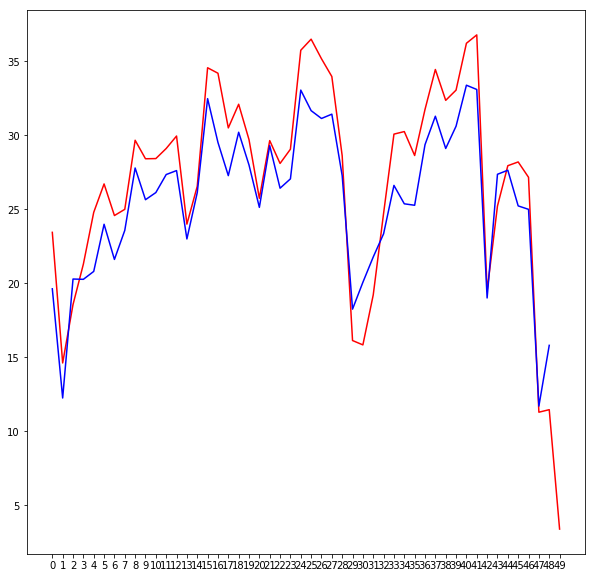

Time Taken :  90.23188972473145
{'R2': 0.69144783227470596, 'MSE': 9.4709239078262453, 'MAE': 2.3788971304694106}


In [38]:
'''
Testing the Neural Network model on df_thermal, where:
df_thermal : full dataframe with consumption values in KWhr.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside nn :  (1700, 8)
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:0

1185/1185 [==============================] - 0s - loss: 55588077.9362 - mean_squared_error: 55588077.9362     
Epoch 116/750
1185/1185 [==============================] - 0s - loss: 55249576.6492 - mean_squared_error: 55249576.6492     
Epoch 117/750
1185/1185 [==============================] - 0s - loss: 55243949.1554 - mean_squared_error: 55243949.1554     
Epoch 118/750
1185/1185 [==============================] - 0s - loss: 55260215.8402 - mean_squared_error: 55260215.8402     
Epoch 119/750
1185/1185 [==============================] - 0s - loss: 55138571.6489 - mean_squared_error: 55138571.6489     
Epoch 120/750
1185/1185 [==============================] - 0s - loss: 55274953.7966 - mean_squared_error: 55274953.7966     
Epoch 121/750
1185/1185 [==============================] - 0s - loss: 55195786.8557 - mean_squared_error: 55195786.8557     
Epoch 122/750
1185/1185 [==============================] - 0s - loss: 55653077.7112 - mean_squared_error: 55653077.7112     
Epoch 123/750


1185/1185 [==============================] - 0s - loss: 55524099.1207 - mean_squared_error: 55524099.1207     
Epoch 245/750
1185/1185 [==============================] - 0s - loss: 55190463.9257 - mean_squared_error: 55190463.9257     
Epoch 246/750
1185/1185 [==============================] - 0s - loss: 55547837.1511 - mean_squared_error: 55547837.1511     
Epoch 247/750
1185/1185 [==============================] - 0s - loss: 55248409.7063 - mean_squared_error: 55248409.7063     
Epoch 248/750
1185/1185 [==============================] - 0s - loss: 55031151.5789 - mean_squared_error: 55031151.5789     
Epoch 249/750
1185/1185 [==============================] - 0s - loss: 55006364.0574 - mean_squared_error: 55006364.0574     
Epoch 250/750
1185/1185 [==============================] - 0s - loss: 55435603.7225 - mean_squared_error: 55435603.7225     
Epoch 251/750
1185/1185 [==============================] - 0s - loss: 55516889.7013 - mean_squared_error: 55516889.7013     
Epoch 252/750


1185/1185 [==============================] - 0s - loss: 55109455.5004 - mean_squared_error: 55109455.5004     
Epoch 375/750
1185/1185 [==============================] - 0s - loss: 56419238.1390 - mean_squared_error: 56419238.1390     
Epoch 376/750
1185/1185 [==============================] - 0s - loss: 55117450.6970 - mean_squared_error: 55117450.6970     
Epoch 377/750
1185/1185 [==============================] - 0s - loss: 55202721.5195 - mean_squared_error: 55202721.5195     
Epoch 378/750
1185/1185 [==============================] - 0s - loss: 55029041.3840 - mean_squared_error: 55029041.3840     
Epoch 379/750
1185/1185 [==============================] - 0s - loss: 55191885.4042 - mean_squared_error: 55191885.4042     
Epoch 380/750
1185/1185 [==============================] - 0s - loss: 55106126.7314 - mean_squared_error: 55106126.7314     
Epoch 381/750
1185/1185 [==============================] - 0s - loss: 55018315.0184 - mean_squared_error: 55018315.0184     
Epoch 382/750


1185/1185 [==============================] - 0s - loss: 55015674.6913 - mean_squared_error: 55015674.6913     
Epoch 503/750
1185/1185 [==============================] - 0s - loss: 54921523.3873 - mean_squared_error: 54921523.3873     
Epoch 504/750
1185/1185 [==============================] - 0s - loss: 54913608.6710 - mean_squared_error: 54913608.6710     
Epoch 505/750
1185/1185 [==============================] - 0s - loss: 54993224.0236 - mean_squared_error: 54993224.0236     
Epoch 506/750
1185/1185 [==============================] - 0s - loss: 54865958.2684 - mean_squared_error: 54865958.2684     
Epoch 507/750
1185/1185 [==============================] - 0s - loss: 54801355.9677 - mean_squared_error: 54801355.9677     
Epoch 508/750
1185/1185 [==============================] - 0s - loss: 55000606.2785 - mean_squared_error: 55000606.2785     
Epoch 509/750
1185/1185 [==============================] - 0s - loss: 54964242.6974 - mean_squared_error: 54964242.6974     
Epoch 510/750


1185/1185 [==============================] - 0s - loss: 54957229.0228 - mean_squared_error: 54957229.0228     
Epoch 632/750
1185/1185 [==============================] - 0s - loss: 55206036.2050 - mean_squared_error: 55206036.2050     
Epoch 633/750
1185/1185 [==============================] - 0s - loss: 54818936.3342 - mean_squared_error: 54818936.3342     
Epoch 634/750
1185/1185 [==============================] - 0s - loss: 54724777.2118 - mean_squared_error: 54724777.2118     
Epoch 635/750
1185/1185 [==============================] - 0s - loss: 54812345.5848 - mean_squared_error: 54812345.5848     
Epoch 636/750
1185/1185 [==============================] - 0s - loss: 54773095.3924 - mean_squared_error: 54773095.3924     
Epoch 637/750
1185/1185 [==============================] - 0s - loss: 54879877.1833 - mean_squared_error: 54879877.1833     
Epoch 638/750
1185/1185 [==============================] - 0s - loss: 54911290.3021 - mean_squared_error: 54911290.3021     
Epoch 639/750


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


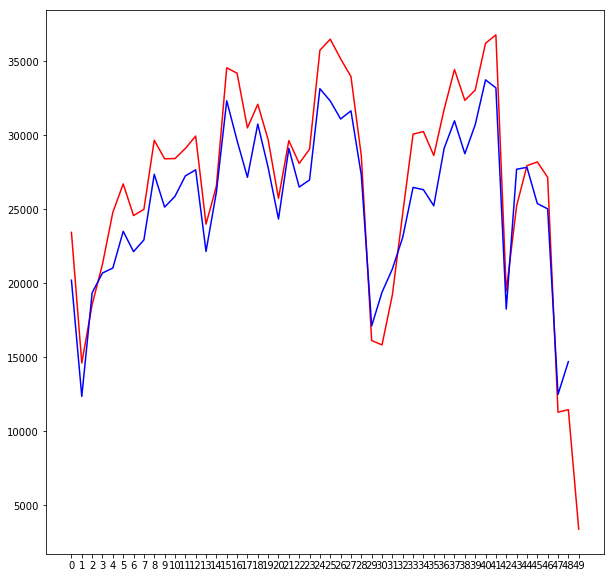

Time Taken :  93.1291275024414
{'R2': 0.6908797778824316, 'MSE': 7237457.9570912169, 'MAE': 1914.2528411965548}


In [100]:
'''
Testing the Neural Network model on df_thermal, where:
df_thermal : full dataframe with consumption values in Watt-hr.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [86]:
'''
Loading all the dataframes into a dictionary, d.
'''

#Dictionary of dataframes.
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
for i in range(len(hid)):
    print ("\n\n House : ",hid[i])
    d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[i])+".pkl")
    d_total.isnull().sum()
    
    #Selecting only the attributes, which are common to all the houses.
    d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
    
    #Converting the consumption values from 'KWhr' to 'Watthr'.
    d_total.iloc[:,[1,2,3]] = d_total.iloc[:,[1,2,3]].mul(1000)
    d[hid[i]] = d_total



 House :  1037


 House :  115


 House :  2401


 House :  3268


 House :  3273


 House :  4000


 House :  6324


 House :  6614


 House :  9912


In [89]:
#Sanity Check.
d[1037].head()

localhour  air1     furnace1  waterheater1
0  2014-02-07 19:00:00-06   0.0     0.000000    146.233333
1  2014-02-07 20:00:00-06   0.0  2200.100000      0.000000
2  2014-02-07 21:00:00-06   0.0  1313.366667      0.000000
3  2014-02-07 22:00:00-06   0.0    34.600000      0.000000
4  2014-02-07 23:00:00-06   0.0     0.000000    151.000000

In [ ]:
'''
Whatever follows below, is INCONSEQUENTIAL.
'''

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_month(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(168), df.shift(24), df], axis=1)
                    ndf.columns = ('t-168', 't-24', 't')
                    ndf = ndf.iloc[168:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_4hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-4','t-3','t-2', 't-1', 't')
                    ndf = ndf.iloc[4:]

                    x = ndf[ndf.columns[0:4]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]

                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
#Metric : 'r^2'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

In [ ]:
#Metric : 'r^2'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

In [ ]:
#Metric : 'r^2'.
scores_month = et_month(df_thermal)
print (scores_month)

In [ ]:
#Metric : 'mse'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

In [ ]:
#Metric : 'mse'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

In [ ]:
df_thermal.head(10)

In [ ]:
df_thermal.to_csv("df_thermal.csv",encoding="utf8")

In [ ]:
for i in df_thermal.columns:
    print (np.amax(df_thermal[i]))

In [ ]:
df_thermal.shape

In [ ]:
df_thermal.head(50)

In [ ]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
columns = np.empty([df_thermal.shape[0],1],dtype=str)
i=0
while i <= (df_thermal.shape[0]-7):
    columns[i]   = 'Saturday'
    columns[i+1] = 'Sunday'
    columns[i+2] = 'Monday'
    columns[i+3] = 'Tuesday'
    columns[i+4] = 'Wednesday'
    columns[i+5] = 'Thursday'
    columns[i+6] = 'Friday'
    i += 7

In [ ]:
print (columns[0])

In [ ]:
plt.plot(df_thermal.values[:,1:])
plt.show()

In [ ]:
for i in range(df_thermal.columns.shape[0]):    
    print ("\nMAX,MIN: ",np.max(df_thermal.values[:,i])," ",np.min(df_thermal.values[:,i]) )

In [ ]:
d1 = pd.DataFrame(new_df1[:50,0])

In [ ]:
d2 = pd.DataFrame(new_df1[:50,4:6])

In [ ]:
d = pd.concat([d1,d2],axis=1)
d.columns = [df_thermal.columns[0],df_thermal.columns[4],df_thermal.columns[5]]
d.head()

In [ ]:
d_total = pd.DataFrame(df_thermal)
d_total.shape

In [ ]:
np.amax(d_total)

In [ ]:
unique_1 , counts_1 = np.unique(d_total.values[:,4],return_counts=True)
unique_2 , counts_2 = np.unique(d_total.values[:,5],return_counts=True)

In [ ]:
dict_count1 = dict(zip(unique_1,counts_1))
dict_count2 = dict(zip(unique_2,counts_2))
print ("Count of 0's : ",dict_count1[0],dict_count2[0])
print ("Count of 5's : ",dict_count1[5],dict_count2[10])

In [ ]:
print (np.sum(d_total.values[:,4]==6))
print (np.sum(d_total.values[:,5]==10))

In [ ]:
'''
8*7
23*7
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,56,161)
tf = time.time()
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [ ]:
d_total.values[(np.where(d_total.values[:,4] == 5)[0])]

In [ ]:
plt.hist((df_thermal.values[:,4]),bins=100)
plt.show()

In [ ]:
np.mean(df_thermal.values[:,4])

In [ ]:
new_df1.shape

In [ ]:
plt.title("Furnace 1")
plt.hist((new_df1[:,4]),bins=100)
plt.show()

In [ ]:
plt.title("Furnace 2")
plt.hist((new_df1[:,5]),bins=100)
plt.show()

In [127]:
df_new_thermal.columns

Index(['localhour', 'air1', 'air2', 'air3', 'furnace1', 'furnace2',
       'waterheater1', 'total_thermal_load'],
      dtype='object')

In [151]:
df_thermal.head()

localhour air1 air2 air3    furnace1   furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      0.0059       0.01            0   
1  2013-03-23 09:00:00-05    0    0    0  0.00491667       0.01            0   
2  2013-03-23 10:00:00-05    0    0    0      0.0059  0.0762833     0.181567   
3  2013-03-23 11:00:00-05    0    0    0      0.0059  0.0760333      1.32477   
4  2013-03-23 12:00:00-05    0    0    0       0.006       0.01            0   

  total_thermal_load  
0             0.0159  
1          0.0149167  
2            0.26375  
3             1.4067  
4              0.016

In [205]:
new_df1 = pd.DataFrame(new_df1)
new_df1.head()

localhour  air1  air2  air3  furnace1  furnace2  waterheater1  \
0        NaN   NaN   NaN   NaN       NaN       NaN           NaN   
1        NaN   NaN   NaN   NaN       NaN       NaN           NaN   
2        NaN   NaN   NaN   NaN       NaN       NaN           NaN   
3        NaN   NaN   NaN   NaN       NaN       NaN           NaN   
4        NaN   NaN   NaN   NaN       NaN       NaN           NaN   

   total_thermal_load  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN

In [134]:
new_df1['weekday'] = pd.to_datetime(new_df1['localhour']).dt.dayofweek
new_df1['month'] = pd.to_datetime(new_df1['localhour']).dt.month

In [136]:
new_df1.tail()

localhour air1 furnace1 waterheater1 total_thermal_load  \
1695  2017-11-12 07:00:00-06    0  120.267      820.217            940.483   
1696  2017-11-13 07:00:00-06    0      120      1215.93            1335.93   
1697  2017-11-14 07:00:00-06    0  120.183      823.233            943.417   
1698  2017-11-15 07:00:00-06    0   120.15      1234.83            1354.98   
1699  2017-11-16 07:00:00-06    0  120.167      823.267            943.433   

      weekday  month  
1695        6     11  
1696        0     11  
1697        1     11  
1698        2     11  
1699        3     11

In [48]:
new_df1.tail()

localhour air1 furnace1 waterheater1 total_thermal_load  \
1695  2017-11-12 07:00:00-06    0  120.267      820.217            940.483   
1696  2017-11-13 07:00:00-06    0      120      1215.93            1335.93   
1697  2017-11-14 07:00:00-06    0  120.183      823.233            943.417   
1698  2017-11-15 07:00:00-06    0   120.15      1234.83            1354.98   
1699  2017-11-16 07:00:00-06    0  120.167      823.267            943.433   

     month  
1695    11  
1696    11  
1697    11  
1698    11  
1699    11

In [ ]:
new_df1.values[0][0]

In [46]:
new_df1["month"] = new_df1["total_thermal_load"]
for i in range(new_df1.shape[0]):
    new_df1["month"].values[i] = new_df1.values[i][0][5:7] + new_df1.values[i][0][5:7]

In [ ]:
new_df1["total_thermal_load"]

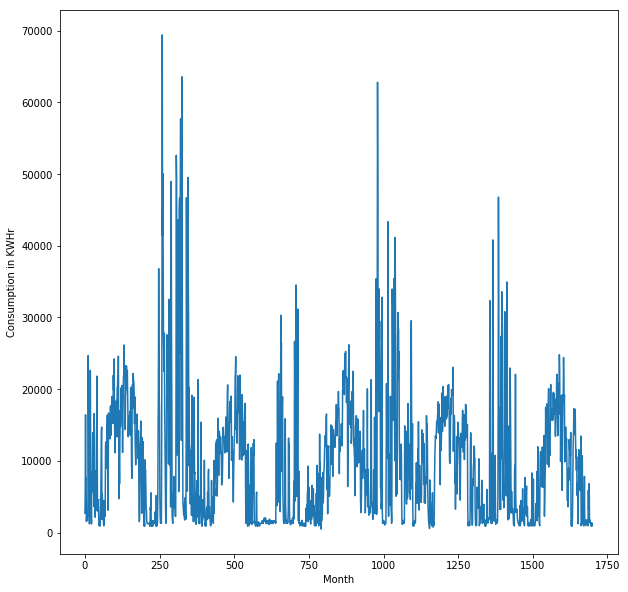

In [28]:
plt.figure(figsize=(10,10))
plt.plot()
plt.xticks(new_df1["month"])
plt.ylabel("Consumption in KWHr")
plt.xlabel("Month")
plt.show()